In [ ]:
# RealWorld-HAR (RealWorld2016, University of Mannheim)
!mkdir -p /content/data/rwhar
%cd /content/data/rwhar

# Attempt HTTPS first (disabling certificate verification due to an SNI mismatch on the host); on failure, fall back to HTTP
!wget -c --no-check-certificate "https://wifo5-14.informatik.uni-mannheim.de/sensor/dataset/realworld2016/realworld2016_dataset.zip" -O realworld2016_dataset.zip || wget -c "http://wifo5-14.informatik.uni-mannheim.de/sensor/dataset/realworld2016/realworld2016_dataset.zip" -O realworld2016_dataset.zip

# Decompress and perform a brief inspection
!unzip -q -o realworld2016_dataset.zip
!echo "=== top-level ==="
!ls -lah
!echo "=== dirs (depth<=2) ==="
!find . -maxdepth 2 -type d | sort | head -n 20

/content/data/rwhar
--2025-11-13 09:01:23--  https://wifo5-14.informatik.uni-mannheim.de/sensor/dataset/realworld2016/realworld2016_dataset.zip
Resolving wifo5-14.informatik.uni-mannheim.de (wifo5-14.informatik.uni-mannheim.de)... 134.155.98.56
Connecting to wifo5-14.informatik.uni-mannheim.de (wifo5-14.informatik.uni-mannheim.de)|134.155.98.56|:443... connected.
	requested host name ‘wifo5-14.informatik.uni-mannheim.de’.
HTTP request sent, awaiting response... 403 Forbidden
2025-11-13 09:01:24 ERROR 403: Forbidden.

--2025-11-13 09:01:24--  http://wifo5-14.informatik.uni-mannheim.de/sensor/dataset/realworld2016/realworld2016_dataset.zip
Resolving wifo5-14.informatik.uni-mannheim.de (wifo5-14.informatik.uni-mannheim.de)... 134.155.98.56
Connecting to wifo5-14.informatik.uni-mannheim.de (wifo5-14.informatik.uni-mannheim.de)|134.155.98.56|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3721016476 (3.5G) [application/zip]
Saving to: ‘realworld2016_dataset.zip’

re

In [ ]:
# ================ Step 0: Project Initialization ================
import os
from datetime import datetime

# Create directory structure
dirs = ['data/raw', 'interim', 'proc', 'features', 'models', 'logs', 'figures', 'configs']
for d in dirs:
    os.makedirs(f'/content/{d}', exist_ok=True)
print("✓ Directory structure created")

# Git Initialization
%cd /content
!git init
!git config user.name "HAR-Project"
!git config user.email "har@project.local"
print("✓ Git repository initialized")

# Persist environment information
!pip freeze > logs/env.txt
print("✓ Environment dependencies saved to logs/env.txt")

# Persist random seed list and hardware information
import json
import subprocess

meta = {
    "timestamp": datetime.now().isoformat(),
    "random_seeds": [42, 123, 456, 789, 2024],  # predefined seeds
    "hardware": {
        "gpu": subprocess.getoutput("nvidia-smi --query-gpu=name --format=csv,noheader"),
        "cpu": subprocess.getoutput("cat /proc/cpuinfo | grep 'model name' | head -1").split(':')[1].strip(),
    }
}

with open('logs/init_meta.json', 'w') as f:
    json.dump(meta, f, indent=2)
print("✓ Metadata saved to logs/init_meta.json")

# Initial commit
!git add .
!git commit -m "init: project structure and environment"
git_hash = subprocess.getoutput("git rev-parse HEAD")
print(f"✓ Git commit hash: {git_hash[:8]}")


# ================ Step 1: Data Acquisition (Compliance) ================
# Move raw data to data/raw/ and retain structure
!mv /content/data/rwhar/* /content/data/raw/ 2>/dev/null || true
!rm -rf /content/data/rwhar
print("✓ Raw data moved to data/raw/")

# Compute checksums
import hashlib

def calc_checksum(filepath):
    h = hashlib.sha256()
    with open(filepath, 'rb') as f:
        for chunk in iter(lambda: f.read(8192), b""):
            h.update(chunk)
    return h.hexdigest()

checksums = {}
for root, _, files in os.walk('/content/data/raw'):
    for f in files:
        path = os.path.join(root, f)
        rel_path = os.path.relpath(path, '/content/data/raw')
        checksums[rel_path] = calc_checksum(path)

with open('/content/logs/checksums.txt', 'w') as f:
    f.write(f"# RealWorld2016 dataset checksums (SHA256)\n")
    f.write(f"# Generated at: {datetime.now().isoformat()}\n\n")
    for path, sha in sorted(checksums.items()):
        f.write(f"{sha}  {path}\n")

print(f"✓ Computed checksums for {len(checksums)} files → logs/checksums.txt")

# Record data source
with open('/content/logs/data_source.txt', 'w') as f:
    f.write("RealWorld2016 Human Activity Recognition Dataset\n")
    f.write("=" * 50 + "\n")
    f.write("Source: University of Mannheim\n")
    f.write("URL: https://wifo5-14.informatik.uni-mannheim.de/sensor/dataset/realworld2016/\n")
    f.write("Citation: Sztyler, T., & Stuckenschmidt, H. (2016). On-body localization of wearable devices.\n")
    f.write(f"Downloaded: {datetime.now().isoformat()}\n")

print("✓ Data source recorded to logs/data_source.txt")

# Commit data acquisition records
!git add logs/
!git commit -m "data: add RealWorld2016 checksums and source"
print(f"\n{'='*60}\nProject initialization and data acquisition completed\n{'='*60}")

✓ Directory structure created
/content
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
✓ Git repository initialized
✓ Environment dependencies saved to logs/env.txt
✓ Metadata saved to logs/init_meta.json
[master (root-commit) 22eb053] init: project structure and environment
 1837 files changed, 51719 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_co

In [ ]:
# ================ Step 2: Sensor/Location Selection (Revised) ================
import pandas as pd
from pathlib import Path
import json
import zipfile

print("Step 2: Sensor/Location Selection")
print("=" * 60)

raw_dir = Path('/content/data/raw')

# Decompress all zip files first
print("Extracting sensor data...")
zip_files = list(raw_dir.rglob('*.zip'))
print(f"Found {len(zip_files)} zip files")

for zip_path in zip_files:
    if 'csv.zip' in zip_path.name:
        extract_dir = zip_path.parent / zip_path.stem
        if not extract_dir.exists():
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)

print("✓ Extraction complete")

# Search for CSV files under acc and gyr directories
print("\nSearching for sensor directories...")
acc_dirs = list(raw_dir.rglob('acc_*_csv'))
gyr_dirs = list(raw_dir.rglob('gyr_*_csv'))

print(f"✓ Found {len(acc_dirs)} ACC directories")
print(f"✓ Found {len(gyr_dirs)} GYR directories")

if acc_dirs:
    print(f"\nExample ACC directory: {acc_dirs[0].relative_to(raw_dir)}")
    sample_files = list(acc_dirs[0].glob('*.csv'))
    print(f"Number of files under {acc_dirs[0].name}: {len(sample_files)}")
    if sample_files:
        print(f"Example file: {sample_files[0].name}")

# Find all files containing "waist"
waist_files = {'acc': [], 'gyr': []}

for acc_dir in acc_dirs:
    for f in acc_dir.glob('*waist*.csv'):
        waist_files['acc'].append(f)

for gyr_dir in gyr_dirs:
    for f in gyr_dir.glob('*waist*.csv'):
        waist_files['gyr'].append(f)

print(f"\n✓ Found Waist-ACC files: {len(waist_files['acc'])}")
print(f"✓ Found Waist-GYR files: {len(waist_files['gyr'])}")

# Display example files
if waist_files['acc']:
    print(f"\nExample ACC file: {waist_files['acc'][0].relative_to(raw_dir)}")
    sample_acc = pd.read_csv(waist_files['acc'][0])
    print(f"Columns: {list(sample_acc.columns)}")
    print(f"Shape: {sample_acc.shape}")
    print(sample_acc.head(3))

if waist_files['gyr']:
    print(f"\nExample GYR file: {waist_files['gyr'][0].relative_to(raw_dir)}")
    sample_gyr = pd.read_csv(waist_files['gyr'][0])
    print(f"Columns: {list(sample_gyr.columns)}")
    print(f"Shape: {sample_gyr.shape}")
    print(sample_gyr.head(3))

# Collect metadata
waist_metadata = []
for sensor_type in ['acc', 'gyr']:
    for filepath in waist_files[sensor_type]:
        parts = filepath.parts
        subject = [p for p in parts if p.startswith('proband')][0]
        activity = filepath.parent.name.split('_')[1]

        df = pd.read_csv(filepath)
        waist_metadata.append({
            'subject': subject,
            'activity': activity,
            'sensor': sensor_type,
            'original_path': str(filepath.relative_to(raw_dir)),
            'shape': list(df.shape),
            'columns': list(df.columns)
        })

# Persist selection report
with open('/content/logs/sensor_selection.json', 'w') as f:
    json.dump({
        'selection': {
            'position': 'waist',
            'sensors': ['acc', 'gyr'],
            'channels': 6,
            'rationale': 'Single position to avoid domain shift; ACC+GYRO is the standard configuration for HAR'
        },
        'files_found': {
            'acc': len(waist_files['acc']),
            'gyr': len(waist_files['gyr'])
        },
        'metadata': waist_metadata[:10]
    }, f, indent=2)

print(f"\n✓ Selection report saved: logs/sensor_selection.json")

!git add logs/sensor_selection.json
!git commit -m "data: select waist position with acc+gyr sensors"


# ================ Step 3: Column Alignment and Naming ================
print("\n\nStep 3: Column Alignment and Naming")
print("=" * 60)

# Analyze column names
acc_cols = set()
gyr_cols = set()

for filepath in waist_files['acc'][:3]:
    df = pd.read_csv(filepath)
    acc_cols.update(df.columns)

for filepath in waist_files['gyr'][:3]:
    df = pd.read_csv(filepath)
    gyr_cols.update(df.columns)

print(f"ACC column names: {sorted(acc_cols)}")
print(f"GYR column names: {sorted(gyr_cols)}")

# Define standard mapping
standard_mapping = {
    'acc': {
        'attr_x': 'acc_x',
        'attr_y': 'acc_y',
        'attr_z': 'acc_z',
        'attr_time': 'timestamp'
    },
    'gyr': {
        'attr_x': 'gyro_x',
        'attr_y': 'gyro_y',
        'attr_z': 'gyro_z',
        'attr_time': 'timestamp'
    }
}

cols_config = {
    'standard_columns': ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'],
    'units': {
        'acc_x': 'm/s²', 'acc_y': 'm/s²', 'acc_z': 'm/s²',
        'gyro_x': 'rad/s', 'gyro_y': 'rad/s', 'gyro_z': 'rad/s'
    },
    'mapping': standard_mapping,
    'timestamp_col': 'timestamp'
}

with open('/content/configs/cols.json', 'w') as f:
    json.dump(cols_config, f, indent=2)

print("\n✓ Column mapping configuration saved: configs/cols.json")

# Generate schema report
report = [
    "# RealWorld2016 Data Schema Report\n\n",
    f"Generated at: {datetime.now().isoformat()}\n\n",
    "## Standard column definitions\n\n",
    "| Column | Unit | Description |\n|------|------|------|\n"
]

for col in cols_config['standard_columns']:
    unit = cols_config['units'][col]
    sensor = 'Accelerometer' if 'acc' in col else 'Gyroscope'
    axis = col.split('_')[1].upper()
    report.append(f"| {col} | {unit} | {sensor} {axis}-axis |\n")

report.append("\n## Original column mapping\n\n### Accelerometer\n")
for orig, std in standard_mapping['acc'].items():
    report.append(f"- `{orig}` → `{std}`\n")

report.append("\n### Gyroscope\n")
for orig, std in standard_mapping['gyr'].items():
    report.append(f"- `{orig}` → `{std}`\n")

# Missing-value statistics
report.append("\n## Data quality checks\n\n")
for sensor in ['acc', 'gyr']:
    report.append(f"### {sensor.upper()} Missing values (sample of 5 files)\n\n")
    has_missing = False
    for fp in waist_files[sensor][:5]:
        df = pd.read_csv(fp)
        missing = df.isnull().sum()
        if missing.sum() > 0:
            report.append(f"- {fp.name}: {missing[missing > 0].to_dict()}\n")
            has_missing = True
    if not has_missing:
        report.append("- No missing values ✓\n")
    report.append("\n")

with open('/content/logs/schema_report.md', 'w') as f:
    f.writelines(report)

print("✓ Schema report saved: logs/schema_report.md")
print("\n" + "".join(report))

!git add configs/cols.json logs/schema_report.md
!git commit -m "data: standardize column names and units"

print(f"\n{'='*60}")
print("Steps 2–3 completed")
print(f"{'='*60}")

Step 2: Sensor/Location Selection
Extracting sensor data...
Found 1441 zip files
✓ Extraction complete

Searching for sensor directories...
✓ Found 120 ACC directories
✓ Found 120 GYR directories

Example ACC directory: proband9/data/acc_standing_csv
Number of files under acc_standing_csv: 7
Example file: acc_standing_upperarm.csv

✓ Found Waist-ACC files: 114
✓ Found Waist-GYR files: 114

Example ACC file: proband9/data/acc_standing_csv/acc_standing_waist.csv
Columns: ['id', 'attr_time', 'attr_x', 'attr_y', 'attr_z']
Shape: (32169, 5)
   id      attr_time    attr_x    attr_y    attr_z
0   1  1436624160016  9.916783 -0.272939  0.667384
1   2  1436624160036  9.861118 -0.261567  0.638055
2   3  1436624160056  9.843761 -0.183156  0.621295

Example GYR file: proband9/data/gyr_climbingup_csv/Gyroscope_climbingup_waist.csv
Columns: ['id', 'attr_time', 'attr_x', 'attr_y', 'attr_z']
Shape: (27309, 5)
   id      attr_time    attr_x    attr_y    attr_z
0   1  1436619018835  0.097752 -0.041552  0

In [ ]:
# ================ Step 4: Timeline Normalization (Final) ================
import numpy as np
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
from pathlib import Path
import json
import zipfile

print("\n\nStep 4: Timeline Normalization")
print("=" * 60)

raw_dir = Path('/content/data/raw')

# Decompression
print("Extracting waist data...")
for proband_dir in raw_dir.glob('proband*'):
    data_dir = proband_dir / 'data'
    if data_dir.exists():
        for zip_file in data_dir.glob('*_csv.zip'):
            if zip_file.stem.startswith(('acc_', 'gyr_')):
                extract_dir = zip_file.parent / zip_file.stem
                if not extract_dir.exists():
                    with zipfile.ZipFile(zip_file, 'r') as zf:
                        if any('waist' in f.lower() for f in zf.namelist()):
                            zf.extractall(extract_dir)

# Scan
waist_files = {'acc': [], 'gyr': []}
for csv_file in raw_dir.rglob('*.csv'):
    if 'waist' in csv_file.name.lower():
        if csv_file.parent.name.startswith('acc_'):
            waist_files['acc'].append(csv_file)
        elif csv_file.parent.name.startswith('gyr_'):
            waist_files['gyr'].append(csv_file)

print(f"✓ ACC: {len(waist_files['acc'])}, GYR: {len(waist_files['gyr'])}")

# Improved pairing: directory mapping + same-name preference
def find_gyr_for_acc(acc_path):
    gyr_dir = acc_path.parent.parent / acc_path.parent.name.replace('acc_', 'gyr_')
    if not gyr_dir.exists():
        return None
    cand = gyr_dir / acc_path.name.replace('acc_', 'gyr_')
    if cand.exists():
        return cand
    cands = sorted(gyr_dir.glob('*waist*.csv'))
    return cands[0] if cands else None

file_pairs = []
for acc_path in waist_files['acc']:
    gyr_path = find_gyr_for_acc(acc_path)
    if not gyr_path:
        continue
    proband = next(p for p in acc_path.parts if p.startswith('proband'))
    activity = acc_path.parent.name.split('_')[1]
    file_pairs.append((acc_path, gyr_path, proband, activity))

print(f"✓ File pairs: {len(file_pairs)}")

with open('/content/configs/cols.json', 'r') as f:
    cols_config = json.load(f)

TARGET_FS = 50
MAX_GAP_MS = 200
MIN_DURATION_S = 1.0
interim_dir = Path('/content/interim')
interim_dir.mkdir(exist_ok=True)

def detect_time_unit(df, col='timestamp'):
    ts = df[col].sort_values().iloc[:200].values
    diffs = np.diff(ts)
    diffs = diffs[diffs > 0]
    if len(diffs) == 0:
        return None, None
    dt = np.median(diffs)

    if 0.01 < dt < 5:
        return df[col] * 1e9, 's'
    elif 10 < dt < 100:
        return df[col] * 1e6, 'ms'
    elif 10000 < dt < 100000:
        return df[col] * 1e3, 'us'
    elif 1e7 < dt < 1e8:
        return df[col], 'ns'
    else:
        return None, None

all_stats = []
skipped = []

for idx, (acc_path, gyr_path, proband, activity) in enumerate(file_pairs):
    print(f"\n[{idx+1}/{len(file_pairs)}] {proband}/{activity}")

    acc_df = pd.read_csv(acc_path).rename(columns=cols_config['mapping']['acc'])
    gyr_df = pd.read_csv(gyr_path).rename(columns=cols_config['mapping']['gyr'])

    acc_ts_ns, acc_unit = detect_time_unit(acc_df)
    gyr_ts_ns, gyr_unit = detect_time_unit(gyr_df)

    if acc_ts_ns is None or gyr_ts_ns is None:
        print(f"  ⚠️ Skipped: unable to determine timestamp unit")
        skipped.append(f"{proband}_{activity}")
        continue

    acc_df['timestamp_ns'] = acc_ts_ns
    gyr_df['timestamp_ns'] = gyr_ts_ns
    acc_df = acc_df[['timestamp_ns', 'acc_x', 'acc_y', 'acc_z']].sort_values('timestamp_ns').drop_duplicates('timestamp_ns')
    gyr_df = gyr_df[['timestamp_ns', 'gyro_x', 'gyro_y', 'gyro_z']].sort_values('timestamp_ns').drop_duplicates('timestamp_ns')

    df = None
    merge_mode = 'absolute'
    merge_tol = None
    offset_ns = 0

    # Adaptive tolerance
    for tol_ms in [10, 30, 50, 100]:
        tol_ns = int(tol_ms * 1e6)
        df_try = pd.merge_asof(acc_df, gyr_df, on='timestamp_ns', direction='nearest', tolerance=tol_ns).dropna()
        if len(df_try) >= TARGET_FS:
            df = df_try
            merge_tol = tol_ms
            break

    # Fallback 1: relative time (relaxed thresholds)
    if df is None:
        for tol_ms in [10, 30, 50]:
            acc_tmp = acc_df.copy()
            gyr_tmp = gyr_df.copy()
            acc_tmp['t_rel'] = acc_tmp['timestamp_ns'] - acc_tmp['timestamp_ns'].iloc[0]
            gyr_tmp['t_rel'] = gyr_tmp['timestamp_ns'] - gyr_tmp['timestamp_ns'].iloc[0]

            df_try = pd.merge_asof(acc_tmp.sort_values('t_rel'), gyr_tmp.sort_values('t_rel'),
                                   on='t_rel', direction='nearest', tolerance=int(tol_ms*1e6)).dropna()

            if len(df_try) > 1:
                p99 = (df_try['t_rel'].diff() / 1e6).quantile(0.99)
                match_rate = len(df_try) / max(1, min(len(acc_df), len(gyr_df)))

                if len(df_try) >= TARGET_FS and p99 <= 40 and match_rate >= 0.5:
                    df = df_try.rename(columns={'t_rel': 'timestamp_ns'})
                    merge_mode = 'relative'
                    merge_tol = tol_ms
                    break

    # Fallback 2: offset search (broaden range and thresholds)
    if df is None:
        best_df, best_matches, best_offset = None, -1, 0
        for offset_ms in range(-3000, 3001, 50):
            gyr_shift = gyr_df.copy()
            gyr_shift['timestamp_ns'] = gyr_shift['timestamp_ns'] + int(offset_ms * 1e6)
            df_try = pd.merge_asof(acc_df, gyr_shift, on='timestamp_ns',
                                   direction='nearest', tolerance=int(30*1e6)).dropna()
            if len(df_try) > best_matches:
                best_df, best_matches, best_offset = df_try, len(df_try), offset_ms

        if best_matches >= TARGET_FS and best_df is not None and len(best_df) > 1:
            p99 = (best_df['timestamp_ns'].diff() / 1e6).quantile(0.99)
            match_rate = best_matches / max(1, min(len(acc_df), len(gyr_df)))

            if p99 <= 40 and match_rate >= 0.5:
                df = best_df
                merge_mode = 'offset_search'
                merge_tol = 30
                offset_ns = int(best_offset * 1e6)

    # Fallback 3: intersection window resampling
    if df is None:
        t0 = max(acc_df['timestamp_ns'].iloc[0], gyr_df['timestamp_ns'].iloc[0])
        t1 = min(acc_df['timestamp_ns'].iloc[-1], gyr_df['timestamp_ns'].iloc[-1])

        if t1 - t0 >= 1e9:
            STEP_NS = int(1e9 / TARGET_FS)
            t_grid = np.arange(t0, t1, STEP_NS, dtype=np.int64)

            acc_interp = interpolate.interp1d(acc_df['timestamp_ns'].values,
                                              acc_df[['acc_x', 'acc_y', 'acc_z']].values,
                                              axis=0, kind='linear', bounds_error=True)
            gyr_interp = interpolate.interp1d(gyr_df['timestamp_ns'].values,
                                              gyr_df[['gyro_x', 'gyro_y', 'gyro_z']].values,
                                              axis=0, kind='linear', bounds_error=True)

            acc_vals = acc_interp(t_grid)
            gyr_vals = gyr_interp(t_grid)

            df = pd.DataFrame({
                'timestamp': t_grid,
                'segment_id': 0,
                'proband': proband,
                'activity': activity,
                'acc_x': acc_vals[:, 0], 'acc_y': acc_vals[:, 1], 'acc_z': acc_vals[:, 2],
                'gyro_x': gyr_vals[:, 0], 'gyro_y': gyr_vals[:, 1], 'gyro_z': gyr_vals[:, 2]
            })

            out_name = f"{proband}_{activity}_waist.csv"
            df.to_csv(interim_dir / out_name, index=False)

            all_stats.append({
                'file': out_name,
                'proband': proband,
                'activity': activity,
                'acc_unit': acc_unit,
                'gyr_unit': gyr_unit,
                'merge_mode': 'intersection',
                'segments': 1,
                'samples': len(df)
            })

            print(f"  {acc_unit}/{gyr_unit}, intersection, 1 segment, {len(df)} samples")
            continue

    if df is None or len(df) < TARGET_FS:
        print(f"  ⚠️ Skipped: merge failed")
        skipped.append(f"{proband}_{activity}")
        continue

    df = df.reset_index(drop=True)
    df['dt_ms'] = df['timestamp_ns'].diff() / 1e6

    # Segmentation
    gaps = df['dt_ms'].values
    large_gap_idx = np.where(gaps > MAX_GAP_MS)[0]
    split_points = [0] + large_gap_idx.tolist() + [len(df)]

    segments = []
    for i in range(len(split_points) - 1):
        seg = df.iloc[split_points[i]:split_points[i + 1]].copy()
        if len(seg) > 1:
            duration_s = (seg['timestamp_ns'].iloc[-1] - seg['timestamp_ns'].iloc[0]) / 1e9
            if duration_s >= MIN_DURATION_S:
                segments.append(seg)

    if len(segments) == 0:
        print(f"  ⚠️ Skipped: no valid segments")
        skipped.append(f"{proband}_{activity}")
        continue

    # Resampling
    STEP_NS = int(1e9 / TARGET_FS)
    all_resampled = []
    for seg_id, seg in enumerate(segments):
        t_start = seg['timestamp_ns'].iloc[0]
        t_end = seg['timestamp_ns'].iloc[-1]
        t_grid = np.arange(t_start, t_end + 1, STEP_NS, dtype=np.int64)

        df_seg = pd.DataFrame({
            'timestamp': t_grid,
            'segment_id': seg_id,
            'proband': proband,
            'activity': activity
        })
        for col in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
            f = interpolate.interp1d(seg['timestamp_ns'], seg[col], kind='linear', bounds_error=True)
            df_seg[col] = f(t_grid)

        all_resampled.append(df_seg)

    df_final = pd.concat(all_resampled, ignore_index=True)

    out_name = f"{proband}_{activity}_waist.csv"
    df_final.to_csv(interim_dir / out_name, index=False)

    stat = {
        'file': out_name,
        'proband': proband,
        'activity': activity,
        'acc_unit': acc_unit,
        'gyr_unit': gyr_unit,
        'merge_mode': merge_mode,
        'merge_tolerance_ms': merge_tol,
        'segments': len(segments),
        'samples': len(df_final)
    }
    if merge_mode == 'offset_search':
        stat['offset_ns'] = offset_ns

    all_stats.append(stat)

    mode_str = f"{merge_mode}" + (f"(Δ={offset_ns/1e6:.0f}ms)" if merge_mode=='offset_search' else '')
    print(f"  {acc_unit}/{gyr_unit}, {mode_str}, {len(segments)} segments, {len(df_final)} samples")

print(f"\n✓ Completed {len(all_stats)} files")
if skipped:
    print(f"⚠️ Skipped {len(skipped)}: {skipped}")

# Plotting
if all_stats:
    first_file = all_stats[0]
    first_pair = [(p[0], p[1], p[2], p[3]) for p in file_pairs if p[2] == first_file['proband'] and p[3] == first_file['activity']][0]

    acc_df = pd.read_csv(first_pair[0]).rename(columns=cols_config['mapping']['acc'])
    gyr_df = pd.read_csv(first_pair[1]).rename(columns=cols_config['mapping']['gyr'])
    acc_ts_ns, _ = detect_time_unit(acc_df)
    gyr_ts_ns, _ = detect_time_unit(gyr_df)
    acc_df['timestamp_ns'] = acc_ts_ns
    gyr_df['timestamp_ns'] = gyr_ts_ns
    acc_df = acc_df[['timestamp_ns', 'acc_x', 'acc_y', 'acc_z']].sort_values('timestamp_ns').drop_duplicates('timestamp_ns')
    gyr_df = gyr_df[['timestamp_ns', 'gyro_x', 'gyro_y', 'gyro_z']].sort_values('timestamp_ns').drop_duplicates('timestamp_ns')

    df = pd.merge_asof(acc_df, gyr_df, on='timestamp_ns', direction='nearest', tolerance=int(100*1e6)).dropna()
    intervals = df['timestamp_ns'].diff() / 1e6

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(intervals[intervals < 100], bins=100, edgecolor='black', linewidth=0.5)
    ax.axvline(20, color='red', linestyle='--', label='Ideal (50Hz=20ms)')
    ax.axvline(MAX_GAP_MS, color='orange', linestyle='--', label=f'Threshold ({MAX_GAP_MS}ms)')
    ax.set_xlabel('Sampling Interval (ms)')
    ax.set_ylabel('Count')
    ax.set_title(f'Sampling Interval Distribution - {first_pair[2]}/{first_pair[3]}')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('/content/figures/step4_interval_hist.png', dpi=150)
    plt.close()

with open('/content/logs/step4_summary.json', 'w') as f:
    json.dump({'files': all_stats, 'skipped': skipped}, f, indent=2)

!git add figures/ logs/step4_*.json interim/
!git commit -m "preproc: final time normalization with all fallbacks"

print(f"\n{'='*60}\nStep 4 completed\n{'='*60}")



Step 4: Timeline Normalization
Extracting waist data...
✓ ACC: 114, GYR: 114
✓ File pairs: 114

[1/114] proband9/standing
  ms/ms, absolute, 18 segments, 31296 samples

[2/114] proband9/sitting
  ms/ms, absolute, 24 segments, 31473 samples

[3/114] proband9/walking
  ms/ms, absolute, 25 segments, 30358 samples

[4/114] proband9/lying
  ms/ms, absolute, 15 segments, 30587 samples

[5/114] proband9/climbingup
  ms/ms, absolute, 21 segments, 26388 samples

[6/114] proband9/running
  ms/ms, absolute, 41 segments, 39416 samples

[7/114] proband9/jumping
  ms/ms, absolute, 4 segments, 4976 samples

[8/114] proband9/climbingdown
  ms/ms, absolute, 18 segments, 24302 samples

[9/114] proband7/standing
  ms/ms, absolute, 24 segments, 32005 samples

[10/114] proband7/sitting
  ms/ms, absolute, 23 segments, 31417 samples

[11/114] proband7/walking
  ms/ms, absolute, 27 segments, 29987 samples

[12/114] proband7/lying
  ms/ms, absolute, 29 segments, 31520 samples

[13/114] proband7/running
  ms/

In [ ]:
# ================ Step 5: Gravity Removal / Detrending (Batch Processing) ================
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from pathlib import Path
import json

print("\n\nStep 5: Gravity Removal / Detrending")
print("=" * 60)

interim_dir = Path('/content/interim')
proc_dir = Path('/content/proc')
proc_dir.mkdir(exist_ok=True)

TARGET_FS = 50
CUTOFF_HZ = 0.3

def highpass_filter(data, cutoff, fs, order=3):
    """Third-order Butterworth high-pass filter"""
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

# Process all files
interim_files = sorted(interim_dir.glob('*.csv'))
print(f"Found {len(interim_files)} files")

all_static_means = []

for idx, filepath in enumerate(interim_files):
    print(f"\n[{idx+1}/{len(interim_files)}] {filepath.name}")

    df = pd.read_csv(filepath)
    print(f"  Original: {df.shape}, {df['segment_id'].nunique()} segments")

    processed_segments = []

    # Filter per segment
    for seg_id, seg_df in df.groupby('segment_id'):
        seg_df = seg_df.copy()

        # Accelerometer high-pass filtering
        for axis in ['x', 'y', 'z']:
            col = f'acc_{axis}'
            seg_df[col] = highpass_filter(seg_df[col].values, CUTOFF_HZ, TARGET_FS, order=3)

        # Gyroscope mean removal
        for axis in ['x', 'y', 'z']:
            col = f'gyro_{axis}'
            seg_df[col] = seg_df[col] - seg_df[col].mean()

        processed_segments.append(seg_df)

    df_filtered = pd.concat(processed_segments, ignore_index=True)

    # Validate static segment (from the longest segment)
    longest_seg = df_filtered.groupby('segment_id').size().idxmax()
    seg_for_verify = df_filtered[df_filtered['segment_id'] == longest_seg].reset_index(drop=True)

    window_size = TARGET_FS * 2
    acc_mag = np.sqrt(seg_for_verify['acc_x']**2 + seg_for_verify['acc_y']**2 + seg_for_verify['acc_z']**2)
    static_idx = acc_mag.rolling(window_size).std().idxmin()
    static_seg = seg_for_verify.iloc[static_idx:static_idx+window_size]

    static_means = {f'acc_{ax}': static_seg[f'acc_{ax}'].mean() for ax in ['x', 'y', 'z']}
    all_static_means.append({'file': filepath.name, **static_means})

    # Save
    df_filtered.to_csv(proc_dir / filepath.name, index=False)
    print(f"  ✓ {len(df_filtered)} samples → proc/{filepath.name}")

print(f"\n✓ Completed {len(interim_files)} files")

# Plot verification figure for the first file
if interim_files:
    first_file = interim_files[0]
    df = pd.read_csv(proc_dir / first_file.name)
    longest_seg = df.groupby('segment_id').size().idxmax()
    seg = df[df['segment_id'] == longest_seg].reset_index(drop=True)

    window_size = TARGET_FS * 2
    acc_mag = np.sqrt(seg['acc_x']**2 + seg['acc_y']**2 + seg['acc_z']**2)
    static_idx = acc_mag.rolling(window_size).std().idxmin()
    static_seg = seg.iloc[static_idx:static_idx+window_size]

    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    time_sec = np.arange(len(seg)) / TARGET_FS

    for i, axis in enumerate(['x', 'y', 'z']):
        ax = axes[i]
        col = f'acc_{axis}'
        ax.plot(time_sec, seg[col], linewidth=0.5, alpha=0.7)
        ax.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)

        static_t = static_idx / TARGET_FS
        static_mean = static_seg[col].mean()
        ax.axvspan(static_t, static_t + 2, color='green', alpha=0.2,
                   label=f'Static (mean={static_mean:.4f})')

        ax.set_ylabel(f'ACC {axis.upper()} (m/s²)')
        ax.grid(alpha=0.3)
        ax.legend(loc='upper right')

    axes[-1].set_xlabel('Time (s)')
    axes[0].set_title(f'Detrended Signal - {first_file.name} (segment {longest_seg})')
    plt.tight_layout()
    plt.savefig('/content/figures/step5_detrend_verify.png', dpi=150)
    plt.close()
    print(f"\n✓ Verification figure: figures/step5_detrend_verify.png")

# Save parameters
filter_params = {
    'acc_highpass': {'cutoff_hz': CUTOFF_HZ, 'order': 3, 'filter_type': 'Butterworth'},
    'gyro_detrend': 'mean_removal',
    'sampling_rate': TARGET_FS,
    'filtering_method': 'per_segment',
    'files_processed': len(interim_files),
    'static_means_samples': all_static_means[:5]
}

with open('/content/logs/step5_filter_params.json', 'w') as f:
    json.dump(filter_params, f, indent=2)

get_ipython().system('git add figures/step5_detrend_verify.png logs/step5_filter_params.json proc/')
get_ipython().system('git commit -m "preproc: batch filtering for all files"')

print(f"\n{'='*60}\nStep 5 completed\n{'='*60}")



Step 5: Gravity Removal / Detrending
Found 112 files

[1/112] proband10_climbingdown_waist.csv
  Original: (21216, 10), 20 segments
  ✓ 21216 samples → proc/proband10_climbingdown_waist.csv

[2/112] proband10_climbingup_waist.csv
  Original: (22201, 10), 21 segments
  ✓ 22201 samples → proc/proband10_climbingup_waist.csv

[3/112] proband10_jumping_waist.csv
  Original: (5193, 10), 1 segments
  ✓ 5193 samples → proc/proband10_jumping_waist.csv

[4/112] proband10_lying_waist.csv
  Original: (31164, 10), 22 segments
  ✓ 31164 samples → proc/proband10_lying_waist.csv

[5/112] proband10_running_waist.csv
  Original: (31071, 10), 31 segments
  ✓ 31071 samples → proc/proband10_running_waist.csv

[6/112] proband10_sitting_waist.csv
  Original: (30836, 10), 32 segments
  ✓ 30836 samples → proc/proband10_sitting_waist.csv

[7/112] proband10_standing_waist.csv
  Original: (31946, 10), 27 segments
  ✓ 31946 samples → proc/proband10_standing_waist.csv

[8/112] proband10_walking_waist.csv
  Origin

In [ ]:
# ================ Step 6: Class Mapping ================
import pandas as pd
from pathlib import Path
import json

print("\n\nStep 6: Class Mapping")
print("=" * 60)

proc_dir = Path('/content/proc')
TARGET_FS = 50

# Fixed order of 8 standard classes (consistent across folds)
STANDARD_CLASSES = ['walking', 'running', 'sitting', 'standing',
                    'lying', 'stairs_up', 'stairs_down', 'jumping']

# Mapping from original activity names
activity_mapping = {
    'climbingdown': 'stairs_down',
    'climbingup': 'stairs_up',
    'jumping': 'jumping',
    'lying': 'lying',
    'running': 'running',
    'sitting': 'sitting',
    'standing': 'standing',
    'walking': 'walking'
}

# Sliding-window parameters (aligned with subsequent feature extraction)
WINDOW_SEC = 3
OVERLAP = 0.5
WINDOW_SAMPLES = int(TARGET_FS * WINDOW_SEC)
STRIDE_SAMPLES = int(WINDOW_SAMPLES * (1 - OVERLAP))
MIN_WINDOWS_THRESHOLD = 50

print(f"Sliding window: {WINDOW_SEC}s ({WINDOW_SAMPLES} samples), overlap {OVERLAP*100:.0f}%, stride {STRIDE_SAMPLES}")

# Scan files and count windows per segment
proc_files = sorted(proc_dir.glob('*.csv'))
print(f"\nFound {len(proc_files)} files")

activity_stats = {}
proband_class_matrix = {}

for filepath in proc_files:
    df = pd.read_csv(filepath)

    # Prefer reading from columns
    activity = df['activity'].iloc[0] if 'activity' in df.columns else filepath.stem.split('_')[1]
    proband = df['proband'].iloc[0] if 'proband' in df.columns else filepath.stem.split('_')[0]

    # Count windows per segment (without crossing segments)
    n_windows = 0
    for _, seg in df.groupby('segment_id'):
        seg_len = len(seg)
        if seg_len >= WINDOW_SAMPLES:
            n_windows += 1 + (seg_len - WINDOW_SAMPLES) // STRIDE_SAMPLES

    # Accumulate statistics for original activities
    if activity not in activity_stats:
        activity_stats[activity] = {'samples': 0, 'windows': 0, 'files': 0}
    activity_stats[activity]['samples'] += len(df)
    activity_stats[activity]['windows'] += n_windows
    activity_stats[activity]['files'] += 1

    # Build proband × class matrix
    if activity in activity_mapping:
        std_act = activity_mapping[activity]
        if proband not in proband_class_matrix:
            proband_class_matrix[proband] = {c: 0 for c in STANDARD_CLASSES}
        proband_class_matrix[proband][std_act] += n_windows

print("\nOriginal activity statistics:")
for act in sorted(activity_stats.keys()):
    stats = activity_stats[act]
    print(f"  {act:15s}: {stats['files']:2d} files, {stats['samples']:6d} samples, {stats['windows']:4d} windows")

# Map to the 8 standard classes
mapped_stats = {c: {'windows': 0, 'samples': 0, 'files': 0, 'original_names': []}
                for c in STANDARD_CLASSES}
tail_classes_original = []

for orig_act, stats in activity_stats.items():
    if orig_act in activity_mapping:
        std_act = activity_mapping[orig_act]
        mapped_stats[std_act]['windows'] += stats['windows']
        mapped_stats[std_act]['samples'] += stats['samples']
        mapped_stats[std_act]['files'] += stats['files']
        if orig_act not in mapped_stats[std_act]['original_names']:
            mapped_stats[std_act]['original_names'].append(orig_act)

        if stats['windows'] < MIN_WINDOWS_THRESHOLD:
            tail_classes_original.append({'original': orig_act, 'mapped': std_act, 'windows': stats['windows']})

# Tail-class determination at the standard-class level
tail_standard_classes = [c for c in STANDARD_CLASSES if mapped_stats[c]['windows'] < MIN_WINDOWS_THRESHOLD]
included_flags = {c: (mapped_stats[c]['windows'] >= MIN_WINDOWS_THRESHOLD) for c in STANDARD_CLASSES}

print("\nStatistics for the 8 standard classes:")
for std_act in STANDARD_CLASSES:
    stats = mapped_stats[std_act]
    status = " [TAIL]" if std_act in tail_standard_classes else ""
    status = " [MISSING]" if stats['windows'] == 0 else status
    print(f"  {std_act:15s}: {stats['files']:2d} files, {stats['samples']:6d} samples, {stats['windows']:4d} windows{status}")

# Fixed encoding
label_to_id = {c: i for i, c in enumerate(STANDARD_CLASSES)}
id_to_label = {i: c for c, i in label_to_id.items()}

print("\nLabel encoding:")
for i, c in id_to_label.items():
    print(f"  {i}: {c}")

# Proband coverage matrix
print("\nProband × Class coverage (number of windows):")
print(f"{'Proband':<12}", end='')
for c in STANDARD_CLASSES:
    print(f"{c[:4]:>6}", end='')
print()
for p in sorted(proband_class_matrix.keys()):
    print(f"{p:<12}", end='')
    for c in STANDARD_CLASSES:
        cnt = proband_class_matrix[p][c]
        print(f"{cnt:>6}", end='')
    print()

# Save configuration
classes_config = {
    'standard_classes': STANDARD_CLASSES,
    'num_classes': len(STANDARD_CLASSES),
    'label_to_id': label_to_id,
    'id_to_label': id_to_label,
    'activity_mapping': activity_mapping,
    'window_config': {
        'window_size_sec': WINDOW_SEC,
        'window_samples': WINDOW_SAMPLES,
        'overlap': OVERLAP,
        'stride_samples': STRIDE_SAMPLES,
        'sampling_rate_hz': TARGET_FS
    },
    'statistics': {
        'per_class': {c: {**mapped_stats[c], 'id': label_to_id[c]} for c in STANDARD_CLASSES},
        'tail_classes_original': tail_classes_original,
        'tail_standard_classes': tail_standard_classes,
        'included_flags': included_flags,
        'min_windows_threshold': MIN_WINDOWS_THRESHOLD,
        'proband_coverage': proband_class_matrix
    }
}

with open('/content/configs/classes.json', 'w') as f:
    json.dump(classes_config, f, indent=2)

print(f"\n✓ Class configuration saved: configs/classes.json")

if tail_standard_classes:
    print(f"\n⚠️ Tail classes at the standard level (windows < {MIN_WINDOWS_THRESHOLD}): {tail_standard_classes}")

included_classes = [c for c in STANDARD_CLASSES if included_flags[c]]
print(f"✓ Classes included for training ({len(included_classes)}/{len(STANDARD_CLASSES)}): {included_classes}")

get_ipython().system('git add configs/classes.json')
get_ipython().system('git commit -m "data: add standard-level tail classes and inclusion flags"')

print(f"\n{'='*60}\nStep 6 completed\n{'='*60}")



Step 6: Class Mapping
Sliding window: 3s (150 samples), overlap 50%, stride 75

Found 112 files

Original activity statistics:
  climbingdown   : 12 files, 284118 samples, 3425 windows
  climbingup     : 12 files, 357605 samples, 4331 windows
  jumping        : 15 files,  70663 samples,  842 windows
  lying          : 14 files, 436907 samples, 5343 windows
  running        : 15 files, 518843 samples, 6230 windows
  sitting        : 14 files, 433818 samples, 5259 windows
  standing       : 15 files, 459881 samples, 5574 windows
  walking        : 15 files, 468686 samples, 5618 windows

Statistics for the 8 standard classes:
  walking        : 15 files, 468686 samples, 5618 windows
  running        : 15 files, 518843 samples, 6230 windows
  sitting        : 14 files, 433818 samples, 5259 windows
  standing       : 15 files, 459881 samples, 5574 windows
  lying          : 14 files, 436907 samples, 5343 windows
  stairs_up      : 12 files, 357605 samples, 4331 windows
  stairs_down    : 

In [ ]:
# ================ Step 7: LOSO Subject Splits ================
import pandas as pd
from pathlib import Path
import json

print("\n\nStep 7: LOSO Subject Splits")
print("=" * 60)

proc_dir = Path('/content/proc')

# Scan all files and extract subjects
proc_files = sorted(proc_dir.glob('*.csv'))
print(f"Found {len(proc_files)} files")

subjects = set()
file_subject_map = {}

for filepath in proc_files:
    df = pd.read_csv(filepath)
    subject = df['proband'].iloc[0] if 'proband' in df.columns else filepath.stem.split('_')[0]
    subjects.add(subject)
    file_subject_map[filepath.name] = subject

subjects = sorted(subjects)
print(f"\n✓ Total subjects: {len(subjects)}")
print(f"Subject list: {subjects}")

# Create LOSO folds
loso_splits = []

for fold_id, test_subject in enumerate(subjects):
    train_subjects = [s for s in subjects if s != test_subject]

    loso_splits.append({
        'fold': fold_id,
        'test_subject': test_subject,
        'train_subjects': train_subjects,
        'n_train': len(train_subjects),
        'n_test': 1
    })

    print(f"\nFold {fold_id}: Test={test_subject}, Train={train_subjects}")

# Save as CSV
splits_csv = []
for split in loso_splits:
    splits_csv.append({
        'fold': split['fold'],
        'test_subject': split['test_subject'],
        'train_subjects': ','.join(split['train_subjects']),
        'n_train': split['n_train'],
        'n_test': split['n_test']
    })

df_splits = pd.DataFrame(splits_csv)
df_splits.to_csv('/content/logs/splits.csv', index=False)
print(f"\n✓ Splits saved: logs/splits.csv")
print("\n" + df_splits.to_string(index=False))

# Save as JSON (for convenient downstream loading)
splits_config = {
    'split_method': 'LOSO',
    'n_folds': len(subjects),
    'subjects': subjects,
    'file_subject_map': file_subject_map,
    'folds': loso_splits
}

with open('/content/configs/splits.json', 'w') as f:
    json.dump(splits_config, f, indent=2)

print(f"\n✓ Split configuration saved: configs/splits.json")

# Validation: each subject is used exactly once as test set
test_subjects_count = pd.Series([s['test_subject'] for s in loso_splits]).value_counts()
assert (test_subjects_count == 1).all(), "Each subject should appear exactly once as the test set"
print(f"\n✓ Validation passed: each subject appears exactly once as the test set")

get_ipython().system('git add logs/splits.csv configs/splits.json')
get_ipython().system('git commit -m "split: create LOSO folds (leave-one-subject-out)"')

print(f"\n{'='*60}\nStep 7 completed\n{'='*60}")



Step 7: LOSO Subject Splits
Found 112 files

✓ Total subjects: 15
Subject list: ['proband1', 'proband10', 'proband11', 'proband12', 'proband13', 'proband14', 'proband15', 'proband2', 'proband3', 'proband4', 'proband5', 'proband6', 'proband7', 'proband8', 'proband9']

Fold 0: Test=proband1, Train=['proband10', 'proband11', 'proband12', 'proband13', 'proband14', 'proband15', 'proband2', 'proband3', 'proband4', 'proband5', 'proband6', 'proband7', 'proband8', 'proband9']

Fold 1: Test=proband10, Train=['proband1', 'proband11', 'proband12', 'proband13', 'proband14', 'proband15', 'proband2', 'proband3', 'proband4', 'proband5', 'proband6', 'proband7', 'proband8', 'proband9']

Fold 2: Test=proband11, Train=['proband1', 'proband10', 'proband12', 'proband13', 'proband14', 'proband15', 'proband2', 'proband3', 'proband4', 'proband5', 'proband6', 'proband7', 'proband8', 'proband9']

Fold 3: Test=proband12, Train=['proband1', 'proband10', 'proband11', 'proband13', 'proband14', 'proband15', 'proban

In [ ]:
# ================ Step 8: Sliding Windowing and Label Assignment ================
import numpy as np
import pandas as pd
from pathlib import Path
import json
from collections import defaultdict

print("\n\nStep 8: Sliding Windowing and Label Assignment")
print("=" * 60)

# Load configuration
with open('/content/configs/classes.json', 'r') as f:
    classes_cfg = json.load(f)

with open('/content/configs/splits.json', 'r') as f:
    splits_cfg = json.load(f)

proc_dir = Path('/content/proc')
features_dir = Path('/content/features')
features_dir.mkdir(exist_ok=True)

# Window parameters
WINDOW_SEC = 3
OVERLAP = 0.5
TARGET_FS = 50
WINDOW_SAMPLES = int(TARGET_FS * WINDOW_SEC)
STRIDE_SAMPLES = int(WINDOW_SAMPLES * (1 - OVERLAP))
DOMINANT_THRESHOLD = 0.8

label_to_id = classes_cfg['label_to_id']

print(f"Window parameters: {WINDOW_SEC}s ({WINDOW_SAMPLES} samples), overlap {OVERLAP*100:.0f}%, stride {STRIDE_SAMPLES}")
print(f"Dominant-label threshold: {DOMINANT_THRESHOLD*100:.0f}%\n")

# Process each file to generate all windows
proc_files = sorted(proc_dir.glob('*.csv'))
print(f"Processing {len(proc_files)} files...\n")

all_windows = []
discarded_windows = 0

for file_idx, filepath in enumerate(proc_files):
    df = pd.read_csv(filepath)

    subject = df['proband'].iloc[0]
    activity = df['activity'].iloc[0]
    std_label = classes_cfg['activity_mapping'].get(activity, activity)
    label_id = label_to_id[std_label]

    file_windows = 0
    for seg_id, seg_df in df.groupby('segment_id'):
        seg_df = seg_df.reset_index(drop=True)
        seg_len = len(seg_df)

        if seg_len < WINDOW_SAMPLES:
            continue

        for start_idx in range(0, seg_len - WINDOW_SAMPLES + 1, STRIDE_SAMPLES):
            end_idx = start_idx + WINDOW_SAMPLES
            window = seg_df.iloc[start_idx:end_idx]

            # Check dominant label
            window_labels = window['activity'].values
            unique_labels, counts = np.unique(window_labels, return_counts=True)
            dominant_idx = counts.argmax()
            dominant_label = unique_labels[dominant_idx]
            dominant_ratio = counts[dominant_idx] / len(window_labels)

            if dominant_ratio < DOMINANT_THRESHOLD:
                discarded_windows += 1
                continue

            # Save window
            window_data = {
                'subject': subject,
                'activity': std_label,
                'label': label_id,
                'file': filepath.name,
                'segment_id': seg_id,
                'start_idx': start_idx,
                'dominant_ratio': dominant_ratio
            }

            for col in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']:
                window_data[col] = window[col].values.tolist()

            all_windows.append(window_data)
            file_windows += 1

    print(f"[{file_idx+1}/{len(proc_files)}] {filepath.name}: {file_windows} windows ({std_label}, {subject})")

print(f"\n✓ Total windows: {len(all_windows)}")
print(f"✓ Discarded windows: {discarded_windows} (dominant label < {DOMINANT_THRESHOLD*100:.0f}%)")

# Save window metadata (excluding sensor data)
windows_meta = pd.DataFrame([{k: v for k, v in w.items()
                              if k not in ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']}
                             for w in all_windows])

# Add window IDs
windows_meta['window_id'] = (windows_meta['file'] + ':' +
                              windows_meta['segment_id'].astype(str) + ':' +
                              windows_meta['start_idx'].astype(str))

windows_meta.to_csv(features_dir / 'windows_meta.csv', index=False)
print(f"\n✓ Global window metadata: features/windows_meta.csv")

# Save complete window data
with open(features_dir / 'windows_raw.json', 'w') as f:
    json.dump(all_windows, f)
print(f"✓ Raw window data: features/windows_raw.json")

# Generate train/test split per fold
print("\n" + "="*60)
print("Generate train/test splits per fold:")
print("="*60)

per_fold_totals = []

for fold in splits_cfg['folds']:
    k = fold['fold']
    test_subj = fold['test_subject']

    # Mark train/test
    fold_meta = windows_meta.copy()
    fold_meta['fold'] = k
    fold_meta['split'] = np.where(fold_meta['subject'] == test_subj, 'test', 'train')

    # Save metadata for this fold
    fold_meta.to_csv(features_dir / f'windows_meta_fold{k}.csv', index=False)

    # Per-fold statistics
    stats = fold_meta.groupby(['split', 'activity', 'subject']).size().reset_index(name='windows')
    stats.to_csv(f'/content/logs/window_stats_fold{k}.csv', index=False)

    n_train = int((fold_meta['split'] == 'train').sum())
    n_test = int((fold_meta['split'] == 'test').sum())

    per_fold_totals.append({
        'fold': k,
        'test_subject': test_subj,
        'n_train_windows': n_train,
        'n_test_windows': n_test,
        'n_total': n_train + n_test
    })

    print(f"Fold {k}: Train={n_train}, Test={n_test}, test subject={test_subj}")

# Save fold-level summary
df_fold_totals = pd.DataFrame(per_fold_totals)
df_fold_totals.to_csv('/content/logs/window_fold_totals.csv', index=False)
print(f"\n✓ Fold-level summary: logs/window_fold_totals.csv")

# Global summary
summary = {
    'total_windows': len(all_windows),
    'discarded_windows': discarded_windows,
    'window_params': {
        'window_size_sec': WINDOW_SEC,
        'window_samples': WINDOW_SAMPLES,
        'overlap': OVERLAP,
        'stride_samples': STRIDE_SAMPLES,
        'dominant_threshold': DOMINANT_THRESHOLD
    },
    'per_class_totals': windows_meta.groupby('activity')['window_id'].count().to_dict(),
    'per_subject_totals': windows_meta.groupby('subject')['window_id'].count().to_dict()
}

with open('/content/logs/window_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\nGlobal statistics:")
print(f"  Per class: {summary['per_class_totals']}")
print(f"  Per subject: {summary['per_subject_totals']}")

get_ipython().system('git add features/ logs/window_*.csv logs/window_*.json')
get_ipython().system('git commit -m "feature: windowing with per-fold train/test splits"')

print(f"\n{'='*60}\nStep 8 completed\n{'='*60}")



Step 8: Sliding Windowing and Label Assignment
Window parameters: 3s (150 samples), overlap 50%, stride 75
Dominant-label threshold: 80%

Processing 112 files...

[1/112] proband10_climbingdown_waist.csv: 254 windows (stairs_down, proband10)
[2/112] proband10_climbingup_waist.csv: 264 windows (stairs_up, proband10)
[3/112] proband10_jumping_waist.csv: 68 windows (jumping, proband10)
[4/112] proband10_lying_waist.csv: 384 windows (lying, proband10)
[5/112] proband10_running_waist.csv: 367 windows (running, proband10)
[6/112] proband10_sitting_waist.csv: 366 windows (sitting, proband10)
[7/112] proband10_standing_waist.csv: 388 windows (standing, proband10)
[8/112] proband10_walking_waist.csv: 372 windows (walking, proband10)
[9/112] proband11_climbingdown_waist.csv: 293 windows (stairs_down, proband11)
[10/112] proband11_climbingup_waist.csv: 367 windows (stairs_up, proband11)
[11/112] proband11_jumping_waist.csv: 53 windows (jumping, proband11)
[12/112] proband11_lying_waist.csv: 396

In [ ]:
# ================ Step 9: Per-Fold Standardization (Performance-Optimized) ================
import numpy as np
import pandas as pd
from pathlib import Path
import json

print("\n\nStep 9: Per-Fold Standardization (z-score)")
print("=" * 60)

# Load configuration
with open('/content/configs/splits.json', 'r') as f:
    splits_cfg = json.load(f)

# Load window data
with open('/content/features/windows_raw.json', 'r') as f:
    all_windows = json.load(f)

features_dir = Path('/content/features')
proc_dir = Path('/content/proc')

CHANNELS = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
EPS = 1e-8

print(f"Channels: {CHANNELS}")
print(f"Total windows: {len(all_windows)}\n")

scaler_summary = []

for fold in splits_cfg['folds']:
    k = fold['fold']
    test_subj = fold['test_subject']

    print(f"\nFold {k}: test subject={test_subj}")

    fold_meta = pd.read_csv(features_dir / f'windows_meta_fold{k}.csv')
    assert len(all_windows) == len(fold_meta), f"Window count mismatch: {len(all_windows)} vs {len(fold_meta)}"

    train_indices = set(fold_meta[fold_meta['split'] == 'train'].index.tolist())
    test_indices = set(fold_meta[fold_meta['split'] == 'test'].index.tolist())

    print(f"  Train windows: {len(train_indices)}, Test windows: {len(test_indices)}")

    # Vectorized collection of training data
    train_data = {ch: [] for ch in CHANNELS}
    for idx in train_indices:
        window = all_windows[idx]
        for ch in CHANNELS:
            train_data[ch].extend(window[ch])

    # Convert to NumPy arrays and compute parameters
    scaler_params = {}
    for ch in CHANNELS:
        data = np.array(train_data[ch], dtype=np.float32)
        mean = float(data.mean())
        std = float(max(data.std(), EPS))
        scaler_params[ch] = {'mean': mean, 'std': std}

    print(f"  Scaler parameters:")
    for ch in CHANNELS:
        print(f"    {ch}: mean={scaler_params[ch]['mean']:.4f}, std={scaler_params[ch]['std']:.4f}")

    # Vectorized standardization and save as NPZ
    norm_data = {
        'window_ids': [],
        'subjects': [],
        'activities': [],
        'labels': [],
        'splits': []
    }
    for ch in CHANNELS:
        norm_data[ch] = []

    train_norm = {ch: [] for ch in CHANNELS}
    test_norm = {ch: [] for ch in CHANNELS}

    for idx in range(len(all_windows)):
        window = all_windows[idx]

        if idx in train_indices:
            split = 'train'
        elif idx in test_indices:
            split = 'test'
        else:
            continue

        norm_data['window_ids'].append(fold_meta.loc[idx, 'window_id'])
        norm_data['subjects'].append(window['subject'])
        norm_data['activities'].append(window['activity'])
        norm_data['labels'].append(window['label'])
        norm_data['splits'].append(split)

        for ch in CHANNELS:
            data = np.array(window[ch], dtype=np.float32)
            normalized = (data - scaler_params[ch]['mean']) / scaler_params[ch]['std']
            norm_data[ch].append(normalized)

            # Collect statistics for validation
            if split == 'train':
                train_norm[ch].extend(normalized)
            else:
                test_norm[ch].extend(normalized)

    # Post-standardization validation: training set
    print(f"  Training-set validation after standardization:")
    for ch in CHANNELS:
        mean_val = np.mean(train_norm[ch])
        std_val = np.std(train_norm[ch])
        print(f"    {ch}: mean={mean_val:.6f}, std={std_val:.6f}")

    # Post-standardization validation: test set
    print(f"  Test-set validation after standardization:")
    for ch in CHANNELS:
        if test_norm[ch]:
            mean_val = np.mean(test_norm[ch])
            print(f"    {ch}: mean={mean_val:.6f}")

    # Persist scaler parameters
    scaler_file = proc_dir / f'scaler_fold{k}.npz'
    np.savez(scaler_file, **{f'{ch}_mean': scaler_params[ch]['mean'] for ch in CHANNELS},
                          **{f'{ch}_std': scaler_params[ch]['std'] for ch in CHANNELS})

    # Persist standardized windows as NPZ (float32)
    norm_file = features_dir / f'windows_normalized_fold{k}.npz'
    np.savez_compressed(norm_file,
                       window_ids=np.array(norm_data['window_ids']),
                       subjects=np.array(norm_data['subjects']),
                       activities=np.array(norm_data['activities']),
                       labels=np.array(norm_data['labels'], dtype=np.int32),
                       splits=np.array(norm_data['splits']),
                       **{ch: np.array(norm_data[ch], dtype=np.float32) for ch in CHANNELS})

    print(f"  ✓ Saved: {scaler_file.name}, {norm_file.name}")

    scaler_summary.append({
        'fold': k,
        'test_subject': test_subj,
        'n_train': len(train_indices),
        'n_test': len(test_indices),
        'scaler_params': scaler_params
    })

with open('/content/logs/scaler_summary.json', 'w') as f:
    json.dump(scaler_summary, f, indent=2)

print(f"\n{'='*60}")
print(f"✓ Completed standardization across {len(splits_cfg['folds'])} folds")
print(f"✓ Scaler parameters: proc/scaler_fold*.npz")
print(f"✓ Standardized data: features/windows_normalized_fold*.npz (NPZ/float32)")
print(f"✓ Summary: logs/scaler_summary.json")

get_ipython().system('git add proc/scaler_fold*.npz features/windows_normalized_fold*.npz logs/scaler_summary.json')
get_ipython().system('git commit -m "preproc: optimized z-score with NPZ storage and validation"')

print(f"\n{'='*60}\nStep 9 completed\n{'='*60}")



Step 9: Per-Fold Standardization (z-score)
Channels: ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
Total windows: 36622


Fold 0: test subject=proband1
  Train windows: 34727, Test windows: 1895
  Scaler parameters:
    acc_x: mean=-0.0001, std=3.8156
    acc_y: mean=0.0000, std=1.8273
    acc_z: mean=0.0001, std=2.0051
    gyro_x: mean=-0.0001, std=0.5433
    gyro_y: mean=-0.0000, std=0.6868
    gyro_z: mean=-0.0001, std=0.3573
  Training-set validation after standardization:
    acc_x: mean=0.000000, std=1.000000
    acc_y: mean=0.000000, std=1.000000
    acc_z: mean=-0.000000, std=1.000000
    gyro_x: mean=0.000000, std=1.000000
    gyro_y: mean=0.000000, std=1.000000
    gyro_z: mean=0.000000, std=1.000000
  Test-set validation after standardization:
    acc_x: mean=-0.000124
    acc_y: mean=0.000252
    acc_z: mean=0.000556
    gyro_x: mean=0.001704
    gyro_y: mean=-0.000234
    gyro_z: mean=0.000859
  ✓ Saved: scaler_fold0.npz, windows_normalized_fold0.npz

Fold 1:

In [ ]:
# ================ Step 10: RCCMix-HAR (rTsfNet × DeepConvContext) Training and Evaluation ================
# Description:
#  - Read artifacts exported by Step 9: /content/features/windows_normalized_fold{k}.npz
#                                       /content/configs/classes.json, /content/configs/splits.json
#  - Model: per-window geometry-robust encoding (multi-scale depthwise convolutions + axis-norm enhancement)
#           → rotation-conditioned contextual Transformer (FiLM modulation)
#  - Training treats a sequence of length L consecutive windows as one sample; at test time,
#    aggregate sequence predictions by the “center window ID” to obtain per-window predictions;
#  - Outputs: per-fold weights, metrics JSON, confusion-matrix plots, summary JSON, active_folds.json
# =========================================================================================

import os, json, math, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# ---------------------------
# 0) Basic configuration
# ---------------------------
print("\n\nStep 10: RCCMix-HAR Training and Evaluation")
print("=" * 80)

# Directories
BASE = Path("/content")
features_dir = BASE / "features"
configs_dir  = BASE / "configs"
logs_dir     = BASE / "logs"
fig_dir      = BASE / "figures"
models_dir   = BASE / "models"

for d in [logs_dir, fig_dir, models_dir]:
    d.mkdir(parents=True, exist_ok=True)

# Random seed
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters (can be tuned as needed)
SEQ_LEN        = 8        # Number of consecutive windows per sequence (recommended 8)
SEQ_STRIDE     = 4        # Sliding stride in window indices for sequence construction
BATCH_SIZE     = 32
EPOCHS         = 25
LR             = 1e-3
WEIGHT_DECAY   = 1e-4
CLIP_NORM      = 1.0
D_MODEL        = 128
N_HEADS        = 4
N_LAYERS       = 2
D_FF           = 4 * D_MODEL
DROPOUT        = 0.2
VAL_SPLIT      = 0.1      # Hold out a fraction of training sequences for validation (no test-subject leakage)
LABEL_SMOOTH   = 0.05

# ---------------------------
# 1) Load configuration
# ---------------------------
with open(configs_dir / 'classes.json', 'r') as f:
    classes_cfg = json.load(f)
with open(configs_dir / 'splits.json', 'r') as f:
    splits_cfg = json.load(f)

CLASS_NAMES = [classes_cfg['id_to_label'][str(i)] for i in range(classes_cfg['num_classes'])]
NUM_CLASSES = classes_cfg['num_classes']
WINDOW_SAMPLES = classes_cfg['window_config']['window_samples']  # Typically 150
print(f"Number of classes: {NUM_CLASSES} | Classes: {CLASS_NAMES}")
print(f"Samples per window: {WINDOW_SAMPLES}")

# ---------------------------
# 2) Dataset and sequence construction
# ---------------------------
def parse_window_id(wid: str):
    # Format: "filename.csv:segment_id:start_idx"
    parts = wid.split(':')
    if len(parts) != 3:
        return wid, 0, 0
    return parts[0], int(parts[1]), int(parts[2])

class SeqDataset(Dataset):
    """
    Read a fold NPZ and construct cross-window sequence samples according to split ('train'/'test'):
      - One sample = SEQ_LEN consecutive windows (same subject, same file, same segment)
      - Label = label of the center window within the sequence
      - __getitem__ returns (X[B,L,C,T], y, center_idx)
    """
    def __init__(self, npz_path: Path, split: str, seq_len=8, seq_stride=4):
        super().__init__()
        self.npz = np.load(npz_path, allow_pickle=True)
        self.split = split
        self.seq_len = seq_len
        self.seq_stride = seq_stride

        # Channel arrays: shape (N, T)
        self.ax = self.npz['acc_x']; self.ay = self.npz['acc_y']; self.az = self.npz['acc_z']
        self.gx = self.npz['gyro_x']; self.gy = self.npz['gyro_y']; self.gz = self.npz['gyro_z']
        self.labels  = self.npz['labels'].astype(np.int64)
        self.splits  = np.array(self.npz['splits']).astype(str)
        self.win_ids = np.array(self.npz['window_ids']).astype(str)
        self.subjects= np.array(self.npz['subjects']).astype(str)

        assert self.ax.ndim == 2, "Expected acc_x to have shape (N, T)"
        N, T = self.ax.shape
        assert T == WINDOW_SAMPLES, f"Inconsistent window length: {T} vs {WINDOW_SAMPLES}"

        # Indices of windows belonging to this split
        idx_split = np.where(self.splits == split)[0]

        # Group by (subject, file, segment) and sort by start_idx
        groups = defaultdict(list)
        for idx in idx_split:
            f, seg, st = parse_window_id(self.win_ids[idx])
            groups[(self.subjects[idx], f, seg)].append((st, idx))

        # Slide to generate sequences
        self.seq_items = []   # [(seq_indices[L], center_idx, label)]
        for key, lst in groups.items():
            lst.sort(key=lambda x: x[0])      # sort by start_idx ascending
            order = [idx for _, idx in lst]
            if len(order) < seq_len:
                continue
            for i in range(0, len(order) - seq_len + 1, seq_stride):
                seq_idx = order[i:i+seq_len]
                center_idx = seq_idx[seq_len // 2]
                label = int(self.labels[center_idx])
                self.seq_items.append((seq_idx, center_idx, label))

    def __len__(self):
        return len(self.seq_items)

    def __getitem__(self, i):
        seq_idx, center_idx, label = self.seq_items[i]
        L = len(seq_idx); C = 6; T = self.ax.shape[1]
        X = np.zeros((L, C, T), dtype=np.float32)
        for j, idx in enumerate(seq_idx):
            X[j,0,:] = self.ax[idx]; X[j,1,:] = self.ay[idx]; X[j,2,:] = self.az[idx]
            X[j,3,:] = self.gx[idx]; X[j,4,:] = self.gy[idx]; X[j,5,:] = self.gz[idx]
        return torch.from_numpy(X), torch.tensor(label, dtype=torch.long), center_idx

def collate_fn(batch):
    xs, ys, centers = zip(*batch)
    return torch.stack(xs), torch.stack(ys), torch.tensor(centers, dtype=torch.long)

# ---------------------------
# 3) Model: window encoder (rTsfNet-style) + rotation-conditioned context (DeepConvContext-style)
# ---------------------------
class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation=1, dropout=0.0):
        super().__init__()
        pad = (k // 2) * dilation
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, padding=pad, dilation=dilation, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.bn(x)
        x = self.act(x)
        return self.drop(x)

class WindowEncoder(nn.Module):
    """
    rTsfNet-style per-window representation:
      - Axis-group enhancement: dynamically append L2-norm channels of acc/gyro to improve rotational robustness
      - Multi-scale depthwise separable convolution branches (approximating TSF/multi-scale/channel-mixing behavior)
      - Global pooling over time to produce a window token (d_model)
      - Simultaneously produce a “geometric conditioning vector g” (from norm statistics projected into d_model
        for FiLM modulation)
    """
    def __init__(self, in_ch=6, d_model=128, dropout=0.2):
        super().__init__()
        self.in_ch = in_ch
        self.aug_ch = in_ch + 2   # + acc_norm + gyro_norm

        # Multi-scale branches
        self.b1 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=9,  dilation=1, dropout=dropout)
        self.b2 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=19, dilation=2, dropout=dropout)
        self.mix = nn.Conv1d(d_model, d_model, kernel_size=1, bias=False)
        self.bn  = nn.BatchNorm1d(d_model)
        self.act = nn.GELU()
        self.drop= nn.Dropout(dropout)

        # Geometric conditioning vector: constructed from RMS and energy statistics of acc/gyro within each window
        self.g_proj = nn.Sequential(
            nn.Linear(4, d_model), nn.GELU(), nn.Linear(d_model, d_model)
        )

    def forward(self, x):
        # x: [B*L, C(=6), T]
        BLT, C, T = x.shape
        # acc/gyro norm channels (a proxy to improve rotational robustness)
        acc_norm = torch.sqrt((x[:,0,:]**2 + x[:,1,:]**2 + x[:,2,:]**2) + 1e-8).unsqueeze(1)  # [B*L,1,T]
        gyr_norm = torch.sqrt((x[:,3,:]**2 + x[:,4,:]**2 + x[:,5,:]**2) + 1e-8).unsqueeze(1)  # [B*L,1,T]
        x_aug = torch.cat([x, acc_norm, gyr_norm], dim=1)  # [B*L, 8, T]

        # Multi-scale branches + fusion
        z = torch.cat([self.b1(x_aug), self.b2(x_aug)], dim=1)  # [B*L, d_model, T]
        z = self.mix(z)
        z = self.bn(z)
        z = self.act(z)
        z = self.drop(z)

        # Global average pooling over time → window token
        token = z.mean(dim=-1)  # [B*L, d_model]

        # Geometric conditioning vector (RMS & energy)
        acc_rms = acc_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()   # [B*L]
        gyr_rms = gyr_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()   # [B*L]
        acc_en  = x[:,0:3,:].pow(2).mean(dim=(1,2)).sqrt()         # [B*L]
        gyr_en  = x[:,3:6,:].pow(2).mean(dim=(1,2)).sqrt()         # [B*L]
        g = torch.stack([acc_rms, gyr_rms, acc_en, gyr_en], dim=-1)  # [B*L, 4]
        g = self.g_proj(g)  # [B*L, d_model]

        return token, g

class CondLayerNorm(nn.Module):
    """ FiLM-style conditional LayerNorm: LN(x) * (1 + gamma(g)) + beta(g) """
    def __init__(self, d_model):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.gamma = nn.Linear(d_model, d_model)
        self.beta  = nn.Linear(d_model, d_model)
    def forward(self, x, g):
        # x: [B, L, d], g: [B, L, d]
        y = self.ln(x)
        return y * (1 + self.gamma(g)) + self.beta(g)

class RCCBlock(nn.Module):
    """ Rotation-conditioned Transformer encoder block """
    def __init__(self, d_model=128, n_heads=4, d_ff=512, dropout=0.2):
        super().__init__()
        self.condln1 = CondLayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.drop1 = nn.Dropout(dropout)

        self.condln2 = CondLayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x, g):
        # x,g: [B, L(+1), d]
        y = self.condln1(x, g)
        attn, _ = self.mha(y, y, y, need_weights=False)
        x = x + self.drop1(attn)

        y = self.condln2(x, g)
        y = self.ff(y)
        x = x + self.drop2(y)
        return x

class GeoContextHAR(nn.Module):
    """ Window encoder (rTsfNet-style) + rotation-conditioned context (DeepConvContext-style) + CLS classification head """
    def __init__(self, in_ch=6, d_model=128, n_layers=2, n_heads=4, d_ff=512, dropout=0.2, seq_len=8, num_classes=8):
        super().__init__()
        self.seq_len = seq_len
        self.encoder = WindowEncoder(in_ch=in_ch, d_model=d_model, dropout=dropout)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos = nn.Parameter(torch.zeros(1, seq_len + 1, d_model))
        self.blocks = nn.ModuleList([RCCBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

        nn.init.trunc_normal_(self.pos, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x):
        # x: [B, L, C, T]
        B, L, C, T = x.shape
        x = x.reshape(B*L, C, T)
        token, g = self.encoder(x)             # [B*L,d], [B*L,d]
        token = token.view(B, L, -1)           # [B,L,d]
        g     = g.view(B, L, -1)               # [B,L,d]

        # Append CLS token and give CLS a “global condition” g_cls (mean over windows)
        cls = self.cls_token.expand(B, -1, -1) # [B,1,d]
        z = torch.cat([cls, token], dim=1)     # [B,L+1,d]
        g_cls = g.mean(dim=1, keepdim=True)    # [B,1,d]
        g_all = torch.cat([g_cls, g], dim=1)   # [B,L+1,d]

        # Positional encoding
        z = z + self.pos

        # Conditional Transformer
        for blk in self.blocks:
            z = blk(z, g_all)

        z = self.norm(z)
        cls = z[:, 0, :]                       # [B,d]
        logits = self.head(cls)                # [B,num_classes]
        return logits

# Label-smoothed cross-entropy
class SmoothCELoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.0, weight=None):
        super().__init__()
        self.num_classes = num_classes
        self.smoothing = smoothing
        self.weight = weight
    def forward(self, logits, target):
        with torch.no_grad():
            true_dist = torch.zeros_like(logits)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
        log_prob = torch.log_softmax(logits, dim=1)
        if self.weight is not None:
            w = self.weight[target]  # [B]
            loss = -(true_dist * log_prob).sum(dim=1) * w
            return loss.mean()
        else:
            return -(true_dist * log_prob).sum(dim=1).mean()

# ---------------------------
# 4) Training and evaluation utilities
# ---------------------------
def make_loaders(npz_path: Path, seq_len=8, seq_stride=4, batch=32, val_split=0.1):
    ds_train = SeqDataset(npz_path, 'train', seq_len, seq_stride)
    ds_test  = SeqDataset(npz_path, 'test',  seq_len, seq_stride)

    # Further split training into validation (random over sequence samples, no leakage of test subject)
    n_train = len(ds_train)
    idx = np.arange(n_train)
    rng = np.random.default_rng(SEED)
    rng.shuffle(idx)
    n_val = int(n_train * val_split)
    val_idx = set(idx[:n_val].tolist())
    tr_items, va_items = [], []
    for i, item in enumerate(ds_train.seq_items):
        (seq_indices, center_idx, label) = item
        if i in val_idx: va_items.append(item)
        else:            tr_items.append(item)

    ds_train.seq_items = tr_items
    ds_val = SeqDataset(npz_path, 'train', seq_len, seq_stride)
    ds_val.seq_items = va_items  # Only replace the sample list; other cached arrays are shared

    # Class weights (based on labels of center windows in training sequences)
    labels_train = [lab for _,_,lab in ds_train.seq_items]
    counts = np.bincount(labels_train, minlength=NUM_CLASSES) + 1
    cls_weights = (counts.sum() / counts).astype(np.float32)
    weight_t = torch.tensor(cls_weights / cls_weights.mean(), dtype=torch.float32)

    loader_train = DataLoader(ds_train, batch_size=batch, shuffle=True,  num_workers=2, pin_memory=True, collate_fn=collate_fn, drop_last=False)
    loader_val   = DataLoader(ds_val,   batch_size=batch, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn, drop_last=False)
    loader_test  = DataLoader(ds_test,  batch_size=batch, shuffle=False, num_workers=2, pin_memory=True, collate_fn=collate_fn, drop_last=False)

    stats = {
        "train_seqs": len(ds_train), "val_seqs": len(ds_val), "test_seqs": len(ds_test),
        "train_center_labels": counts.tolist()
    }
    return loader_train, loader_val, loader_test, weight_t, stats, ds_test

@torch.no_grad()
def evaluate_seq_acc(model, loader, verbose=False):
    model.eval()
    all_logits, all_labels = [], []
    for X, y, _ in loader:
        X = X.to(device, non_blocking=True)
        logits = model(X)
        all_logits.append(logits.cpu())
        all_labels.append(y)
    all_logits = torch.cat(all_logits, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()
    preds = all_logits.argmax(axis=1)
    acc = accuracy_score(all_labels, preds)
    macro = f1_score(all_labels, preds, average='macro')
    return acc, macro

@torch.no_grad()
def test_window_level(model, loader_test, ds_test, class_names):
    """
    Aggregate “sequence-level predictions” (CLS logits) into per-window predictions
    by grouping on the “center window ID”.
    For windows covered by multiple sequences, average logits and then apply argmax.
    """
    model.eval()
    agg_logits = defaultdict(list)
    gt_labels  = {}

    for X, y, centers in loader_test:
        X = X.to(device, non_blocking=True)
        logits = model(X).cpu().numpy()
        y = y.numpy()
        centers = centers.numpy()
        for i in range(len(centers)):
            cidx = int(centers[i])
            agg_logits[cidx].append(logits[i])
            gt_labels[cidx] = y[i]

    # Average aggregation
    win_ids = sorted(agg_logits.keys())
    y_true, y_pred = [], []
    for w in win_ids:
        mean_logit = np.mean(agg_logits[w], axis=0)
        y_pred.append(int(np.argmax(mean_logit)))
        y_true.append(int(gt_labels[w]))

    acc = accuracy_score(y_true, y_pred)
    macro = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    return acc, macro, cm, np.array(y_true), np.array(y_pred)

def plot_confusion(cm, class_names, out_path):
    fig, ax = plt.subplots(figsize=(7, 6))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticks(np.arange(len(class_names))); ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right'); ax.set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=8)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    fig.savefig(out_path, dpi=150); plt.close(fig)

# ---------------------------
# 5) Main pipeline: iterate over all LOSO folds
# ---------------------------
metrics_all = []
active_folds = []

for fold in splits_cfg['folds']:
    k = fold['fold']
    npz_path = features_dir / f'windows_normalized_fold{k}.npz'
    if not npz_path.exists():
        print(f"\n[Fold {k}] ⚠️ {npz_path} not found, skipping this fold (please complete Step 9 first)")
        continue

    print(f"\n{'='*80}\n[Fold {k}] Test subject: {fold['test_subject']}\n{'='*80}")

    # Construct data loaders
    tr_loader, va_loader, te_loader, cls_weight_t, ds_stats, ds_test = make_loaders(
        npz_path, seq_len=SEQ_LEN, seq_stride=SEQ_STRIDE,
        batch=BATCH_SIZE, val_split=VAL_SPLIT
    )
    print(f"[Fold {k}] Data: train_seq={ds_stats['train_seqs']}, val_seq={ds_stats['val_seqs']}, test_seq={ds_stats['test_seqs']}")
    if ds_stats['train_seqs'] == 0 or ds_stats['test_seqs'] == 0:
        print(f"[Fold {k}] ⚠️ Insufficient valid sequences, skipping this fold")
        continue

    # Model and optimizer
    model = GeoContextHAR(
        in_ch=6, d_model=D_MODEL, n_layers=N_LAYERS, n_heads=N_HEADS,
        d_ff=D_FF, dropout=DROPOUT, seq_len=SEQ_LEN, num_classes=NUM_CLASSES
    ).to(device)

    criterion = SmoothCELoss(NUM_CLASSES, smoothing=LABEL_SMOOTH, weight=cls_weight_t.to(device))
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)

    best_val = -1.0
    best_state = None
    history = []

    # Training
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running_loss = 0.0
        for X, y, _ in tr_loader:
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
            optimizer.step()

            running_loss += float(loss.item()) * X.size(0)

        scheduler.step()
        train_loss = running_loss / max(1, len(tr_loader.dataset))

        # Validation (sequence-level)
        val_acc, val_macro = evaluate_seq_acc(model, va_loader)
        history.append({"epoch": epoch, "train_loss": train_loss, "val_acc": val_acc, "val_macro_f1": val_macro})
        print(f"[Fold {k}] Epoch {epoch:02d} | loss={train_loss:.4f} | val_acc={val_acc:.4f} | val_macroF1={val_macro:.4f}")

        if val_macro > best_val:
            best_val = val_macro
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}

    # Save best
    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
        torch.save(best_state, models_dir / f"rccmix_har_fold{k}.pt")

    # Test (window-level aggregation)
    test_acc, test_macro, cm, y_true, y_pred = test_window_level(model, te_loader, ds_test, CLASS_NAMES)
    print(f"[Fold {k}] Test (window level) | acc={test_acc:.4f} | macroF1={test_macro:.4f}")

    # Confusion matrix figure
    cm_path = fig_dir / f"step10_confmat_fold{k}.png"
    plot_confusion(cm, CLASS_NAMES, cm_path)

    # Record metrics
    fold_metrics = {
        "fold": k, "test_subject": fold['test_subject'],
        "seq_len": SEQ_LEN, "seq_stride": SEQ_STRIDE,
        "epochs": EPOCHS, "d_model": D_MODEL, "heads": N_HEADS, "layers": N_LAYERS,
        "val_best_macroF1": float(best_val),
        "test_acc_window": float(test_acc),
        "test_macroF1_window": float(test_macro),
        "confusion_matrix_png": str(cm_path)
    }
    with open(logs_dir / f"step10_metrics_fold{k}.json", "w") as f:
        json.dump({"history": history, "metrics": fold_metrics}, f, indent=2)

    metrics_all.append(fold_metrics)
    active_folds.append(k)

# ---------------------------
# 6) Aggregate across folds
# ---------------------------
if metrics_all:
    df = pd.DataFrame(metrics_all).sort_values("fold")
    macro_mean = float(df["test_macroF1_window"].mean())
    acc_mean   = float(df["test_acc_window"].mean())
    summary = {
        "model": "RCCMix-HAR",
        "num_folds": len(metrics_all),
        "test_macroF1_mean": macro_mean,
        "test_acc_mean": acc_mean,
        "per_fold": metrics_all
    }
    with open(logs_dir / "step10_metrics_summary.json", "w") as f:
        json.dump(summary, f, indent=2)
    print(f"\nSummary: Macro-F1(mean)={macro_mean:.4f} | Acc(mean)={acc_mean:.4f}")
else:
    print("\n⚠️ No folds to summarize (Step 9 artifacts may be missing or sequences are insufficient)")

# For Step 19 (if applicable)
with open(logs_dir / "active_folds.json", "w") as f:
    json.dump({"folds": active_folds}, f, indent=2)

print("\nStep 10 completed ✓")



Step 10: RCCMix-HAR Training and Evaluation
Using device: cuda
Number of classes: 8 | Classes: ['walking', 'running', 'sitting', 'standing', 'lying', 'stairs_up', 'stairs_down', 'jumping']
Samples per window: 150

[Fold 0] Test subject: proband1
[Fold 0] Data: train_seq=5431, val_seq=603, test_seq=353
[Fold 0] Epoch 01 | loss=0.6147 | val_acc=0.7612 | val_macroF1=0.7897
[Fold 0] Epoch 02 | loss=0.5002 | val_acc=0.7297 | val_macroF1=0.7750
[Fold 0] Epoch 03 | loss=0.4868 | val_acc=0.7695 | val_macroF1=0.8105
[Fold 0] Epoch 04 | loss=0.4700 | val_acc=0.7728 | val_macroF1=0.7837
[Fold 0] Epoch 05 | loss=0.4627 | val_acc=0.7280 | val_macroF1=0.7556
[Fold 0] Epoch 06 | loss=0.4472 | val_acc=0.7844 | val_macroF1=0.8176
[Fold 0] Epoch 07 | loss=0.4461 | val_acc=0.7745 | val_macroF1=0.8004
[Fold 0] Epoch 08 | loss=0.4424 | val_acc=0.8010 | val_macroF1=0.8355
[Fold 0] Epoch 09 | loss=0.4283 | val_acc=0.8192 | val_macroF1=0.8553
[Fold 0] Epoch 10 | loss=0.4202 | val_acc=0.7977 | val_macroF1=0.

Loading models and analyzing FiLM modulation across folds...
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
Processing fold 11...
Processing fold 12...
Processing fold 13...
Processing fold 14...

Analysis complete. Generating visualizations...


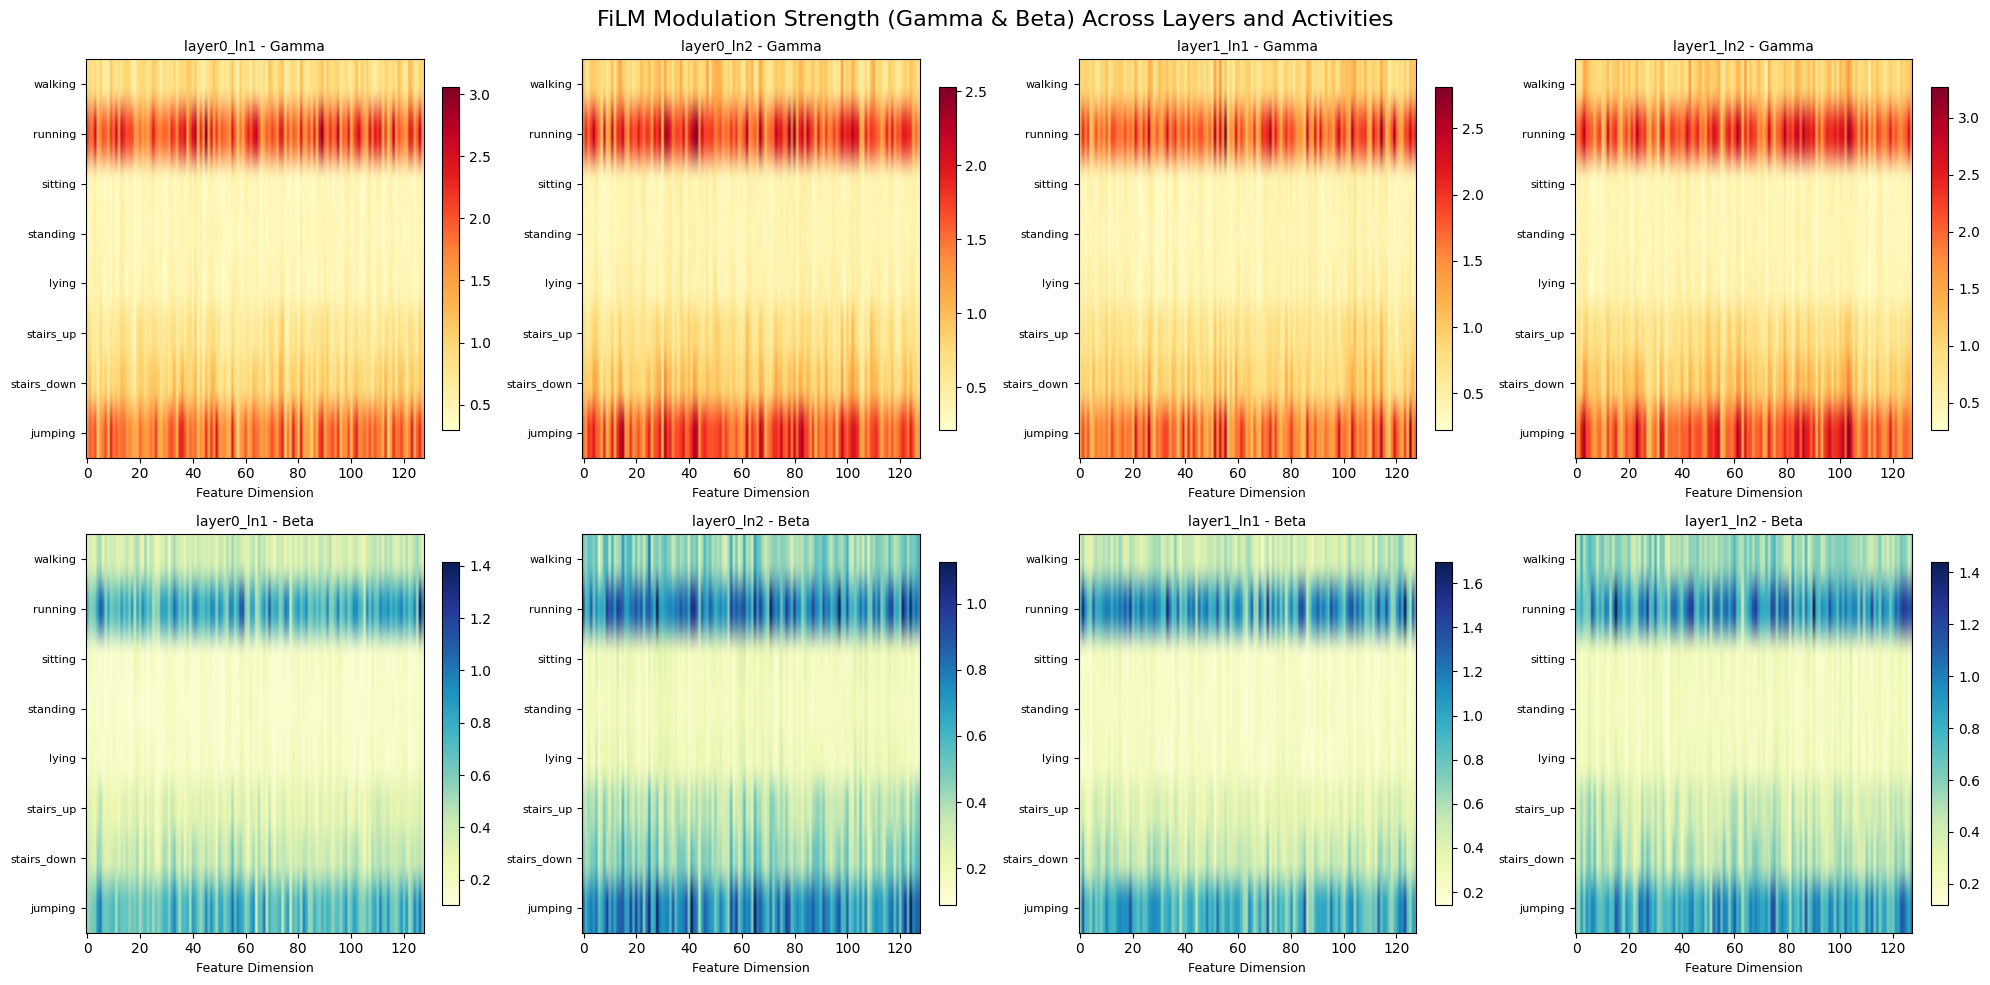

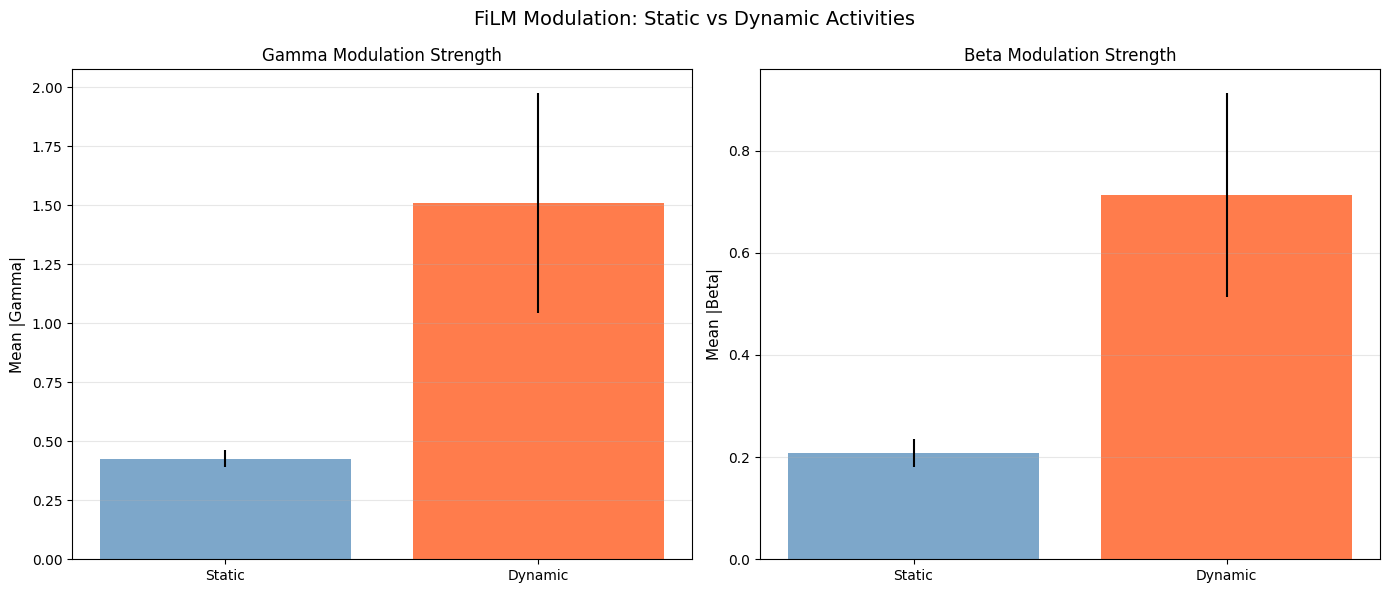

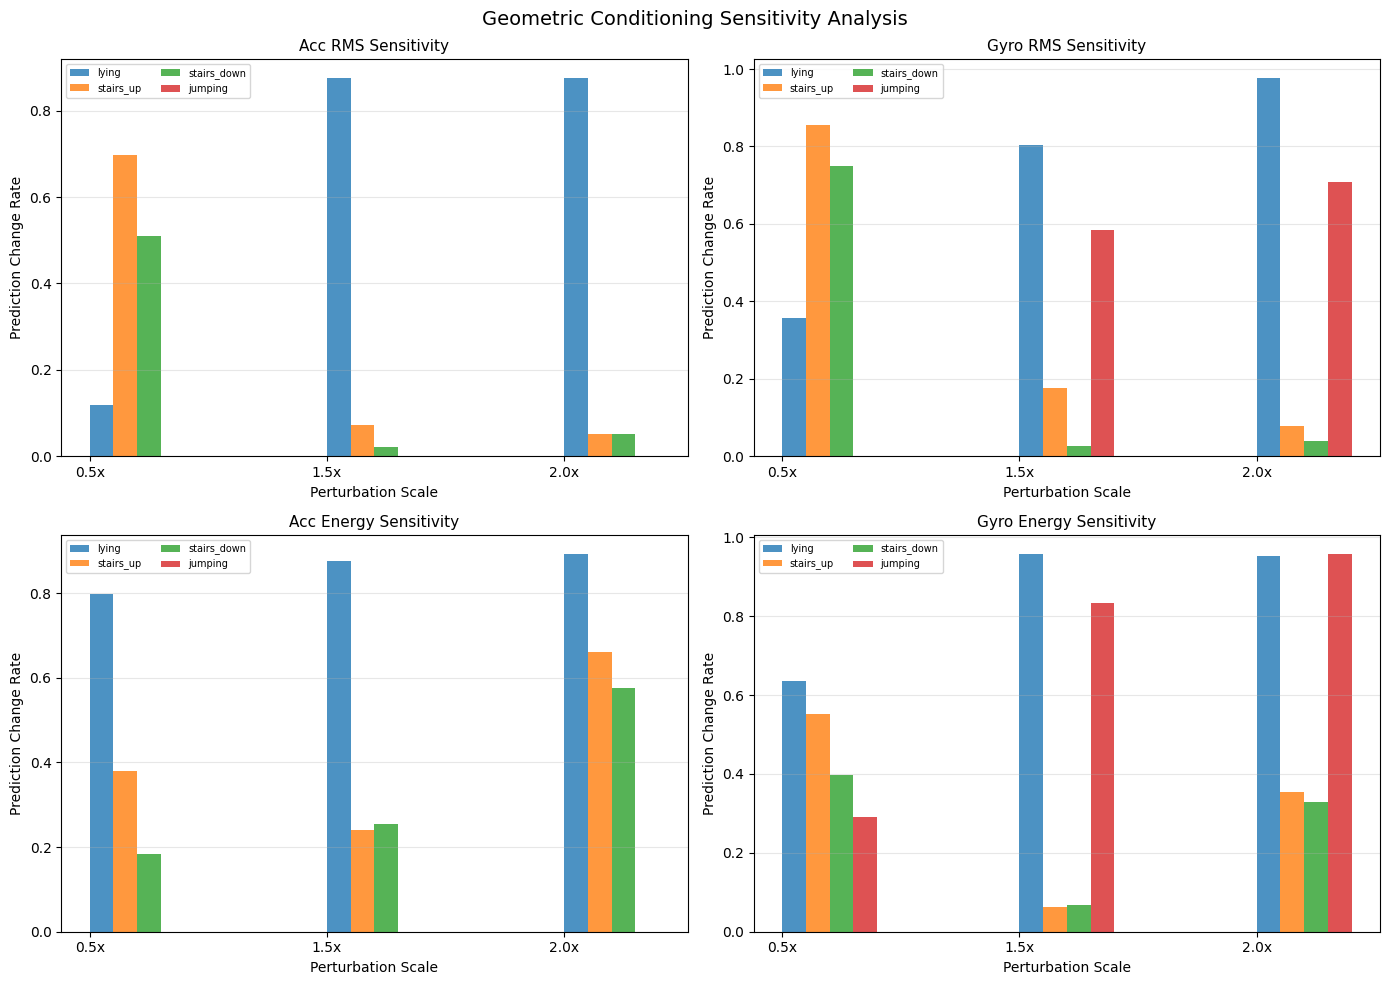

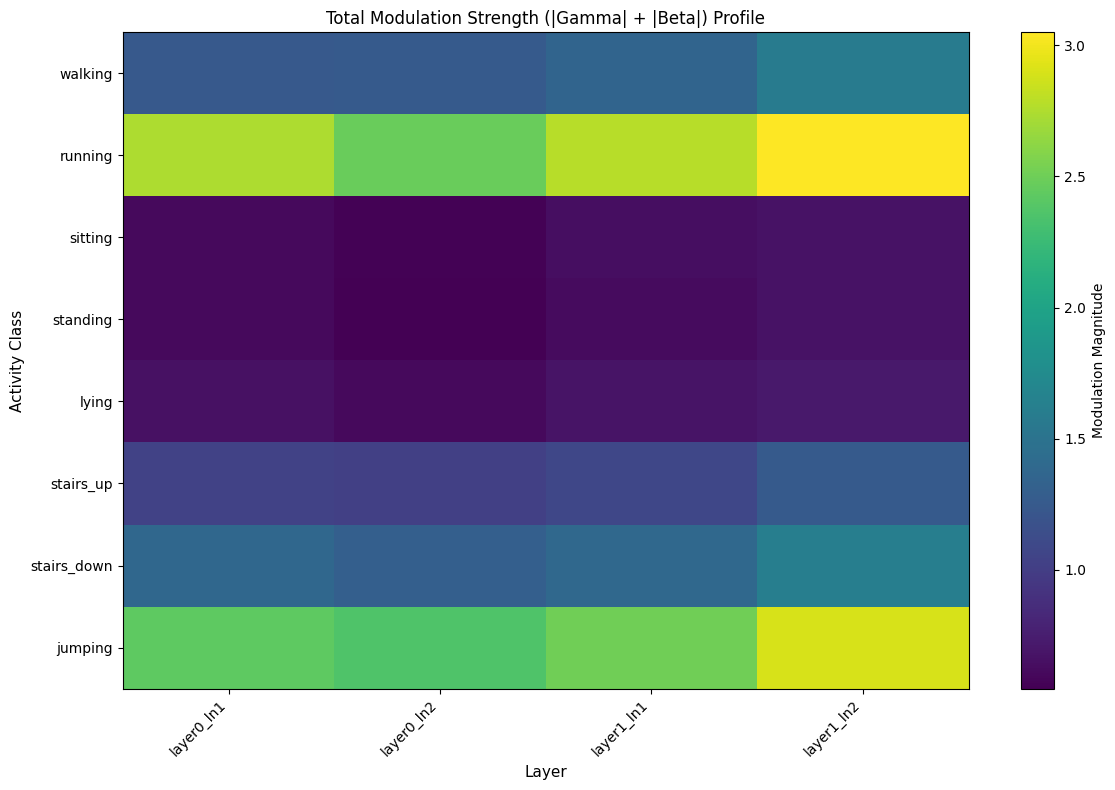


FiLM modulation analysis completed!
Figures saved to: /content/figures


In [ ]:
# ================ Step 10a: FiLM Modulation Interpretability Analysis ================

import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
from collections import defaultdict
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# Reuse classes from Step 10
BASE = Path("/content")
features_dir = BASE / "features"
configs_dir  = BASE / "configs"
logs_dir     = BASE / "logs"
fig_dir      = BASE / "figures"
models_dir   = BASE / "models"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load configuration
with open(configs_dir / 'classes.json', 'r') as f:
    classes_cfg = json.load(f)
with open(configs_dir / 'splits.json', 'r') as f:
    splits_cfg = json.load(f)

CLASS_NAMES = [classes_cfg['id_to_label'][str(i)] for i in range(classes_cfg['num_classes'])]
NUM_CLASSES = classes_cfg['num_classes']
SEQ_LEN = 8
BATCH_SIZE = 64

# Static vs dynamic activity mapping
STATIC_ACTIVITIES = ['standing', 'sitting', 'lying']
DYNAMIC_ACTIVITIES = ['walking', 'running', 'jumping']

# Hook to capture FiLM parameters
film_data = defaultdict(lambda: defaultdict(list))

def film_hook(name, layer_idx):
    def hook_fn(module, input, output):
        x, g = input
        with torch.no_grad():
            gamma = module.gamma(g).cpu().numpy()
            beta = module.beta(g).cpu().numpy()
            film_data[name][layer_idx].append({
                'gamma': gamma,
                'beta': beta
            })
    return hook_fn

# Collect data from all folds
all_modulations = defaultdict(lambda: defaultdict(lambda: {'gamma': [], 'beta': []}))
all_sensitivity = defaultdict(list)

print("Loading models and analyzing FiLM modulation across folds...")

for fold in splits_cfg['folds']:
    k = fold['fold']
    npz_path = features_dir / f'windows_normalized_fold{k}.npz'
    model_path = models_dir / f"rccmix_har_fold{k}.pt"

    if not npz_path.exists() or not model_path.exists():
        continue

    print(f"Processing fold {k}...")

    # Load model
    from torch.utils.data import Dataset

    def parse_window_id(wid: str):
        parts = wid.split(':')
        if len(parts) != 3:
            return wid, 0, 0
        return parts[0], int(parts[1]), int(parts[2])

    class SeqDataset(Dataset):
        def __init__(self, npz_path: Path, split: str, seq_len=8, seq_stride=4):
            super().__init__()
            self.npz = np.load(npz_path, allow_pickle=True)
            self.split = split
            self.seq_len = seq_len

            self.ax = self.npz['acc_x']; self.ay = self.npz['acc_y']; self.az = self.npz['acc_z']
            self.gx = self.npz['gyro_x']; self.gy = self.npz['gyro_y']; self.gz = self.npz['gyro_z']
            self.labels  = self.npz['labels'].astype(np.int64)
            self.splits  = np.array(self.npz['splits']).astype(str)
            self.win_ids = np.array(self.npz['window_ids']).astype(str)
            self.subjects= np.array(self.npz['subjects']).astype(str)

            idx_split = np.where(self.splits == split)[0]
            groups = defaultdict(list)
            for idx in idx_split:
                f, seg, st = parse_window_id(self.win_ids[idx])
                groups[(self.subjects[idx], f, seg)].append((st, idx))

            self.seq_items = []
            for key, lst in groups.items():
                lst.sort(key=lambda x: x[0])
                order = [idx for _, idx in lst]
                if len(order) < seq_len:
                    continue
                for i in range(0, len(order) - seq_len + 1, seq_stride):
                    seq_idx = order[i:i+seq_len]
                    center_idx = seq_idx[seq_len // 2]
                    label = int(self.labels[center_idx])
                    self.seq_items.append((seq_idx, center_idx, label))

        def __len__(self):
            return len(self.seq_items)

        def __getitem__(self, i):
            seq_idx, center_idx, label = self.seq_items[i]
            L = len(seq_idx); C = 6; T = self.ax.shape[1]
            X = np.zeros((L, C, T), dtype=np.float32)
            for j, idx in enumerate(seq_idx):
                X[j,0,:] = self.ax[idx]; X[j,1,:] = self.ay[idx]; X[j,2,:] = self.az[idx]
                X[j,3,:] = self.gx[idx]; X[j,4,:] = self.gy[idx]; X[j,5,:] = self.gz[idx]
            return torch.from_numpy(X), torch.tensor(label, dtype=torch.long), center_idx

    def collate_fn(batch):
        xs, ys, centers = zip(*batch)
        return torch.stack(xs), torch.stack(ys), torch.tensor(centers, dtype=torch.long)

    # Load data
    ds_test = SeqDataset(npz_path, 'test', SEQ_LEN, 4)
    loader_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=0, pin_memory=False, collate_fn=collate_fn)

    # Reconstruct model
    class DepthwiseSeparableConv1d(nn.Module):
        def __init__(self, in_ch, out_ch, k, dilation=1, dropout=0.0):
            super().__init__()
            pad = (k // 2) * dilation
            self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, padding=pad, dilation=dilation, groups=in_ch, bias=False)
            self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
            self.bn = nn.BatchNorm1d(out_ch)
            self.act = nn.GELU()
            self.drop = nn.Dropout(dropout)
        def forward(self, x):
            x = self.dw(x)
            x = self.pw(x)
            x = self.bn(x)
            x = self.act(x)
            return self.drop(x)

    class WindowEncoder(nn.Module):
        def __init__(self, in_ch=6, d_model=128, dropout=0.2):
            super().__init__()
            self.in_ch = in_ch
            self.aug_ch = in_ch + 2
            self.b1 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=9,  dilation=1, dropout=dropout)
            self.b2 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=19, dilation=2, dropout=dropout)
            self.mix = nn.Conv1d(d_model, d_model, kernel_size=1, bias=False)
            self.bn  = nn.BatchNorm1d(d_model)
            self.act = nn.GELU()
            self.drop= nn.Dropout(dropout)
            self.g_proj = nn.Sequential(
                nn.Linear(4, d_model), nn.GELU(), nn.Linear(d_model, d_model)
            )
        def forward(self, x):
            BLT, C, T = x.shape
            acc_norm = torch.sqrt((x[:,0,:]**2 + x[:,1,:]**2 + x[:,2,:]**2) + 1e-8).unsqueeze(1)
            gyr_norm = torch.sqrt((x[:,3,:]**2 + x[:,4,:]**2 + x[:,5,:]**2) + 1e-8).unsqueeze(1)
            x_aug = torch.cat([x, acc_norm, gyr_norm], dim=1)
            z = torch.cat([self.b1(x_aug), self.b2(x_aug)], dim=1)
            z = self.mix(z)
            z = self.bn(z)
            z = self.act(z)
            z = self.drop(z)
            token = z.mean(dim=-1)
            acc_rms = acc_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
            gyr_rms = gyr_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
            acc_en  = x[:,0:3,:].pow(2).mean(dim=(1,2)).sqrt()
            gyr_en  = x[:,3:6,:].pow(2).mean(dim=(1,2)).sqrt()
            g = torch.stack([acc_rms, gyr_rms, acc_en, gyr_en], dim=-1)
            g = self.g_proj(g)
            return token, g

    class CondLayerNorm(nn.Module):
        def __init__(self, d_model):
            super().__init__()
            self.ln = nn.LayerNorm(d_model)
            self.gamma = nn.Linear(d_model, d_model)
            self.beta  = nn.Linear(d_model, d_model)
        def forward(self, x, g):
            y = self.ln(x)
            return y * (1 + self.gamma(g)) + self.beta(g)

    class RCCBlock(nn.Module):
        def __init__(self, d_model=128, n_heads=4, d_ff=512, dropout=0.2):
            super().__init__()
            self.condln1 = CondLayerNorm(d_model)
            self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
            self.drop1 = nn.Dropout(dropout)
            self.condln2 = CondLayerNorm(d_model)
            self.ff = nn.Sequential(
                nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
                nn.Linear(d_ff, d_model)
            )
            self.drop2 = nn.Dropout(dropout)
        def forward(self, x, g):
            y = self.condln1(x, g)
            attn, _ = self.mha(y, y, y, need_weights=False)
            x = x + self.drop1(attn)
            y = self.condln2(x, g)
            y = self.ff(y)
            x = x + self.drop2(y)
            return x

    class GeoContextHAR(nn.Module):
        def __init__(self, in_ch=6, d_model=128, n_layers=2, n_heads=4, d_ff=512, dropout=0.2, seq_len=8, num_classes=8):
            super().__init__()
            self.seq_len = seq_len
            self.encoder = WindowEncoder(in_ch=in_ch, d_model=d_model, dropout=dropout)
            self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
            self.pos = nn.Parameter(torch.zeros(1, seq_len + 1, d_model))
            self.blocks = nn.ModuleList([RCCBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
            self.norm = nn.LayerNorm(d_model)
            self.head = nn.Linear(d_model, num_classes)
        def forward(self, x):
            B, L, C, T = x.shape
            x = x.reshape(B*L, C, T)
            token, g = self.encoder(x)
            token = token.view(B, L, -1)
            g     = g.view(B, L, -1)
            cls = self.cls_token.expand(B, -1, -1)
            z = torch.cat([cls, token], dim=1)
            g_cls = g.mean(dim=1, keepdim=True)
            g_all = torch.cat([g_cls, g], dim=1)
            z = z + self.pos
            for blk in self.blocks:
                z = blk(z, g_all)
            z = self.norm(z)
            cls = z[:, 0, :]
            logits = self.head(cls)
            return logits

    model = GeoContextHAR(in_ch=6, d_model=128, n_layers=2, n_heads=4,
                          d_ff=512, dropout=0.2, seq_len=SEQ_LEN, num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Register hooks
    hooks = []
    for layer_idx, block in enumerate(model.blocks):
        h1 = block.condln1.register_forward_hook(film_hook(f'fold{k}', f'layer{layer_idx}_ln1'))
        h2 = block.condln2.register_forward_hook(film_hook(f'fold{k}', f'layer{layer_idx}_ln2'))
        hooks.extend([h1, h2])

    # Process test data
    with torch.no_grad():
        for X, y, _ in loader_test:
            X = X.to(device)
            y_np = y.numpy()
            _ = model(X)

            # Aggregate by class
            for i, label in enumerate(y_np):
                class_name = CLASS_NAMES[label]
                for layer_key in film_data[f'fold{k}']:
                    if film_data[f'fold{k}'][layer_key]:
                        batch_data = film_data[f'fold{k}'][layer_key][-1]
                        all_modulations[class_name][layer_key]['gamma'].append(batch_data['gamma'][i])
                        all_modulations[class_name][layer_key]['beta'].append(batch_data['beta'][i])

    # Remove hooks
    for h in hooks:
        h.remove()

    # Sensitivity analysis: perturb g components
    with torch.no_grad():
        for X, y, _ in loader_test:
            X = X.to(device)
            y_np = y.numpy()

            # Get baseline predictions
            logits_base = model(X).cpu().numpy()
            preds_base = logits_base.argmax(axis=1)

            # Extract g components
            B, L, C, T = X.shape
            x_flat = X.reshape(B*L, C, T)
            acc_norm = torch.sqrt((x_flat[:,0,:]**2 + x_flat[:,1,:]**2 + x_flat[:,2,:]**2) + 1e-8).unsqueeze(1)
            gyr_norm = torch.sqrt((x_flat[:,3,:]**2 + x_flat[:,4,:]**2 + x_flat[:,5,:]**2) + 1e-8).unsqueeze(1)
            acc_rms = acc_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
            gyr_rms = gyr_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
            acc_en  = x_flat[:,0:3,:].pow(2).mean(dim=(1,2)).sqrt()
            gyr_en  = x_flat[:,3:6,:].pow(2).mean(dim=(1,2)).sqrt()

            g_components = torch.stack([acc_rms, gyr_rms, acc_en, gyr_en], dim=-1)
            g_components = g_components.view(B, L, 4)

            # Perturb each component
            for comp_idx, comp_name in enumerate(['acc_rms', 'gyro_rms', 'acc_en', 'gyro_en']):
                for scale in [0.5, 1.5, 2.0]:
                    X_mod = X.clone()
                    x_mod = X_mod.reshape(B*L, C, T)

                    if comp_idx == 0:  # acc_rms
                        scale_factor = scale / (acc_rms.mean() + 1e-8)
                        x_mod[:, 0:3, :] *= scale_factor.view(-1, 1, 1)
                    elif comp_idx == 1:  # gyro_rms
                        scale_factor = scale / (gyr_rms.mean() + 1e-8)
                        x_mod[:, 3:6, :] *= scale_factor.view(-1, 1, 1)
                    elif comp_idx == 2:  # acc_en
                        scale_factor = scale / (acc_en.mean() + 1e-8)
                        x_mod[:, 0:3, :] *= scale_factor.view(-1, 1, 1)
                    else:  # gyro_en
                        scale_factor = scale / (gyr_en.mean() + 1e-8)
                        x_mod[:, 3:6, :] *= scale_factor.view(-1, 1, 1)

                    X_mod = x_mod.view(B, L, C, T)
                    logits_mod = model(X_mod).cpu().numpy()
                    preds_mod = logits_mod.argmax(axis=1)

                    # Record changes
                    for i, (label, pred_base, pred_mod) in enumerate(zip(y_np, preds_base, preds_mod)):
                        all_sensitivity[CLASS_NAMES[label]].append({
                            'component': comp_name,
                            'scale': scale,
                            'changed': int(pred_base != pred_mod),
                            'conf_delta': logits_mod[i].max() - logits_base[i].max()
                        })

            break  # Only one batch for sensitivity

    film_data.clear()

print(f"\nAnalysis complete. Generating visualizations...")

# ========== Visualization 1: Modulation Strength Heatmap ==========
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('FiLM Modulation Strength (Gamma & Beta) Across Layers and Activities', fontsize=16)

layer_names = ['layer0_ln1', 'layer0_ln2', 'layer1_ln1', 'layer1_ln2']

for idx, layer in enumerate(layer_names):
    ax_gamma = axes[0, idx]
    ax_beta = axes[1, idx]

    # Compute mean absolute values per class
    gamma_means = []
    beta_means = []

    for class_name in CLASS_NAMES:
        if layer in all_modulations[class_name]:
            gamma_data = all_modulations[class_name][layer]['gamma']
            beta_data = all_modulations[class_name][layer]['beta']

            if gamma_data:
                gamma_means.append(np.abs(np.concatenate(gamma_data, axis=0)).mean(axis=0))
                beta_means.append(np.abs(np.concatenate(beta_data, axis=0)).mean(axis=0))
            else:
                gamma_means.append(np.zeros(128))
                beta_means.append(np.zeros(128))
        else:
            gamma_means.append(np.zeros(128))
            beta_means.append(np.zeros(128))

    # Plot heatmaps
    im1 = ax_gamma.imshow(gamma_means, aspect='auto', cmap='YlOrRd')
    ax_gamma.set_yticks(range(len(CLASS_NAMES)))
    ax_gamma.set_yticklabels(CLASS_NAMES, fontsize=8)
    ax_gamma.set_xlabel('Feature Dimension', fontsize=9)
    ax_gamma.set_title(f'{layer} - Gamma', fontsize=10)
    plt.colorbar(im1, ax=ax_gamma, fraction=0.046)

    im2 = ax_beta.imshow(beta_means, aspect='auto', cmap='YlGnBu')
    ax_beta.set_yticks(range(len(CLASS_NAMES)))
    ax_beta.set_yticklabels(CLASS_NAMES, fontsize=8)
    ax_beta.set_xlabel('Feature Dimension', fontsize=9)
    ax_beta.set_title(f'{layer} - Beta', fontsize=10)
    plt.colorbar(im2, ax=ax_beta, fraction=0.046)

plt.tight_layout()
plt.savefig(fig_dir / 'step10a_film_modulation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 2: Static vs Dynamic Activity Comparison ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('FiLM Modulation: Static vs Dynamic Activities', fontsize=14)

static_gamma = []
static_beta = []
dynamic_gamma = []
dynamic_beta = []

for class_name in CLASS_NAMES:
    for layer in layer_names:
        if layer in all_modulations[class_name]:
            gamma_data = all_modulations[class_name][layer]['gamma']
            beta_data = all_modulations[class_name][layer]['beta']

            if gamma_data:
                gamma_val = np.abs(np.concatenate(gamma_data, axis=0)).mean()
                beta_val = np.abs(np.concatenate(beta_data, axis=0)).mean()

                if any(s in class_name.lower() for s in STATIC_ACTIVITIES):
                    static_gamma.append(gamma_val)
                    static_beta.append(beta_val)
                elif any(d in class_name.lower() for d in DYNAMIC_ACTIVITIES):
                    dynamic_gamma.append(gamma_val)
                    dynamic_beta.append(beta_val)

axes[0].bar(['Static', 'Dynamic'],
           [np.mean(static_gamma) if static_gamma else 0,
            np.mean(dynamic_gamma) if dynamic_gamma else 0],
           color=['steelblue', 'orangered'], alpha=0.7, yerr=[np.std(static_gamma) if static_gamma else 0,
                                                                np.std(dynamic_gamma) if dynamic_gamma else 0])
axes[0].set_ylabel('Mean |Gamma|', fontsize=11)
axes[0].set_title('Gamma Modulation Strength', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(['Static', 'Dynamic'],
           [np.mean(static_beta) if static_beta else 0,
            np.mean(dynamic_beta) if dynamic_beta else 0],
           color=['steelblue', 'orangered'], alpha=0.7, yerr=[np.std(static_beta) if static_beta else 0,
                                                               np.std(dynamic_beta) if static_beta else 0])
axes[1].set_ylabel('Mean |Beta|', fontsize=11)
axes[1].set_title('Beta Modulation Strength', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(fig_dir / 'step10a_static_vs_dynamic.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 3: Sensitivity Analysis ==========
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Geometric Conditioning Sensitivity Analysis', fontsize=14)

components = ['acc_rms', 'gyro_rms', 'acc_en', 'gyro_en']
component_titles = ['Acc RMS', 'Gyro RMS', 'Acc Energy', 'Gyro Energy']

for idx, (comp, title) in enumerate(zip(components, component_titles)):
    ax = axes[idx // 2, idx % 2]

    sens_data = defaultdict(lambda: defaultdict(list))

    for class_name in CLASS_NAMES:
        if class_name in all_sensitivity:
            for record in all_sensitivity[class_name]:
                if record['component'] == comp:
                    sens_data[class_name][record['scale']].append(record['changed'])

    scales = [0.5, 1.5, 2.0]
    x = np.arange(len(scales))
    width = 0.1

    for i, class_name in enumerate(CLASS_NAMES):
        if class_name in sens_data:
            change_rates = [np.mean(sens_data[class_name][s]) if s in sens_data[class_name] else 0
                          for s in scales]
            ax.bar(x + i * width, change_rates, width, label=class_name, alpha=0.8)

    ax.set_xlabel('Perturbation Scale', fontsize=10)
    ax.set_ylabel('Prediction Change Rate', fontsize=10)
    ax.set_title(f'{title} Sensitivity', fontsize=11)
    ax.set_xticks(x + width * (len(CLASS_NAMES) - 1) / 2)
    ax.set_xticklabels([f'{s}x' for s in scales])
    ax.legend(fontsize=7, ncol=2, loc='upper left')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(fig_dir / 'step10a_sensitivity_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 4: Per-Activity Modulation Profile ==========
fig, ax = plt.subplots(figsize=(12, 8))

modulation_profiles = defaultdict(list)

for class_name in CLASS_NAMES:
    for layer in layer_names:
        if layer in all_modulations[class_name]:
            gamma_data = all_modulations[class_name][layer]['gamma']
            beta_data = all_modulations[class_name][layer]['beta']

            if gamma_data and beta_data:
                gamma_mean = np.abs(np.concatenate(gamma_data, axis=0)).mean()
                beta_mean = np.abs(np.concatenate(beta_data, axis=0)).mean()
                modulation_profiles[class_name].append(gamma_mean + beta_mean)

profile_matrix = []
for class_name in CLASS_NAMES:
    if class_name in modulation_profiles:
        profile_matrix.append(modulation_profiles[class_name])
    else:
        profile_matrix.append([0] * len(layer_names))

im = ax.imshow(profile_matrix, aspect='auto', cmap='viridis')
ax.set_yticks(range(len(CLASS_NAMES)))
ax.set_yticklabels(CLASS_NAMES, fontsize=10)
ax.set_xticks(range(len(layer_names)))
ax.set_xticklabels(layer_names, fontsize=10, rotation=45, ha='right')
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Activity Class', fontsize=11)
ax.set_title('Total Modulation Strength (|Gamma| + |Beta|) Profile', fontsize=12)
plt.colorbar(im, ax=ax, label='Modulation Magnitude')

plt.tight_layout()
plt.savefig(fig_dir / 'step10a_activity_modulation_profile.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFiLM modulation analysis completed!")
print(f"Figures saved to: {fig_dir}")

Analyzing rotation invariance across all folds...
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
Processing fold 11...
Processing fold 12...
Processing fold 13...
Processing fold 14...

Generating visualizations...


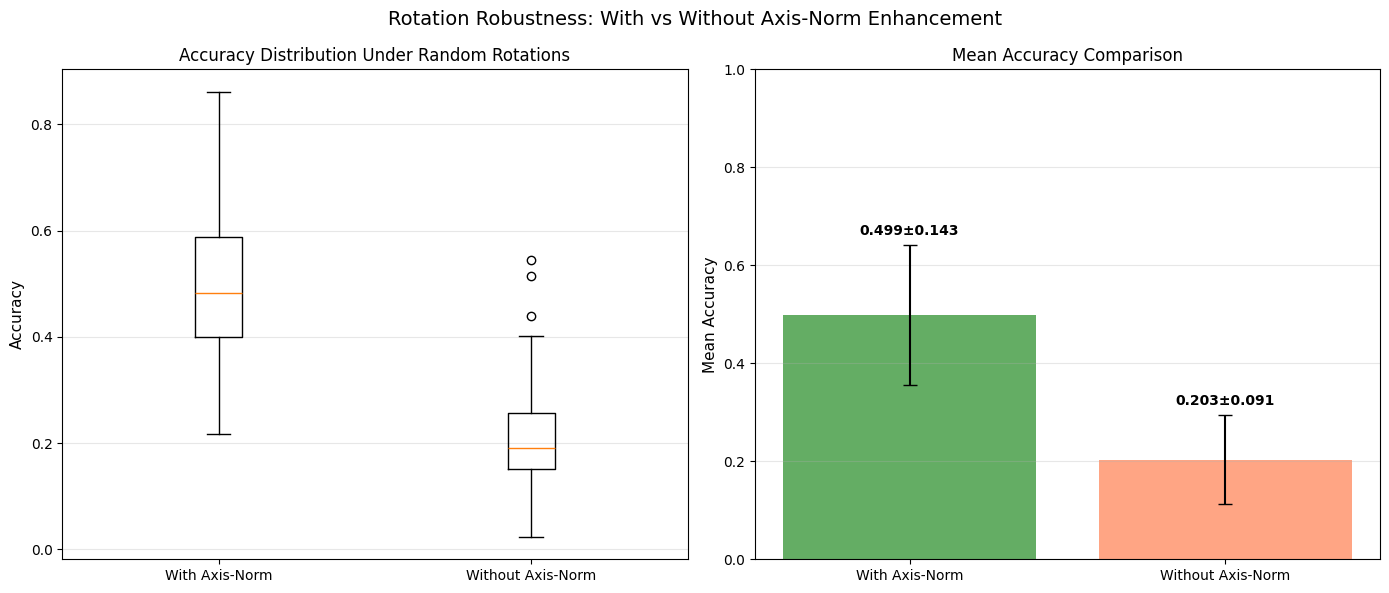

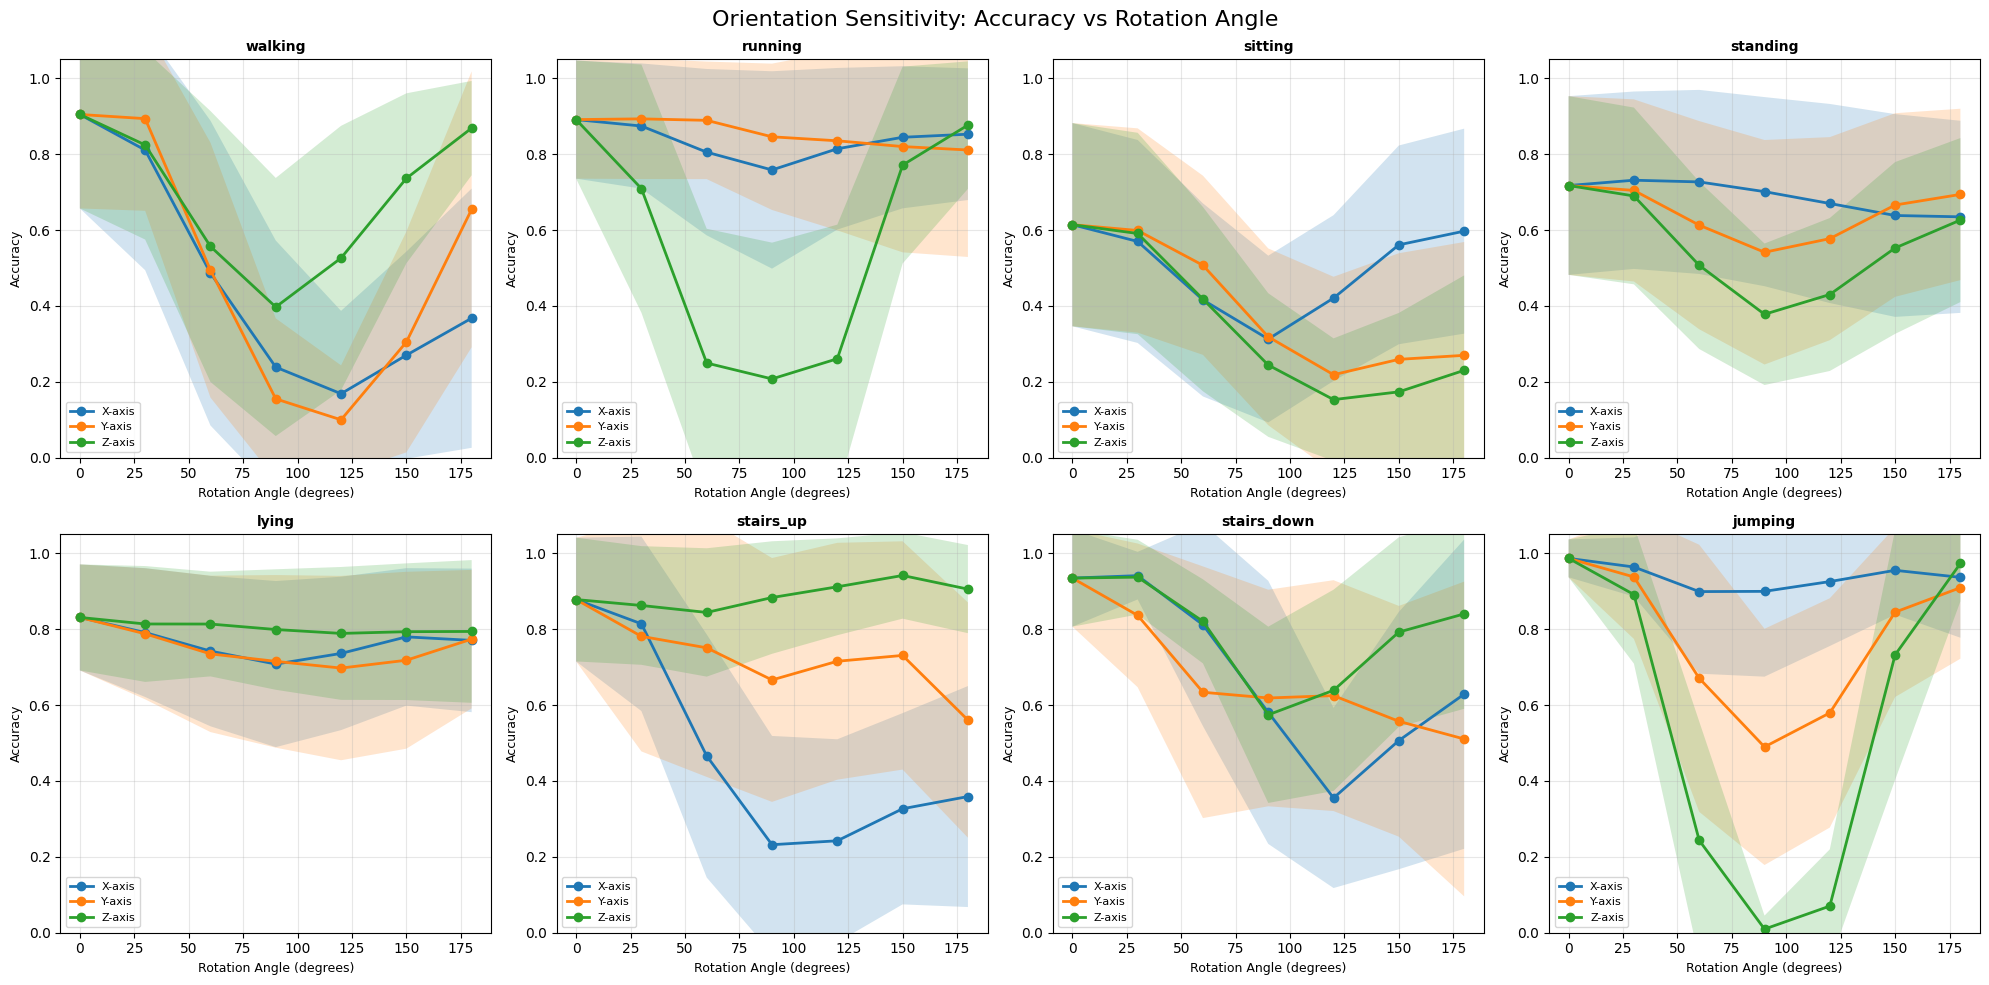

Computing t-SNE embedding...


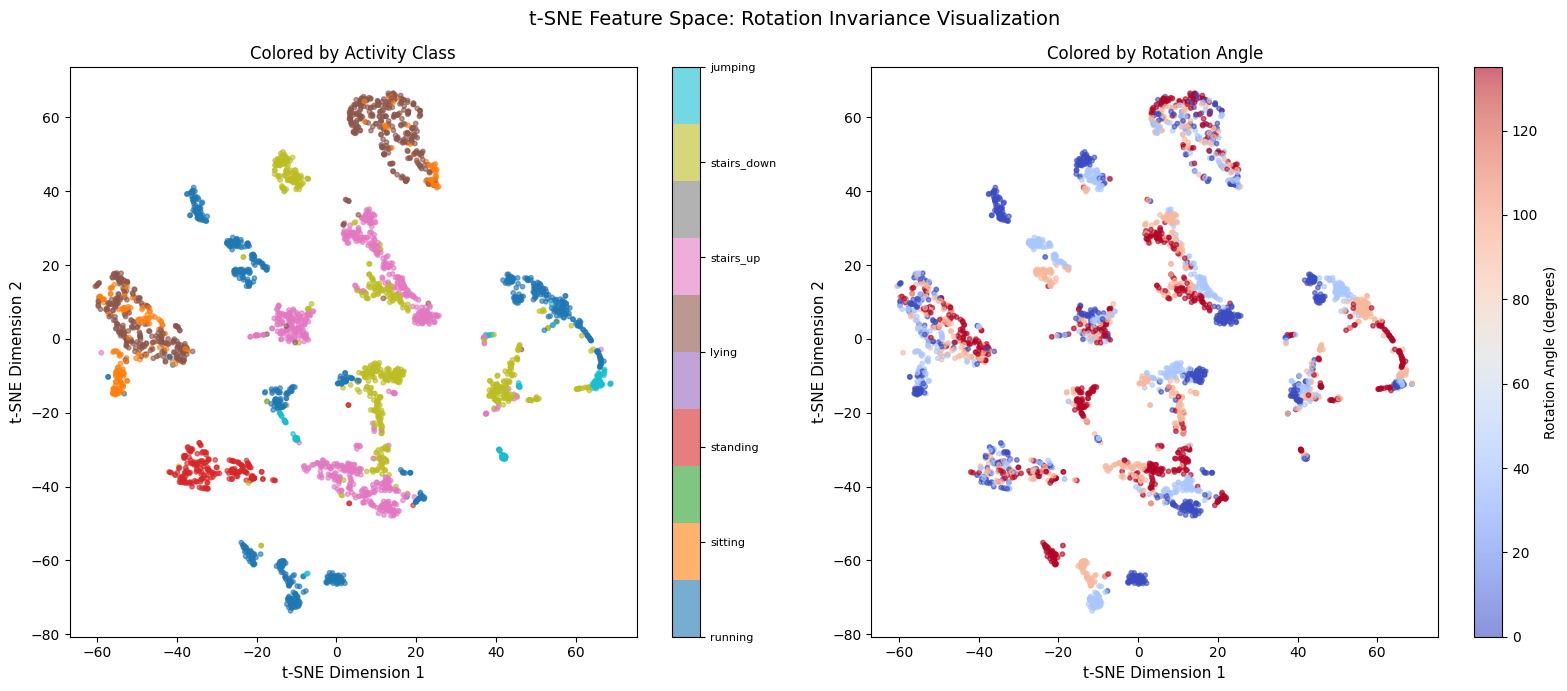

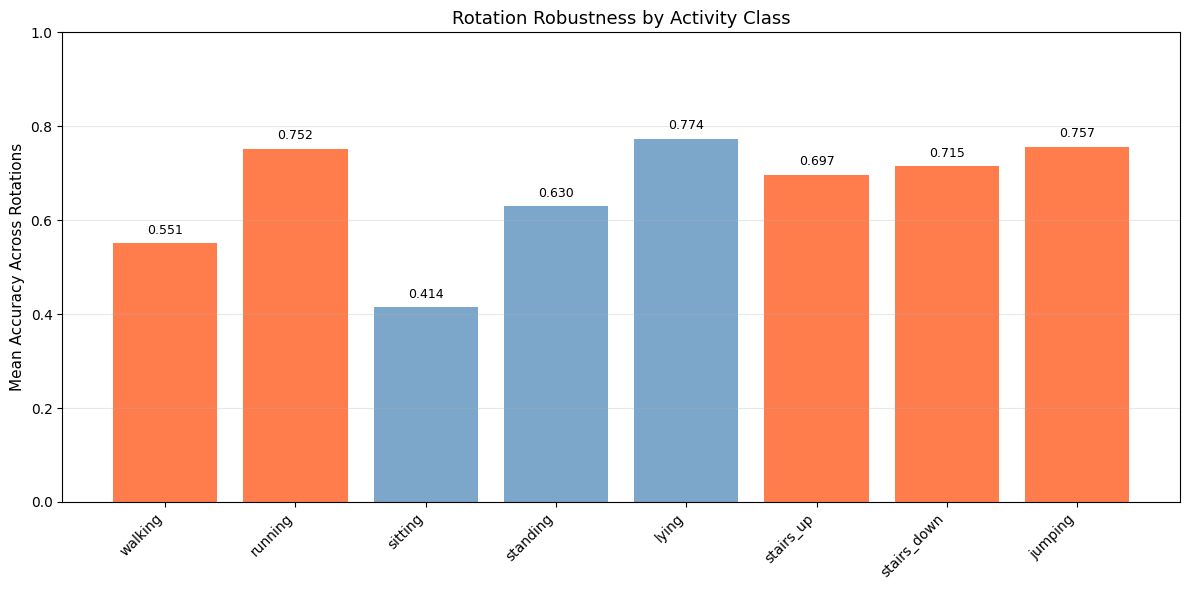


Rotation invariance analysis completed!
Figures saved to: /content/figures

Summary:
  Mean accuracy with axis-norm: 0.4988 ± 0.1430
  Mean accuracy without axis-norm: 0.2034 ± 0.0907
  Improvement: 0.2955


In [ ]:
# ================ Step 10b: Rotation Invariance Verification ================

import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
from collections import defaultdict
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score
from scipy.spatial.transform import Rotation as R

BASE = Path("/content")
features_dir = BASE / "features"
configs_dir  = BASE / "configs"
logs_dir     = BASE / "logs"
fig_dir      = BASE / "figures"
models_dir   = BASE / "models"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(configs_dir / 'classes.json', 'r') as f:
    classes_cfg = json.load(f)
with open(configs_dir / 'splits.json', 'r') as f:
    splits_cfg = json.load(f)

CLASS_NAMES = [classes_cfg['id_to_label'][str(i)] for i in range(classes_cfg['num_classes'])]
NUM_CLASSES = classes_cfg['num_classes']
SEQ_LEN = 8
BATCH_SIZE = 64

def random_rotation_matrix():
    return R.random().as_matrix().astype(np.float32)

def apply_rotation_to_batch(X, rot_matrix):
    B, L, C, T = X.shape
    X_rot = X.clone()
    X_flat = X_rot.view(B * L, C, T)

    rot_tensor = torch.from_numpy(rot_matrix).to(X.device)

    for i in range(B * L):
        acc = X_flat[i, 0:3, :].t()
        gyro = X_flat[i, 3:6, :].t()

        acc_rot = torch.mm(acc, rot_tensor.t())
        gyro_rot = torch.mm(gyro, rot_tensor.t())

        X_flat[i, 0:3, :] = acc_rot.t()
        X_flat[i, 3:6, :] = gyro_rot.t()

    return X_rot.view(B, L, C, T)

class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation=1, dropout=0.0):
        super().__init__()
        pad = (k // 2) * dilation
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, padding=pad, dilation=dilation, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.bn(x)
        x = self.act(x)
        return self.drop(x)

class WindowEncoder(nn.Module):
    def __init__(self, in_ch=6, d_model=128, dropout=0.2):
        super().__init__()
        self.in_ch = in_ch
        self.aug_ch = in_ch + 2
        self.b1 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=9, dilation=1, dropout=dropout)
        self.b2 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=19, dilation=2, dropout=dropout)
        self.mix = nn.Conv1d(d_model, d_model, kernel_size=1, bias=False)
        self.bn  = nn.BatchNorm1d(d_model)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
        self.g_proj = nn.Sequential(
            nn.Linear(4, d_model), nn.GELU(), nn.Linear(d_model, d_model)
        )
    def forward(self, x, disable_norm=False):
        BLT, C, T = x.shape
        if disable_norm:
            acc_norm = torch.ones(BLT, 1, T, device=x.device) * 0.5
            gyr_norm = torch.ones(BLT, 1, T, device=x.device) * 0.5
        else:
            acc_norm = torch.sqrt((x[:,0,:]**2 + x[:,1,:]**2 + x[:,2,:]**2) + 1e-8).unsqueeze(1)
            gyr_norm = torch.sqrt((x[:,3,:]**2 + x[:,4,:]**2 + x[:,5,:]**2) + 1e-8).unsqueeze(1)

        x_aug = torch.cat([x, acc_norm, gyr_norm], dim=1)
        z = torch.cat([self.b1(x_aug), self.b2(x_aug)], dim=1)
        z = self.mix(z)
        z = self.bn(z)
        z = self.act(z)
        z = self.drop(z)
        token = z.mean(dim=-1)
        acc_rms = acc_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        gyr_rms = gyr_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        acc_en  = x[:,0:3,:].pow(2).mean(dim=(1,2)).sqrt()
        gyr_en  = x[:,3:6,:].pow(2).mean(dim=(1,2)).sqrt()
        g = torch.stack([acc_rms, gyr_rms, acc_en, gyr_en], dim=-1)
        g = self.g_proj(g)
        return token, g

class CondLayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.gamma = nn.Linear(d_model, d_model)
        self.beta  = nn.Linear(d_model, d_model)
    def forward(self, x, g):
        y = self.ln(x)
        return y * (1 + self.gamma(g)) + self.beta(g)

class RCCBlock(nn.Module):
    def __init__(self, d_model=128, n_heads=4, d_ff=512, dropout=0.2):
        super().__init__()
        self.condln1 = CondLayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.condln2 = CondLayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.drop2 = nn.Dropout(dropout)
    def forward(self, x, g):
        y = self.condln1(x, g)
        attn, _ = self.mha(y, y, y, need_weights=False)
        x = x + self.drop1(attn)
        y = self.condln2(x, g)
        y = self.ff(y)
        x = x + self.drop2(y)
        return x

class GeoContextHAR(nn.Module):
    def __init__(self, in_ch=6, d_model=128, n_layers=2, n_heads=4, d_ff=512, dropout=0.2, seq_len=8, num_classes=8):
        super().__init__()
        self.seq_len = seq_len
        self.encoder = WindowEncoder(in_ch=in_ch, d_model=d_model, dropout=dropout)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos = nn.Parameter(torch.zeros(1, seq_len + 1, d_model))
        self.blocks = nn.ModuleList([RCCBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x, return_features=False, disable_norm=False):
        B, L, C, T = x.shape
        x = x.reshape(B*L, C, T)
        token, g = self.encoder(x, disable_norm=disable_norm)
        token = token.view(B, L, -1)
        g = g.view(B, L, -1)
        cls = self.cls_token.expand(B, -1, -1)
        z = torch.cat([cls, token], dim=1)
        g_cls = g.mean(dim=1, keepdim=True)
        g_all = torch.cat([g_cls, g], dim=1)
        z = z + self.pos
        for blk in self.blocks:
            z = blk(z, g_all)
        z = self.norm(z)
        cls = z[:, 0, :]
        if return_features:
            return cls
        logits = self.head(cls)
        return logits

def parse_window_id(wid: str):
    parts = wid.split(':')
    if len(parts) != 3:
        return wid, 0, 0
    return parts[0], int(parts[1]), int(parts[2])

class SeqDataset(Dataset):
    def __init__(self, npz_path: Path, split: str, seq_len=8, seq_stride=4):
        super().__init__()
        self.npz = np.load(npz_path, allow_pickle=True)
        self.split = split
        self.seq_len = seq_len

        self.ax = self.npz['acc_x']; self.ay = self.npz['acc_y']; self.az = self.npz['acc_z']
        self.gx = self.npz['gyro_x']; self.gy = self.npz['gyro_y']; self.gz = self.npz['gyro_z']
        self.labels  = self.npz['labels'].astype(np.int64)
        self.splits  = np.array(self.npz['splits']).astype(str)
        self.win_ids = np.array(self.npz['window_ids']).astype(str)
        self.subjects= np.array(self.npz['subjects']).astype(str)

        idx_split = np.where(self.splits == split)[0]
        groups = defaultdict(list)
        for idx in idx_split:
            f, seg, st = parse_window_id(self.win_ids[idx])
            groups[(self.subjects[idx], f, seg)].append((st, idx))

        self.seq_items = []
        for key, lst in groups.items():
            lst.sort(key=lambda x: x[0])
            order = [idx for _, idx in lst]
            if len(order) < seq_len:
                continue
            for i in range(0, len(order) - seq_len + 1, seq_stride):
                seq_idx = order[i:i+seq_len]
                center_idx = seq_idx[seq_len // 2]
                label = int(self.labels[center_idx])
                self.seq_items.append((seq_idx, center_idx, label))

    def __len__(self):
        return len(self.seq_items)

    def __getitem__(self, i):
        seq_idx, center_idx, label = self.seq_items[i]
        L = len(seq_idx); C = 6; T = self.ax.shape[1]
        X = np.zeros((L, C, T), dtype=np.float32)
        for j, idx in enumerate(seq_idx):
            X[j,0,:] = self.ax[idx]; X[j,1,:] = self.ay[idx]; X[j,2,:] = self.az[idx]
            X[j,3,:] = self.gx[idx]; X[j,4,:] = self.gy[idx]; X[j,5,:] = self.gz[idx]
        return torch.from_numpy(X), torch.tensor(label, dtype=torch.long), center_idx

def collate_fn(batch):
    xs, ys, centers = zip(*batch)
    return torch.stack(xs), torch.stack(ys), torch.tensor(centers, dtype=torch.long)

rotation_results = defaultdict(lambda: defaultdict(list))
orientation_results = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
feature_data = {'features': [], 'labels': [], 'rotations': [], 'activities': []}

print("Analyzing rotation invariance across all folds...")

rotation_angles = [0, 30, 60, 90, 120, 150, 180]

for fold in splits_cfg['folds']:
    k = fold['fold']
    npz_path = features_dir / f'windows_normalized_fold{k}.npz'
    model_path = models_dir / f"rccmix_har_fold{k}.pt"

    if not npz_path.exists() or not model_path.exists():
        continue

    print(f"Processing fold {k}...")

    ds_test = SeqDataset(npz_path, 'test', SEQ_LEN, 4)
    loader_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=0, pin_memory=False, collate_fn=collate_fn)

    model = GeoContextHAR(in_ch=6, d_model=128, n_layers=2, n_heads=4,
                          d_ff=512, dropout=0.2, seq_len=SEQ_LEN,
                          num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    with torch.no_grad():
        # Test 1: Random rotation with/without norm
        for n_rot in range(10):
            rot_mat = random_rotation_matrix()

            all_preds_norm = []
            all_preds_no_norm = []
            all_labels = []

            for X, y, _ in loader_test:
                X_orig = X.to(device)
                X_rot = apply_rotation_to_batch(X_orig, rot_mat)

                preds_norm = model(X_rot, disable_norm=False).argmax(dim=1).cpu().numpy()
                preds_no_norm = model(X_rot, disable_norm=True).argmax(dim=1).cpu().numpy()

                all_preds_norm.extend(preds_norm)
                all_preds_no_norm.extend(preds_no_norm)
                all_labels.extend(y.numpy())

            acc_norm = accuracy_score(all_labels, all_preds_norm)
            acc_no_norm = accuracy_score(all_labels, all_preds_no_norm)

            rotation_results['with_norm']['accuracy'].append(acc_norm)
            rotation_results['no_norm']['accuracy'].append(acc_no_norm)

        # Test 2: Orientation sensitivity
        for angle_deg in rotation_angles:
            angle_rad = np.radians(angle_deg)

            rot_z = R.from_euler('z', angle_rad).as_matrix().astype(np.float32)
            rot_x = R.from_euler('x', angle_rad).as_matrix().astype(np.float32)
            rot_y = R.from_euler('y', angle_rad).as_matrix().astype(np.float32)

            for axis_name, rot_mat in [('z', rot_z), ('x', rot_x), ('y', rot_y)]:
                class_preds = defaultdict(list)

                for X, y, _ in loader_test:
                    X_orig = X.to(device)
                    X_rot = apply_rotation_to_batch(X_orig, rot_mat)

                    preds = model(X_rot).argmax(dim=1).cpu().numpy()
                    labels = y.numpy()

                    for pred, label in zip(preds, labels):
                        class_name = CLASS_NAMES[label]
                        class_preds[class_name].append(pred == label)

                for class_name in CLASS_NAMES:
                    if class_name in class_preds and class_preds[class_name]:
                        acc = np.mean(class_preds[class_name])
                        orientation_results[class_name][axis_name][angle_deg].append(acc)

        # Test 3: Feature extraction
        if k <= 2:
            for angle_deg in [0, 45, 90, 135]:
                angle_rad = np.radians(angle_deg)
                rot_mat = R.from_euler('xyz', [angle_rad, angle_rad/2, angle_rad/3]).as_matrix().astype(np.float32)

                sample_count = 0
                for X, y, _ in loader_test:
                    X_orig = X.to(device)
                    if angle_deg == 0:
                        X_rot = X_orig
                    else:
                        X_rot = apply_rotation_to_batch(X_orig, rot_mat)

                    features = model(X_rot, return_features=True).cpu().numpy()
                    labels = y.numpy()

                    feature_data['features'].append(features)
                    feature_data['labels'].append(labels)
                    feature_data['rotations'].append(np.full(len(labels), angle_deg))
                    feature_data['activities'].append(labels)

                    sample_count += len(labels)
                    if sample_count >= 200:
                        break

print("\nGenerating visualizations...")

# ========== Visualization 1: Rotation Robustness ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Rotation Robustness: With vs Without Axis-Norm Enhancement', fontsize=14)

acc_norm = rotation_results['with_norm']['accuracy']
acc_no_norm = rotation_results['no_norm']['accuracy']

axes[0].boxplot([acc_norm, acc_no_norm], labels=['With Axis-Norm', 'Without Axis-Norm'])
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Accuracy Distribution Under Random Rotations', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

mean_norm = np.mean(acc_norm)
mean_no_norm = np.mean(acc_no_norm)
std_norm = np.std(acc_norm)
std_no_norm = np.std(acc_no_norm)

axes[1].bar(['With Axis-Norm', 'Without Axis-Norm'],
           [mean_norm, mean_no_norm],
           yerr=[std_norm, std_no_norm],
           color=['forestgreen', 'coral'], alpha=0.7, capsize=5)
axes[1].set_ylabel('Mean Accuracy', fontsize=11)
axes[1].set_title('Mean Accuracy Comparison', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for i, (mean, std) in enumerate([(mean_norm, std_norm), (mean_no_norm, std_no_norm)]):
    axes[1].text(i, mean + std + 0.02, f'{mean:.3f}±{std:.3f}',
                ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(fig_dir / 'step10b_rotation_robustness.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 2: Orientation Sensitivity ==========
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Orientation Sensitivity: Accuracy vs Rotation Angle', fontsize=16)
axes = axes.flatten()

for idx, class_name in enumerate(CLASS_NAMES):
    ax = axes[idx]

    for axis_name in ['x', 'y', 'z']:
        angles = []
        accs_mean = []
        accs_std = []

        for angle in rotation_angles:
            if angle in orientation_results[class_name][axis_name]:
                acc_list = orientation_results[class_name][axis_name][angle]
                if acc_list:
                    angles.append(angle)
                    accs_mean.append(np.mean(acc_list))
                    accs_std.append(np.std(acc_list))

        if angles:
            ax.plot(angles, accs_mean, marker='o', label=f'{axis_name.upper()}-axis', linewidth=2)
            ax.fill_between(angles,
                          np.array(accs_mean) - np.array(accs_std),
                          np.array(accs_mean) + np.array(accs_std),
                          alpha=0.2)

    ax.set_xlabel('Rotation Angle (degrees)', fontsize=9)
    ax.set_ylabel('Accuracy', fontsize=9)
    ax.set_title(class_name, fontsize=10, fontweight='bold')
    ax.set_ylim([0, 1.05])
    ax.legend(fontsize=8, loc='lower left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_dir / 'step10b_orientation_sensitivity.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 3: t-SNE Feature Space ==========
if feature_data['features']:
    all_features = np.concatenate(feature_data['features'], axis=0)
    all_labels = np.concatenate(feature_data['labels'], axis=0)
    all_rotations = np.concatenate(feature_data['rotations'], axis=0)

    n_samples = min(3000, len(all_features))
    sample_idx = np.random.choice(len(all_features), n_samples, replace=False)

    features_sample = all_features[sample_idx]
    labels_sample = all_labels[sample_idx]
    rotations_sample = all_rotations[sample_idx]

    print("Computing t-SNE embedding...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    features_2d = tsne.fit_transform(features_sample)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle('t-SNE Feature Space: Rotation Invariance Visualization', fontsize=14)

    scatter1 = axes[0].scatter(features_2d[:, 0], features_2d[:, 1],
                              c=labels_sample, cmap='tab10', s=10, alpha=0.6)
    axes[0].set_xlabel('t-SNE Dimension 1', fontsize=11)
    axes[0].set_ylabel('t-SNE Dimension 2', fontsize=11)
    axes[0].set_title('Colored by Activity Class', fontsize=12)
    cbar1 = plt.colorbar(scatter1, ax=axes[0], ticks=range(NUM_CLASSES))
    cbar1.set_ticklabels([CLASS_NAMES[i][:12] for i in range(NUM_CLASSES)])
    cbar1.ax.tick_params(labelsize=8)

    scatter2 = axes[1].scatter(features_2d[:, 0], features_2d[:, 1],
                              c=rotations_sample, cmap='coolwarm', s=10, alpha=0.6)
    axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11)
    axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11)
    axes[1].set_title('Colored by Rotation Angle', fontsize=12)
    cbar2 = plt.colorbar(scatter2, ax=axes[1])
    cbar2.set_label('Rotation Angle (degrees)', fontsize=10)

    plt.tight_layout()
    plt.savefig(fig_dir / 'step10b_tsne_features.png', dpi=150, bbox_inches='tight')
    plt.show()

# ========== Visualization 4: Activity Robustness ==========
fig, ax = plt.subplots(figsize=(12, 6))

activity_robustness = []
activity_names = []

for class_name in CLASS_NAMES:
    all_accs = []
    for axis_name in ['x', 'y', 'z']:
        for angle in rotation_angles:
            if angle in orientation_results[class_name][axis_name]:
                all_accs.extend(orientation_results[class_name][axis_name][angle])

    if all_accs:
        activity_robustness.append(np.mean(all_accs))
        activity_names.append(class_name)

if activity_robustness:
    colors = ['steelblue' if any(s in name.lower() for s in ['sitting', 'standing', 'lying'])
              else 'orangered' for name in activity_names]

    bars = ax.bar(range(len(activity_names)), activity_robustness, color=colors, alpha=0.7)
    ax.set_xticks(range(len(activity_names)))
    ax.set_xticklabels(activity_names, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel('Mean Accuracy Across Rotations', fontsize=11)
    ax.set_title('Rotation Robustness by Activity Class', fontsize=13)
    ax.set_ylim([0, 1])
    ax.grid(axis='y', alpha=0.3)

    for bar, acc in zip(bars, activity_robustness):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
               f'{acc:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig(fig_dir / 'step10b_activity_robustness.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nRotation invariance analysis completed!")
print(f"Figures saved to: {fig_dir}")
print(f"\nSummary:")
print(f"  Mean accuracy with axis-norm: {np.mean(acc_norm):.4f} ± {np.std(acc_norm):.4f}")
print(f"  Mean accuracy without axis-norm: {np.mean(acc_no_norm):.4f} ± {np.std(acc_no_norm):.4f}")
print(f"  Improvement: {(np.mean(acc_norm) - np.mean(acc_no_norm)):.4f}")

Analyzing attention patterns across all folds...
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
Processing fold 11...
Processing fold 12...
Processing fold 13...
Processing fold 14...

Generating visualizations...


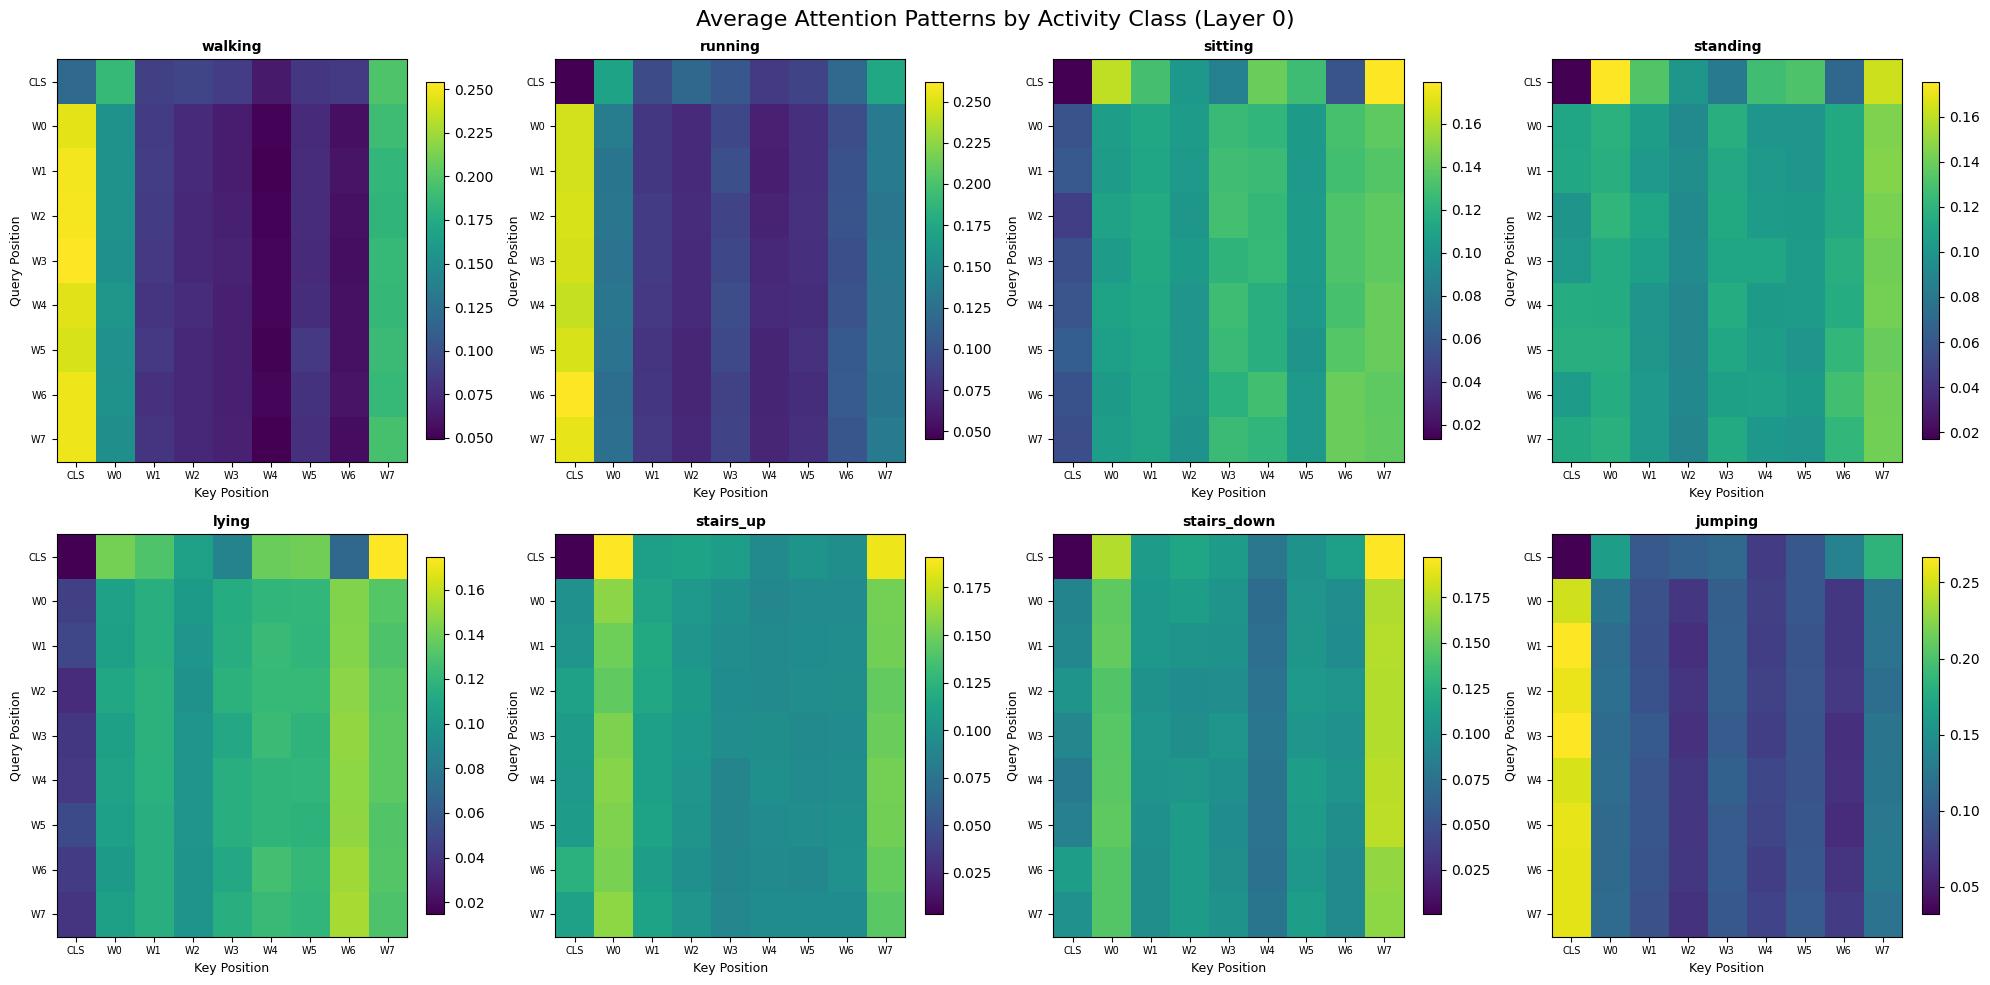

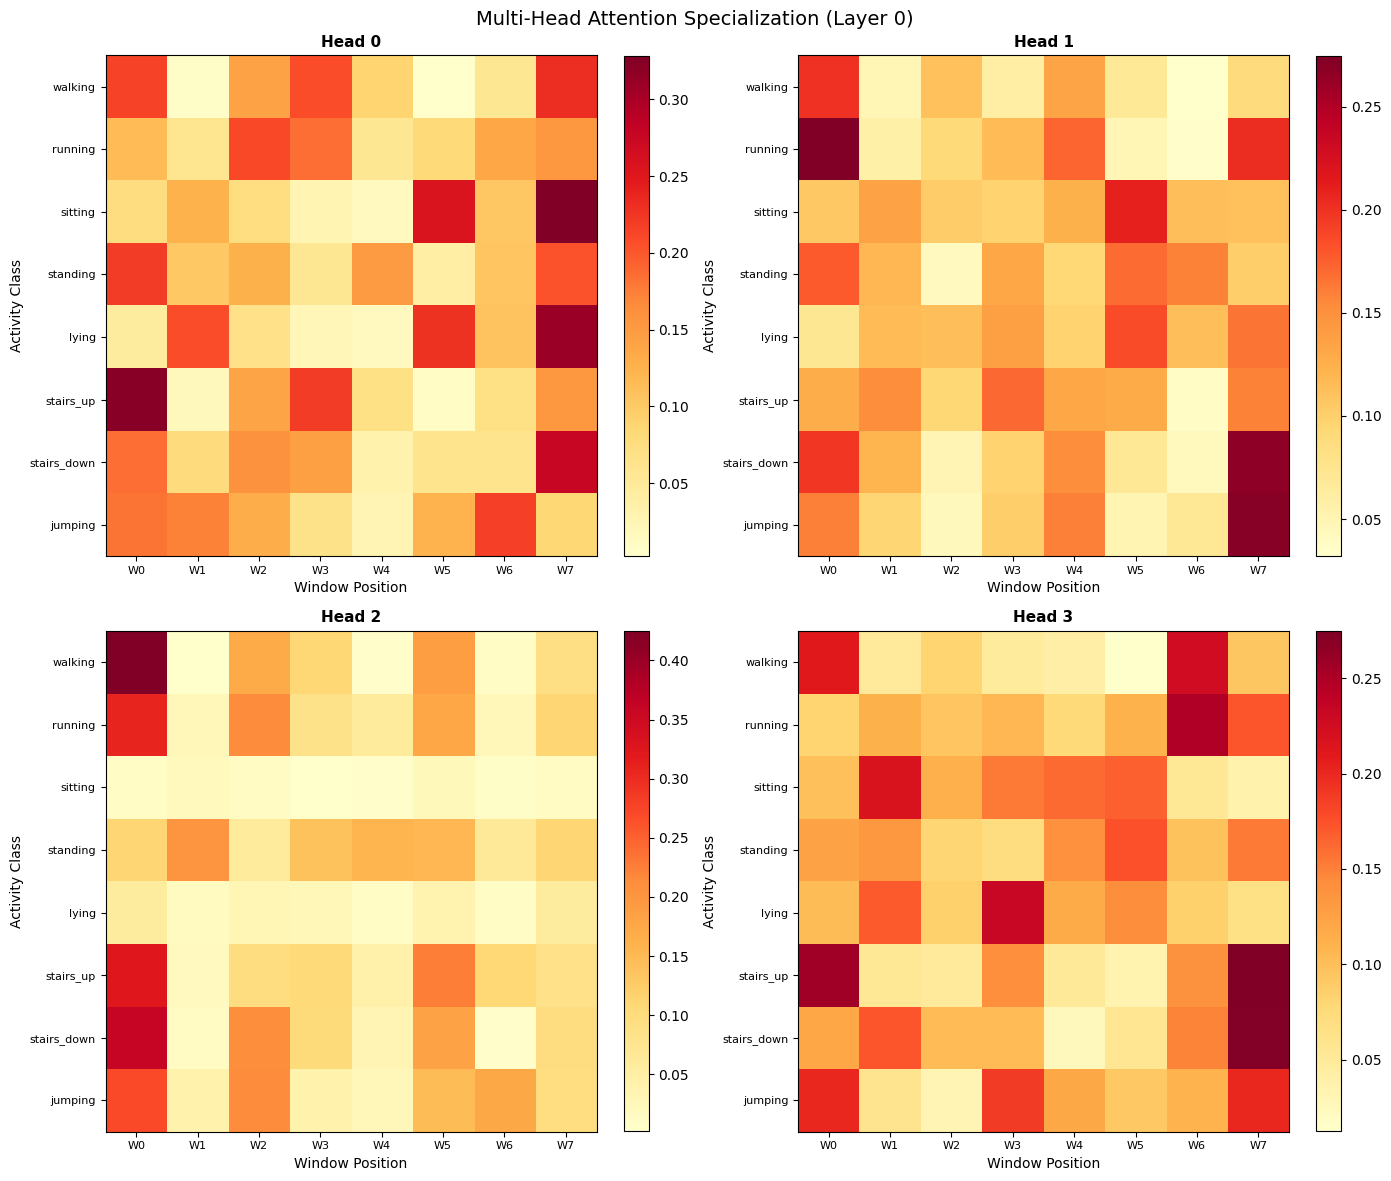

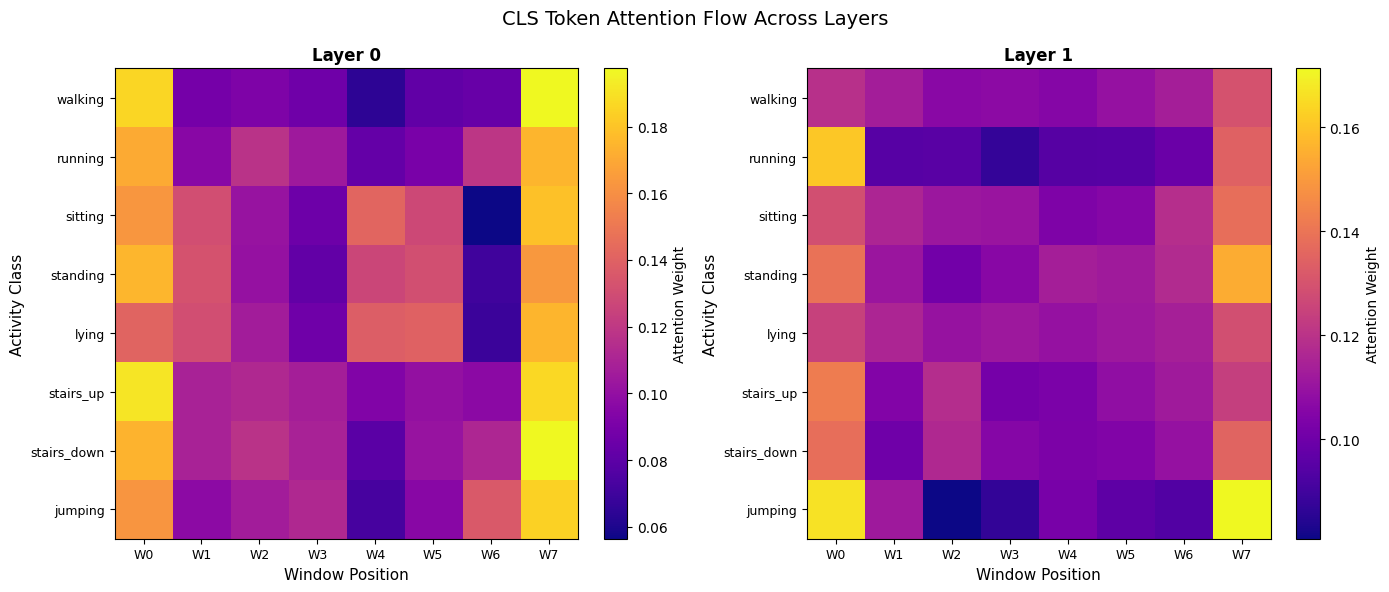

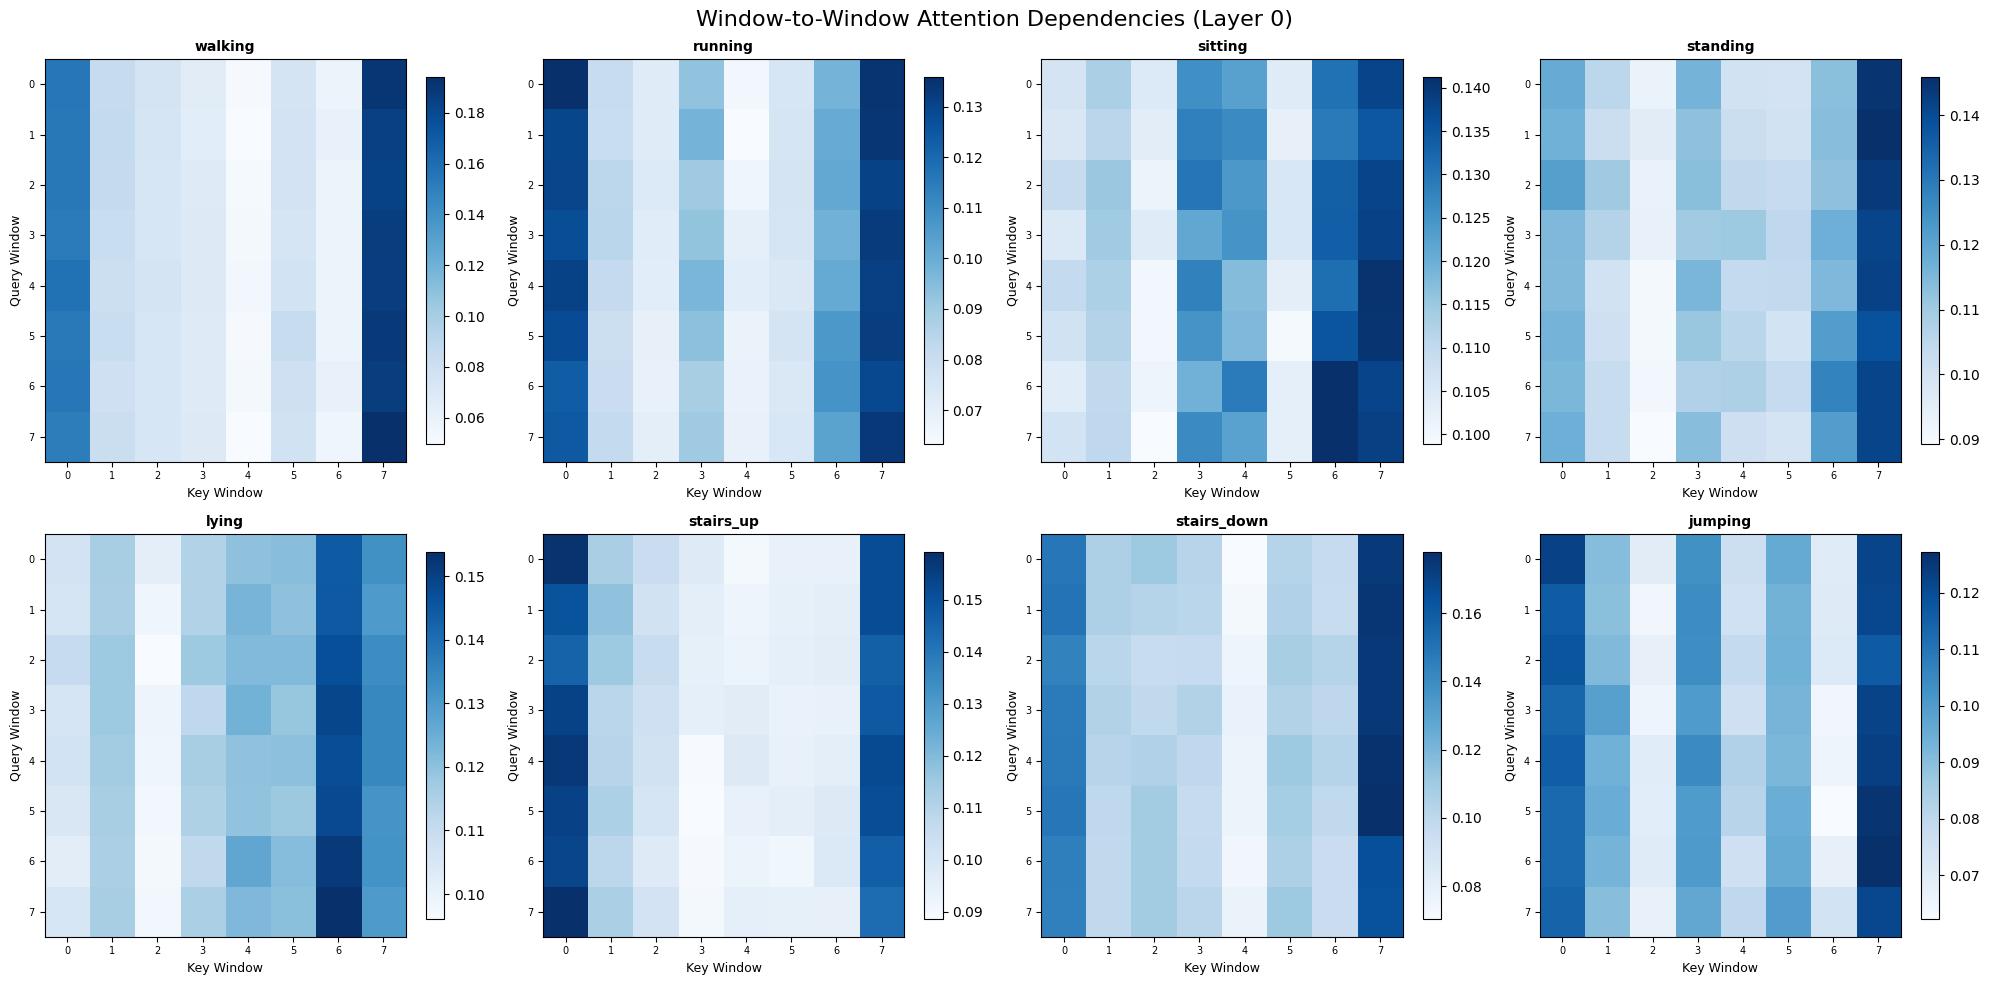

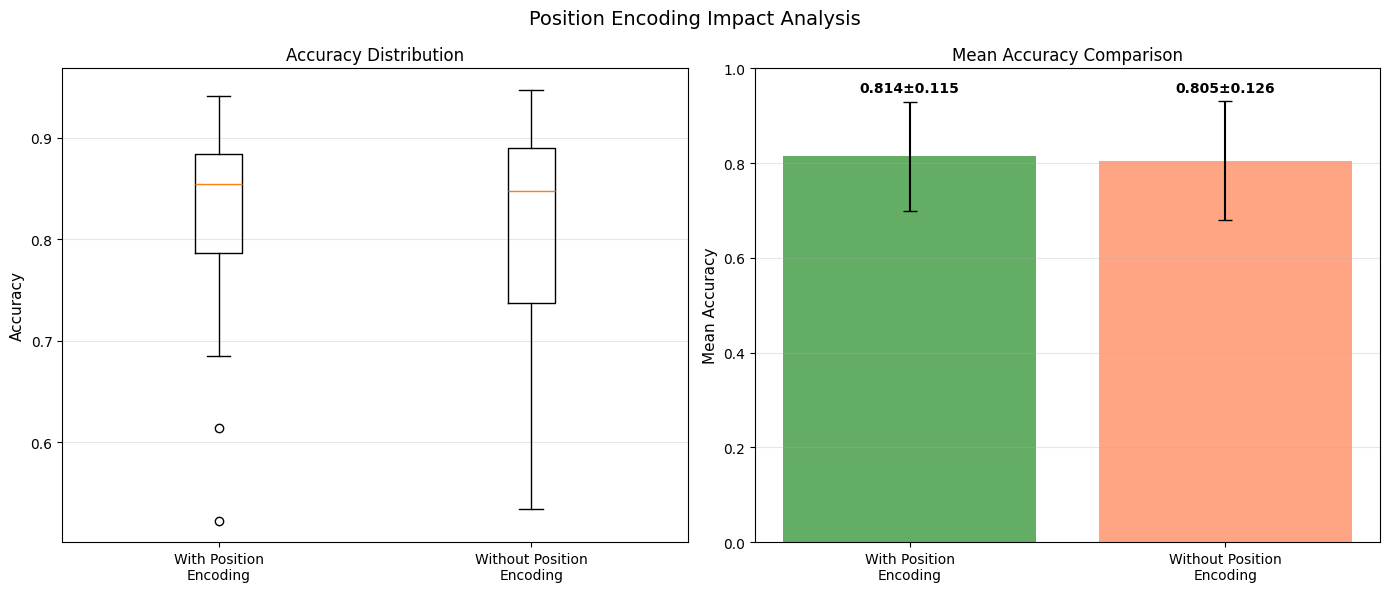

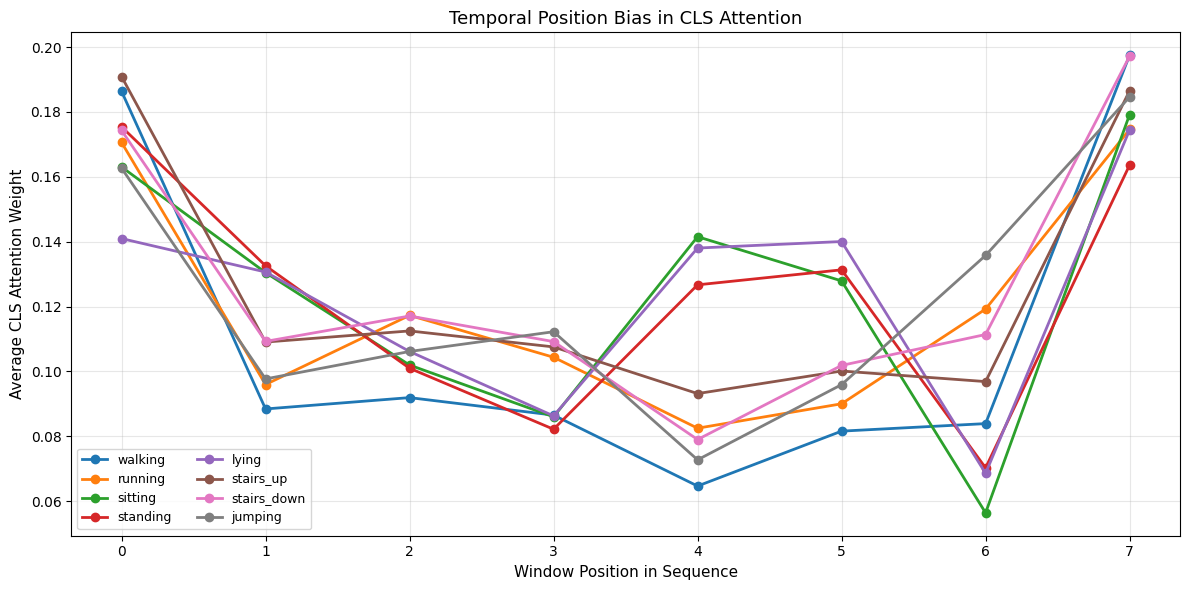


Attention analysis completed!
Figures saved to: /content/figures

Position Encoding Impact:
  Mean accuracy with position encoding: 0.8139 ± 0.1154
  Mean accuracy without position encoding: 0.8050 ± 0.1257
  Performance drop: 0.0090


In [ ]:
# ================ Step 10c: Transformer Attention Analysis ================

import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
from collections import defaultdict
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

BASE = Path("/content")
features_dir = BASE / "features"
configs_dir  = BASE / "configs"
logs_dir     = BASE / "logs"
fig_dir      = BASE / "figures"
models_dir   = BASE / "models"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(configs_dir / 'classes.json', 'r') as f:
    classes_cfg = json.load(f)
with open(configs_dir / 'splits.json', 'r') as f:
    splits_cfg = json.load(f)

CLASS_NAMES = [classes_cfg['id_to_label'][str(i)] for i in range(classes_cfg['num_classes'])]
NUM_CLASSES = classes_cfg['num_classes']
SEQ_LEN = 8
BATCH_SIZE = 64

attention_data = defaultdict(lambda: defaultdict(list))
position_results = defaultdict(list)

class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation=1, dropout=0.0):
        super().__init__()
        pad = (k // 2) * dilation
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, padding=pad, dilation=dilation, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.bn(x)
        x = self.act(x)
        return self.drop(x)

class WindowEncoder(nn.Module):
    def __init__(self, in_ch=6, d_model=128, dropout=0.2):
        super().__init__()
        self.in_ch = in_ch
        self.aug_ch = in_ch + 2
        self.b1 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=9, dilation=1, dropout=dropout)
        self.b2 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=19, dilation=2, dropout=dropout)
        self.mix = nn.Conv1d(d_model, d_model, kernel_size=1, bias=False)
        self.bn  = nn.BatchNorm1d(d_model)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
        self.g_proj = nn.Sequential(
            nn.Linear(4, d_model), nn.GELU(), nn.Linear(d_model, d_model)
        )
    def forward(self, x):
        BLT, C, T = x.shape
        acc_norm = torch.sqrt((x[:,0,:]**2 + x[:,1,:]**2 + x[:,2,:]**2) + 1e-8).unsqueeze(1)
        gyr_norm = torch.sqrt((x[:,3,:]**2 + x[:,4,:]**2 + x[:,5,:]**2) + 1e-8).unsqueeze(1)
        x_aug = torch.cat([x, acc_norm, gyr_norm], dim=1)
        z = torch.cat([self.b1(x_aug), self.b2(x_aug)], dim=1)
        z = self.mix(z)
        z = self.bn(z)
        z = self.act(z)
        z = self.drop(z)
        token = z.mean(dim=-1)
        acc_rms = acc_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        gyr_rms = gyr_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        acc_en  = x[:,0:3,:].pow(2).mean(dim=(1,2)).sqrt()
        gyr_en  = x[:,3:6,:].pow(2).mean(dim=(1,2)).sqrt()
        g = torch.stack([acc_rms, gyr_rms, acc_en, gyr_en], dim=-1)
        g = self.g_proj(g)
        return token, g

class CondLayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.gamma = nn.Linear(d_model, d_model)
        self.beta  = nn.Linear(d_model, d_model)
    def forward(self, x, g):
        y = self.ln(x)
        return y * (1 + self.gamma(g)) + self.beta(g)

class RCCBlock(nn.Module):
    def __init__(self, d_model=128, n_heads=4, d_ff=512, dropout=0.2):
        super().__init__()
        self.condln1 = CondLayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.condln2 = CondLayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.drop2 = nn.Dropout(dropout)
    def forward(self, x, g, return_attention=False):
        y = self.condln1(x, g)
        if return_attention:
            attn, attn_weights = self.mha(y, y, y, need_weights=True, average_attn_weights=False)
            x = x + self.drop1(attn)
            y = self.condln2(x, g)
            y = self.ff(y)
            x = x + self.drop2(y)
            return x, attn_weights
        else:
            attn, _ = self.mha(y, y, y, need_weights=False)
            x = x + self.drop1(attn)
            y = self.condln2(x, g)
            y = self.ff(y)
            x = x + self.drop2(y)
            return x

class GeoContextHAR(nn.Module):
    def __init__(self, in_ch=6, d_model=128, n_layers=2, n_heads=4, d_ff=512, dropout=0.2, seq_len=8, num_classes=8):
        super().__init__()
        self.seq_len = seq_len
        self.n_heads = n_heads
        self.encoder = WindowEncoder(in_ch=in_ch, d_model=d_model, dropout=dropout)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos = nn.Parameter(torch.zeros(1, seq_len + 1, d_model))
        self.blocks = nn.ModuleList([RCCBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x, return_attention=False, disable_pos=False):
        B, L, C, T = x.shape
        x = x.reshape(B*L, C, T)
        token, g = self.encoder(x)
        token = token.view(B, L, -1)
        g = g.view(B, L, -1)
        cls = self.cls_token.expand(B, -1, -1)
        z = torch.cat([cls, token], dim=1)
        g_cls = g.mean(dim=1, keepdim=True)
        g_all = torch.cat([g_cls, g], dim=1)

        if not disable_pos:
            z = z + self.pos

        attn_weights_all = []
        for blk in self.blocks:
            if return_attention:
                z, attn_w = blk(z, g_all, return_attention=True)
                attn_weights_all.append(attn_w)
            else:
                z = blk(z, g_all)

        z = self.norm(z)
        cls = z[:, 0, :]
        logits = self.head(cls)

        if return_attention:
            return logits, attn_weights_all
        return logits

def parse_window_id(wid: str):
    parts = wid.split(':')
    if len(parts) != 3:
        return wid, 0, 0
    return parts[0], int(parts[1]), int(parts[2])

class SeqDataset(Dataset):
    def __init__(self, npz_path: Path, split: str, seq_len=8, seq_stride=4):
        super().__init__()
        self.npz = np.load(npz_path, allow_pickle=True)
        self.split = split
        self.seq_len = seq_len

        self.ax = self.npz['acc_x']; self.ay = self.npz['acc_y']; self.az = self.npz['acc_z']
        self.gx = self.npz['gyro_x']; self.gy = self.npz['gyro_y']; self.gz = self.npz['gyro_z']
        self.labels  = self.npz['labels'].astype(np.int64)
        self.splits  = np.array(self.npz['splits']).astype(str)
        self.win_ids = np.array(self.npz['window_ids']).astype(str)
        self.subjects= np.array(self.npz['subjects']).astype(str)

        idx_split = np.where(self.splits == split)[0]
        groups = defaultdict(list)
        for idx in idx_split:
            f, seg, st = parse_window_id(self.win_ids[idx])
            groups[(self.subjects[idx], f, seg)].append((st, idx))

        self.seq_items = []
        for key, lst in groups.items():
            lst.sort(key=lambda x: x[0])
            order = [idx for _, idx in lst]
            if len(order) < seq_len:
                continue
            for i in range(0, len(order) - seq_len + 1, seq_stride):
                seq_idx = order[i:i+seq_len]
                center_idx = seq_idx[seq_len // 2]
                label = int(self.labels[center_idx])
                self.seq_items.append((seq_idx, center_idx, label))

    def __len__(self):
        return len(self.seq_items)

    def __getitem__(self, i):
        seq_idx, center_idx, label = self.seq_items[i]
        L = len(seq_idx); C = 6; T = self.ax.shape[1]
        X = np.zeros((L, C, T), dtype=np.float32)
        for j, idx in enumerate(seq_idx):
            X[j,0,:] = self.ax[idx]; X[j,1,:] = self.ay[idx]; X[j,2,:] = self.az[idx]
            X[j,3,:] = self.gx[idx]; X[j,4,:] = self.gy[idx]; X[j,5,:] = self.gz[idx]
        return torch.from_numpy(X), torch.tensor(label, dtype=torch.long), center_idx

def collate_fn(batch):
    xs, ys, centers = zip(*batch)
    return torch.stack(xs), torch.stack(ys), torch.tensor(centers, dtype=torch.long)

print("Analyzing attention patterns across all folds...")

for fold in splits_cfg['folds']:
    k = fold['fold']
    npz_path = features_dir / f'windows_normalized_fold{k}.npz'
    model_path = models_dir / f"rccmix_har_fold{k}.pt"

    if not npz_path.exists() or not model_path.exists():
        continue

    print(f"Processing fold {k}...")

    ds_test = SeqDataset(npz_path, 'test', SEQ_LEN, 4)
    loader_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=0, pin_memory=False, collate_fn=collate_fn)

    model = GeoContextHAR(in_ch=6, d_model=128, n_layers=2, n_heads=4,
                          d_ff=512, dropout=0.2, seq_len=SEQ_LEN,
                          num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    with torch.no_grad():
        # Collect attention patterns
        sample_count = 0
        for X, y, _ in loader_test:
            X = X.to(device)
            y_np = y.numpy()

            logits, attn_weights = model(X, return_attention=True)
            preds = logits.argmax(dim=1).cpu().numpy()

            for i, (label, pred) in enumerate(zip(y_np, preds)):
                class_name = CLASS_NAMES[label]

                for layer_idx, attn_w in enumerate(attn_weights):
                    attn_matrix = attn_w[i].cpu().numpy()

                    attention_data[class_name][f'layer{layer_idx}'].append(attn_matrix)

                    cls_attn = attn_matrix[:, 0, 1:]
                    attention_data[class_name][f'cls_layer{layer_idx}'].append(cls_attn)

                sample_count += 1
                if sample_count >= 500:
                    break

            if sample_count >= 500:
                break

        # Position encoding ablation
        all_preds_with_pos = []
        all_preds_no_pos = []
        all_labels = []

        for X, y, _ in loader_test:
            X = X.to(device)

            logits_with = model(X, disable_pos=False)
            logits_no = model(X, disable_pos=True)

            all_preds_with_pos.extend(logits_with.argmax(dim=1).cpu().numpy())
            all_preds_no_pos.extend(logits_no.argmax(dim=1).cpu().numpy())
            all_labels.extend(y.numpy())

        acc_with = accuracy_score(all_labels, all_preds_with_pos)
        acc_no = accuracy_score(all_labels, all_preds_no_pos)

        position_results['with_pos'].append(acc_with)
        position_results['no_pos'].append(acc_no)

print("\nGenerating visualizations...")

# ========== Visualization 1: Average Attention Maps ==========
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Average Attention Patterns by Activity Class (Layer 0)', fontsize=16)
axes = axes.flatten()

for idx, class_name in enumerate(CLASS_NAMES):
    ax = axes[idx]

    if f'layer0' in attention_data[class_name] and attention_data[class_name]['layer0']:
        attn_matrices = attention_data[class_name]['layer0']
        avg_attn = np.mean([a.mean(axis=0) for a in attn_matrices], axis=0)

        im = ax.imshow(avg_attn, cmap='viridis', aspect='auto')
        ax.set_xlabel('Key Position', fontsize=9)
        ax.set_ylabel('Query Position', fontsize=9)
        ax.set_title(class_name, fontsize=10, fontweight='bold')

        labels = ['CLS'] + [f'W{i}' for i in range(SEQ_LEN)]
        ax.set_xticks(range(SEQ_LEN + 1))
        ax.set_yticks(range(SEQ_LEN + 1))
        ax.set_xticklabels(labels, fontsize=7)
        ax.set_yticklabels(labels, fontsize=7)

        plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.savefig(fig_dir / 'step10c_attention_maps.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 2: Multi-Head Attention Specialization ==========
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Multi-Head Attention Specialization (Layer 0)', fontsize=14)

for head_idx in range(4):
    ax = axes[head_idx // 2, head_idx % 2]

    head_patterns = []
    activity_labels = []

    for class_name in CLASS_NAMES:
        if 'layer0' in attention_data[class_name] and attention_data[class_name]['layer0']:
            for attn_matrix in attention_data[class_name]['layer0'][:20]:
                head_attn = attn_matrix[head_idx]
                cls_to_windows = head_attn[0, 1:]
                head_patterns.append(cls_to_windows)
                activity_labels.append(class_name)

    if head_patterns:
        head_patterns = np.array(head_patterns)

        heatmap_data = []
        for class_name in CLASS_NAMES:
            class_mask = np.array(activity_labels) == class_name
            if class_mask.sum() > 0:
                heatmap_data.append(head_patterns[class_mask].mean(axis=0))

        if heatmap_data:
            im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
            ax.set_xlabel('Window Position', fontsize=10)
            ax.set_ylabel('Activity Class', fontsize=10)
            ax.set_title(f'Head {head_idx}', fontsize=11, fontweight='bold')
            ax.set_yticks(range(len(CLASS_NAMES)))
            ax.set_yticklabels(CLASS_NAMES, fontsize=8)
            ax.set_xticks(range(SEQ_LEN))
            ax.set_xticklabels([f'W{i}' for i in range(SEQ_LEN)], fontsize=8)
            plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.savefig(fig_dir / 'step10c_head_specialization.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 3: CLS Token Attention Flow ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('CLS Token Attention Flow Across Layers', fontsize=14)

for layer_idx in range(2):
    ax = axes[layer_idx]

    cls_patterns = []
    for class_name in CLASS_NAMES:
        key = f'cls_layer{layer_idx}'
        if key in attention_data[class_name] and attention_data[class_name][key]:
            cls_attn = np.mean([a.mean(axis=0) for a in attention_data[class_name][key]], axis=0)
            cls_patterns.append(cls_attn)
        else:
            cls_patterns.append(np.zeros(SEQ_LEN))

    im = ax.imshow(cls_patterns, cmap='plasma', aspect='auto')
    ax.set_xlabel('Window Position', fontsize=11)
    ax.set_ylabel('Activity Class', fontsize=11)
    ax.set_title(f'Layer {layer_idx}', fontsize=12, fontweight='bold')
    ax.set_yticks(range(len(CLASS_NAMES)))
    ax.set_yticklabels(CLASS_NAMES, fontsize=9)
    ax.set_xticks(range(SEQ_LEN))
    ax.set_xticklabels([f'W{i}' for i in range(SEQ_LEN)], fontsize=9)
    plt.colorbar(im, ax=ax, fraction=0.046, label='Attention Weight')

plt.tight_layout()
plt.savefig(fig_dir / 'step10c_cls_attention.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 4: Window Dependency Graph ==========
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Window-to-Window Attention Dependencies (Layer 0)', fontsize=16)
axes = axes.flatten()

for idx, class_name in enumerate(CLASS_NAMES):
    ax = axes[idx]

    if 'layer0' in attention_data[class_name] and attention_data[class_name]['layer0']:
        attn_matrices = attention_data[class_name]['layer0']

        window_attn = []
        for attn_matrix in attn_matrices:
            avg_heads = attn_matrix.mean(axis=0)
            window_only = avg_heads[1:, 1:]
            window_attn.append(window_only)

        avg_window_attn = np.mean(window_attn, axis=0)

        im = ax.imshow(avg_window_attn, cmap='Blues', aspect='auto')
        ax.set_xlabel('Key Window', fontsize=9)
        ax.set_ylabel('Query Window', fontsize=9)
        ax.set_title(class_name, fontsize=10, fontweight='bold')
        ax.set_xticks(range(SEQ_LEN))
        ax.set_yticks(range(SEQ_LEN))
        ax.set_xticklabels([f'{i}' for i in range(SEQ_LEN)], fontsize=7)
        ax.set_yticklabels([f'{i}' for i in range(SEQ_LEN)], fontsize=7)
        plt.colorbar(im, ax=ax, fraction=0.046)

plt.tight_layout()
plt.savefig(fig_dir / 'step10c_window_dependencies.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 5: Position Encoding Ablation ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Position Encoding Impact Analysis', fontsize=14)

acc_with = position_results['with_pos']
acc_no = position_results['no_pos']

axes[0].boxplot([acc_with, acc_no], labels=['With Position\nEncoding', 'Without Position\nEncoding'])
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Accuracy Distribution', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

mean_with = np.mean(acc_with)
mean_no = np.mean(acc_no)
std_with = np.std(acc_with)
std_no = np.std(acc_no)

axes[1].bar(['With Position\nEncoding', 'Without Position\nEncoding'],
           [mean_with, mean_no],
           yerr=[std_with, std_no],
           color=['forestgreen', 'coral'], alpha=0.7, capsize=5)
axes[1].set_ylabel('Mean Accuracy', fontsize=11)
axes[1].set_title('Mean Accuracy Comparison', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for i, (mean, std) in enumerate([(mean_with, std_with), (mean_no, std_no)]):
    axes[1].text(i, mean + std + 0.02, f'{mean:.3f}±{std:.3f}',
                ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(fig_dir / 'step10c_position_encoding.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 6: Temporal Attention Patterns ==========
fig, ax = plt.subplots(figsize=(12, 6))

temporal_bias = []
temporal_names = []

for class_name in CLASS_NAMES:
    if 'layer0' in attention_data[class_name] and attention_data[class_name]['layer0']:
        attn_matrices = attention_data[class_name]['layer0']

        position_scores = np.zeros(SEQ_LEN)
        for attn_matrix in attn_matrices:
            avg_heads = attn_matrix.mean(axis=0)
            cls_attn = avg_heads[0, 1:]
            position_scores += cls_attn

        position_scores /= len(attn_matrices)
        temporal_bias.append(position_scores)
        temporal_names.append(class_name)

if temporal_bias:
    temporal_bias = np.array(temporal_bias)

    for i, class_name in enumerate(temporal_names):
        ax.plot(range(SEQ_LEN), temporal_bias[i], marker='o', label=class_name, linewidth=2)

    ax.set_xlabel('Window Position in Sequence', fontsize=11)
    ax.set_ylabel('Average CLS Attention Weight', fontsize=11)
    ax.set_title('Temporal Position Bias in CLS Attention', fontsize=13)
    ax.set_xticks(range(SEQ_LEN))
    ax.set_xticklabels([f'{i}' for i in range(SEQ_LEN)])
    ax.legend(fontsize=9, ncol=2, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_dir / 'step10c_temporal_bias.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAttention analysis completed!")
print(f"Figures saved to: {fig_dir}")
print(f"\nPosition Encoding Impact:")
print(f"  Mean accuracy with position encoding: {np.mean(acc_with):.4f} ± {np.std(acc_with):.4f}")
print(f"  Mean accuracy without position encoding: {np.mean(acc_no):.4f} ± {np.std(acc_no):.4f}")
print(f"  Performance drop: {(np.mean(acc_with) - np.mean(acc_no)):.4f}")

Analyzing multi-scale branch contributions across all folds...
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
Processing fold 11...
Processing fold 12...
Processing fold 13...
Processing fold 14...

Generating visualizations...


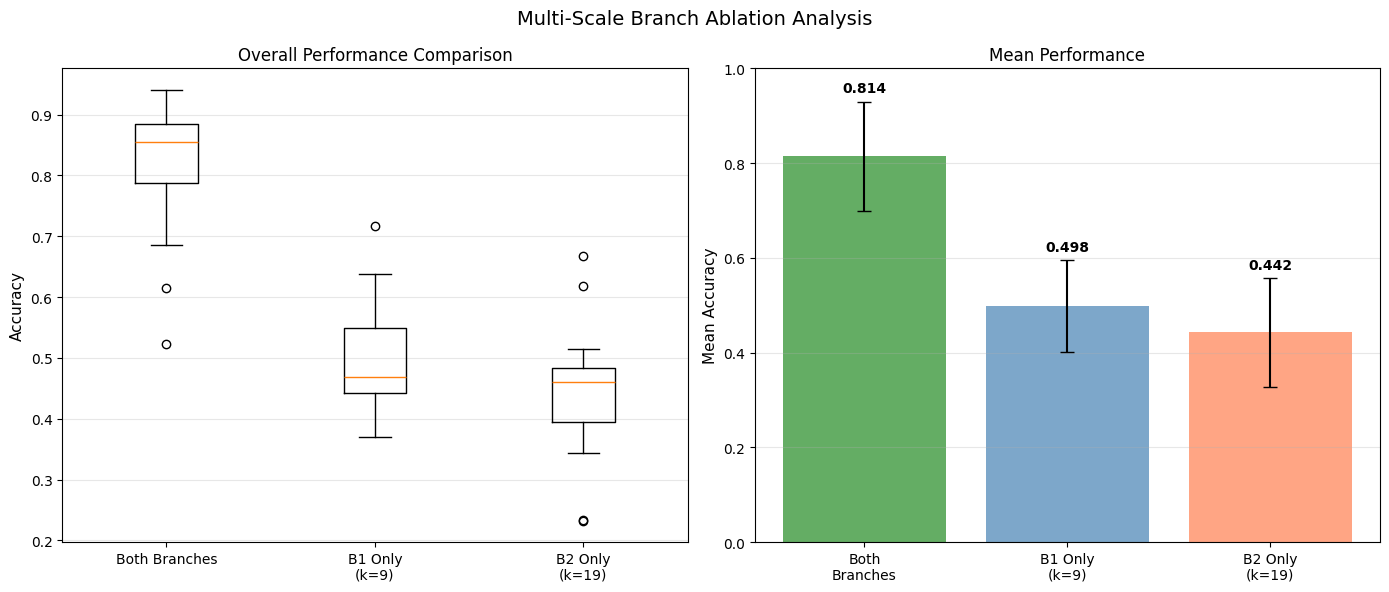

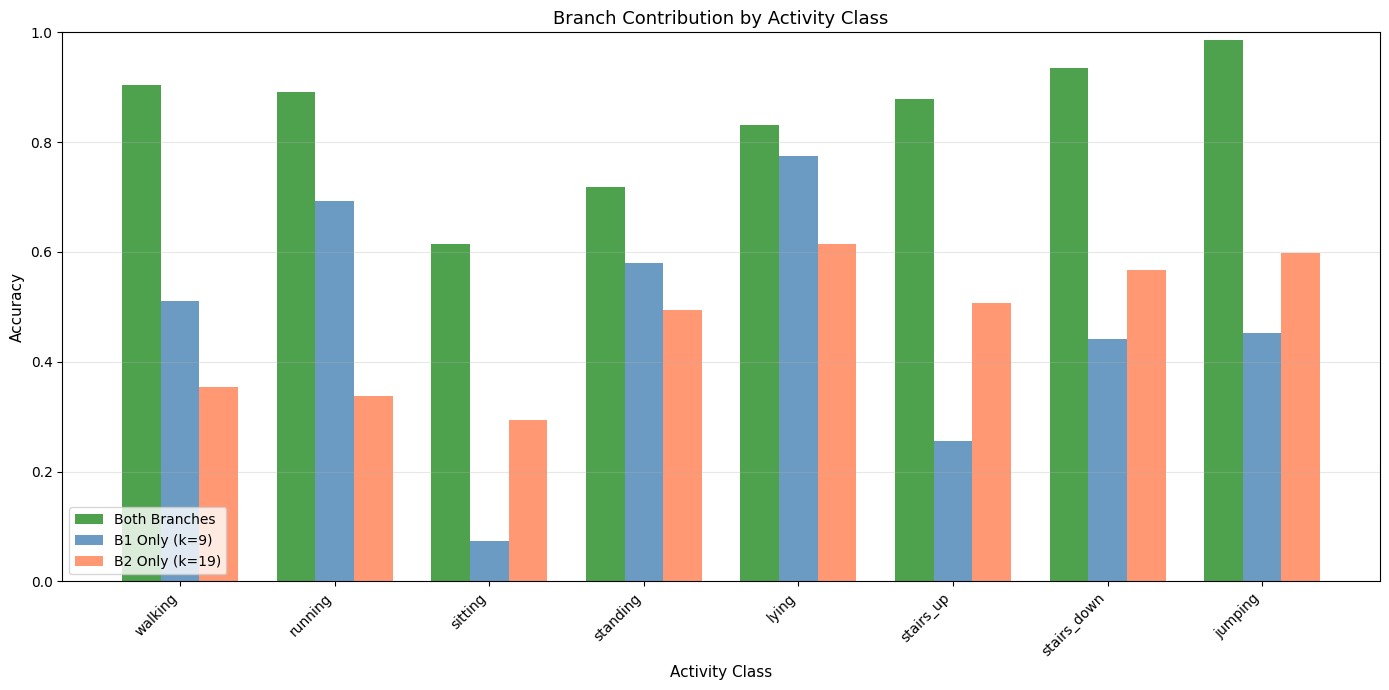

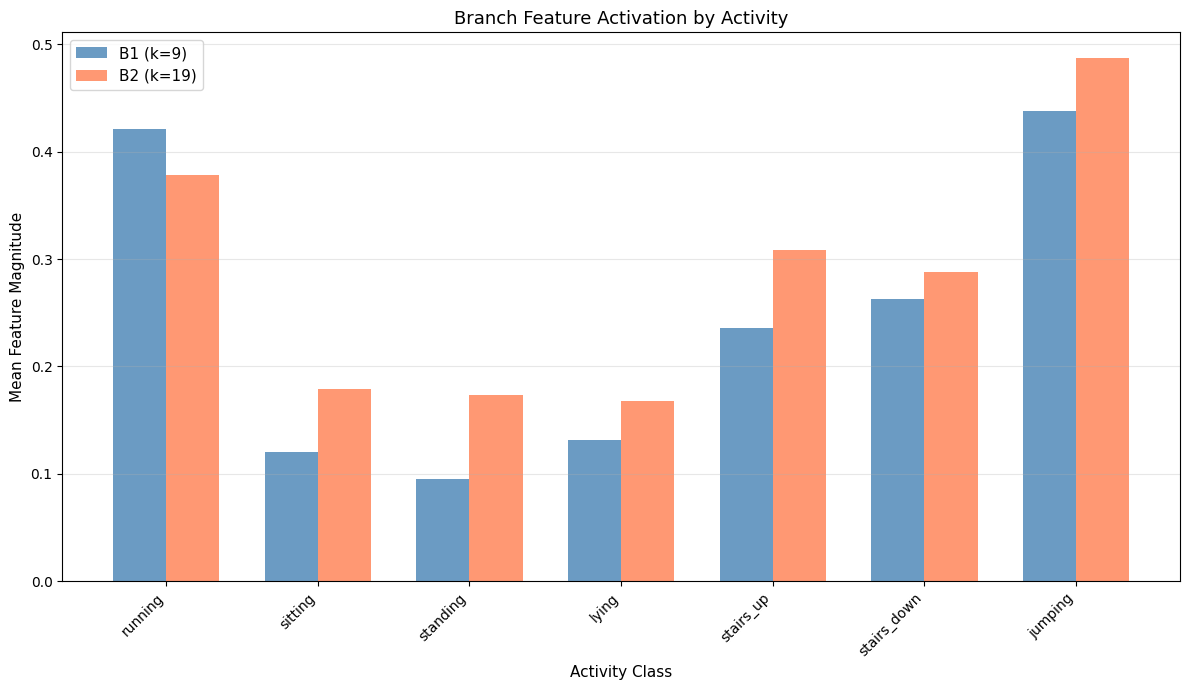

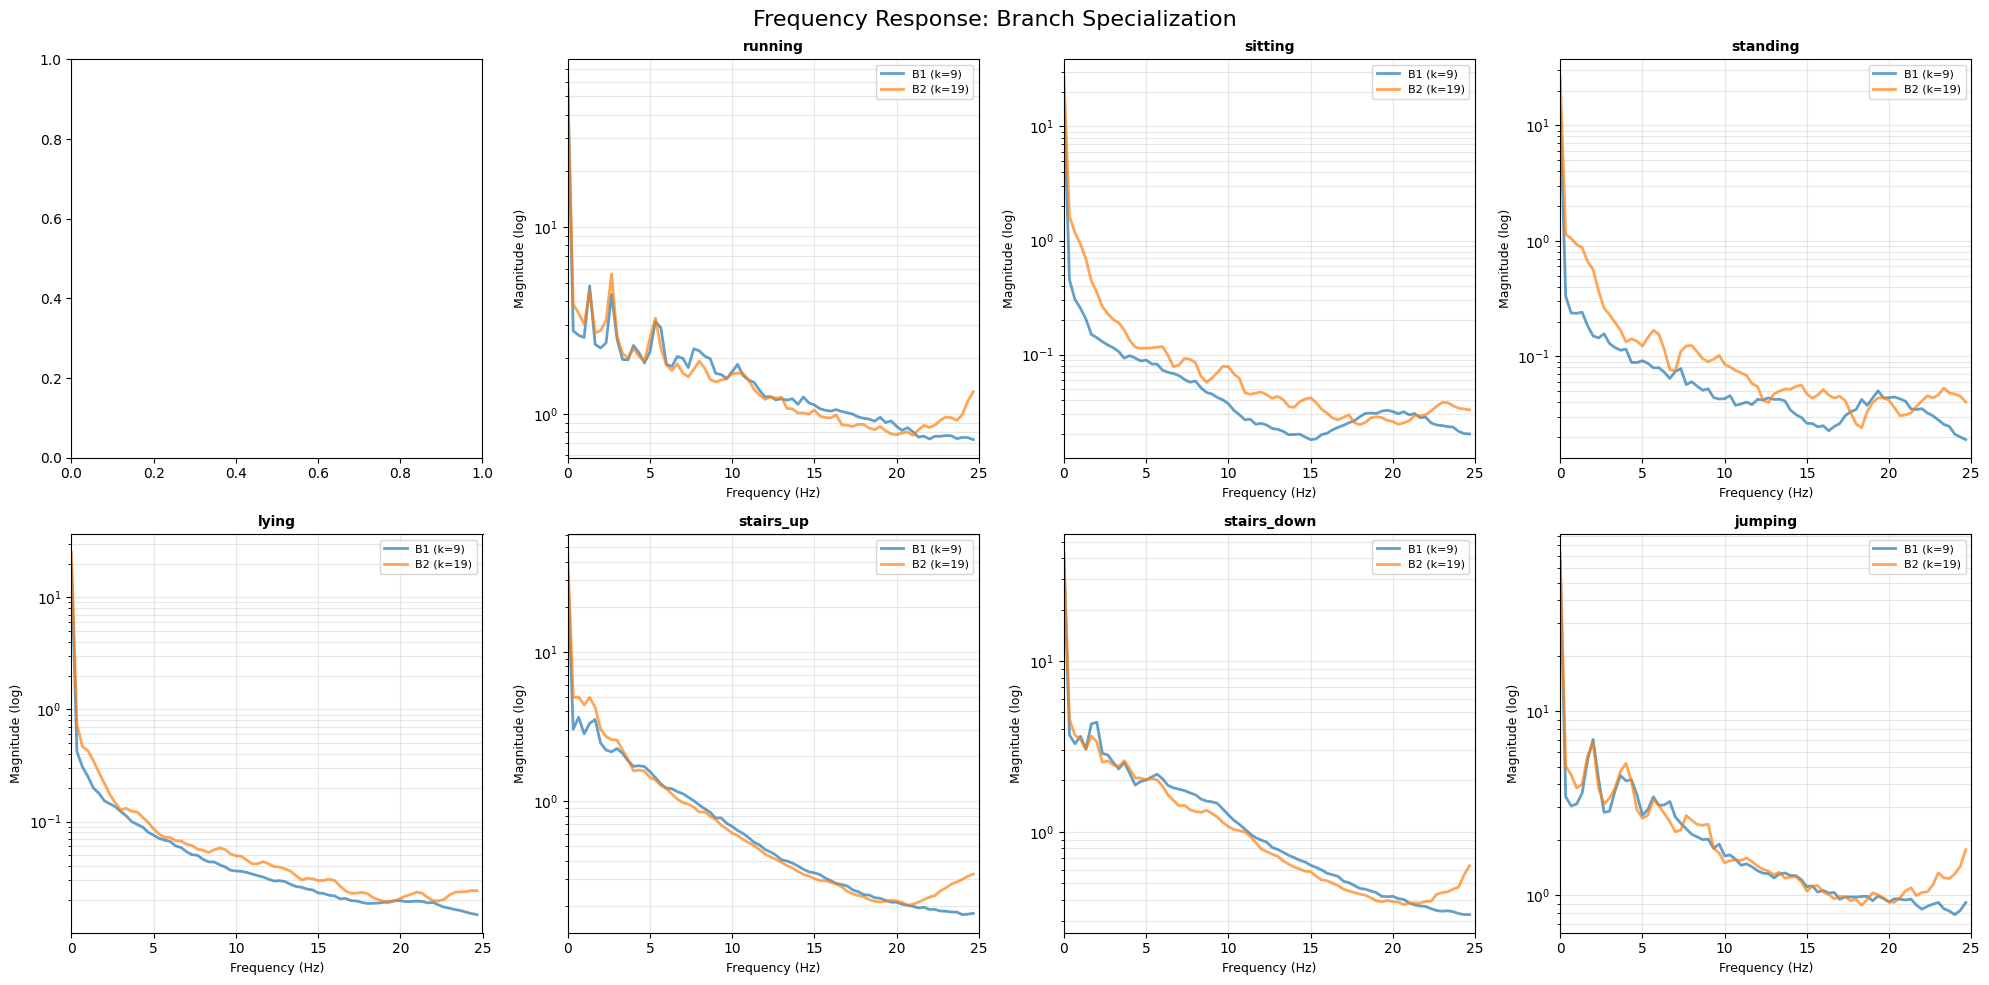

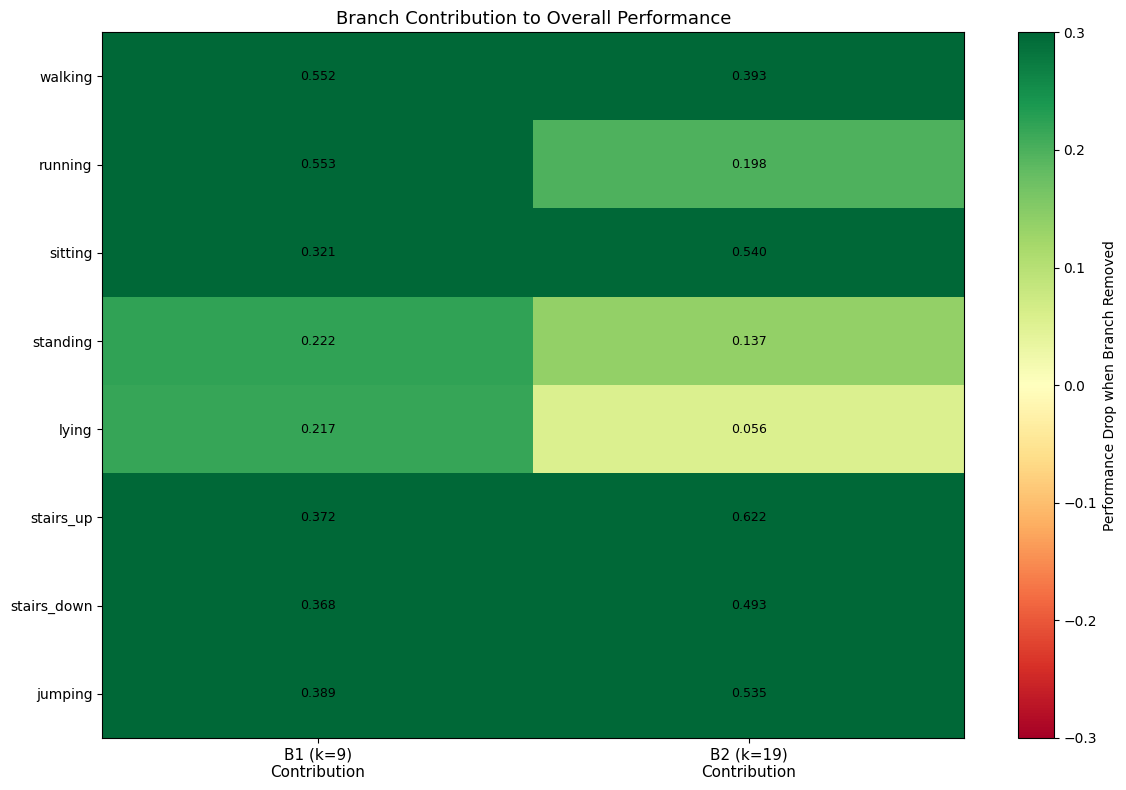

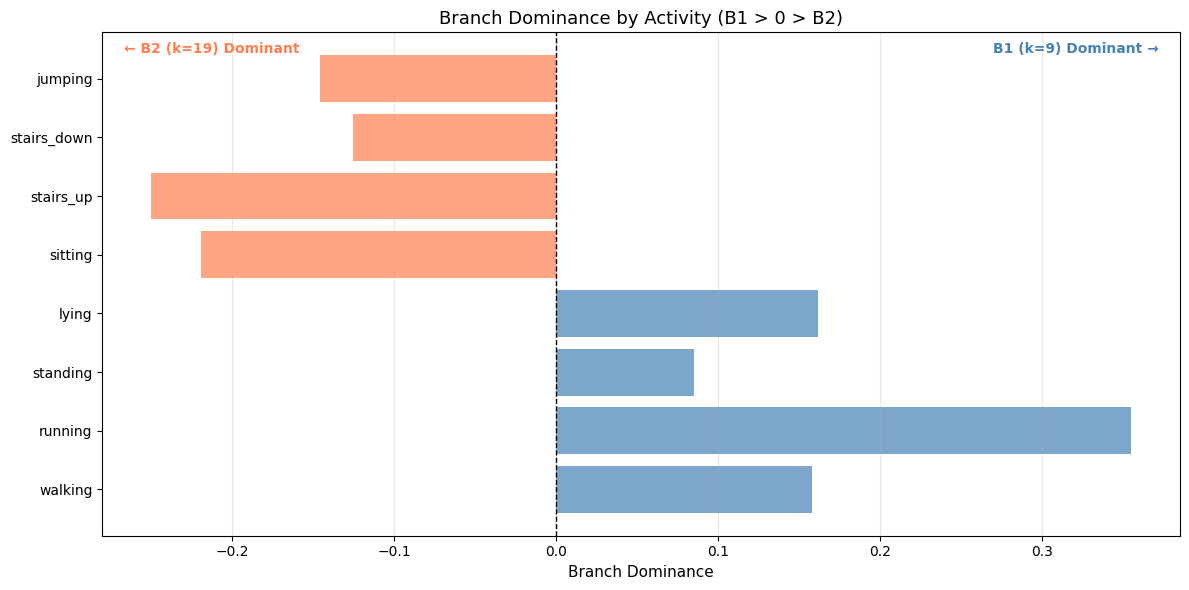


Multi-scale branch analysis completed!
Figures saved to: /content/figures

Performance Summary:
  Both branches: 0.9867 ± 0.0000
  B1 only (k=9): 0.4519 ± 0.0000
  B2 only (k=19): 0.5979 ± 0.0000
  Performance drop without B1: 0.3888
  Performance drop without B2: 0.5348


In [ ]:
# ================ Step 10d: Multi-Scale Branch Analysis ================

import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
from collections import defaultdict
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from scipy.fft import fft, fftfreq

BASE = Path("/content")
features_dir = BASE / "features"
configs_dir  = BASE / "configs"
logs_dir     = BASE / "logs"
fig_dir      = BASE / "figures"
models_dir   = BASE / "models"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(configs_dir / 'classes.json', 'r') as f:
    classes_cfg = json.load(f)
with open(configs_dir / 'splits.json', 'r') as f:
    splits_cfg = json.load(f)

CLASS_NAMES = [classes_cfg['id_to_label'][str(i)] for i in range(classes_cfg['num_classes'])]
NUM_CLASSES = classes_cfg['num_classes']
SEQ_LEN = 8
BATCH_SIZE = 64
SAMPLE_RATE = 50

branch_ablation_results = defaultdict(lambda: defaultdict(list))
branch_features = defaultdict(lambda: defaultdict(list))
frequency_data = defaultdict(lambda: defaultdict(list))

class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation=1, dropout=0.0):
        super().__init__()
        pad = (k // 2) * dilation
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, padding=pad, dilation=dilation, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.bn(x)
        x = self.act(x)
        return self.drop(x)

class WindowEncoder(nn.Module):
    def __init__(self, in_ch=6, d_model=128, dropout=0.2):
        super().__init__()
        self.in_ch = in_ch
        self.aug_ch = in_ch + 2
        self.b1 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=9, dilation=1, dropout=dropout)
        self.b2 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=19, dilation=2, dropout=dropout)
        self.mix = nn.Conv1d(d_model, d_model, kernel_size=1, bias=False)
        self.bn  = nn.BatchNorm1d(d_model)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
        self.g_proj = nn.Sequential(
            nn.Linear(4, d_model), nn.GELU(), nn.Linear(d_model, d_model)
        )

    def forward(self, x, disable_b1=False, disable_b2=False, return_branches=False):
        BLT, C, T = x.shape
        acc_norm = torch.sqrt((x[:,0,:]**2 + x[:,1,:]**2 + x[:,2,:]**2) + 1e-8).unsqueeze(1)
        gyr_norm = torch.sqrt((x[:,3,:]**2 + x[:,4,:]**2 + x[:,5,:]**2) + 1e-8).unsqueeze(1)
        x_aug = torch.cat([x, acc_norm, gyr_norm], dim=1)

        if disable_b1:
            z1 = torch.zeros(BLT, 64, T, device=x.device)
        else:
            z1 = self.b1(x_aug)

        if disable_b2:
            z2 = torch.zeros(BLT, 64, T, device=x.device)
        else:
            z2 = self.b2(x_aug)

        z = torch.cat([z1, z2], dim=1)
        z = self.mix(z)
        z = self.bn(z)
        z = self.act(z)
        z = self.drop(z)
        token = z.mean(dim=-1)

        acc_rms = acc_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        gyr_rms = gyr_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        acc_en  = x[:,0:3,:].pow(2).mean(dim=(1,2)).sqrt()
        gyr_en  = x[:,3:6,:].pow(2).mean(dim=(1,2)).sqrt()
        g = torch.stack([acc_rms, gyr_rms, acc_en, gyr_en], dim=-1)
        g = self.g_proj(g)

        if return_branches:
            return token, g, z1, z2
        return token, g

class CondLayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.gamma = nn.Linear(d_model, d_model)
        self.beta  = nn.Linear(d_model, d_model)
    def forward(self, x, g):
        y = self.ln(x)
        return y * (1 + self.gamma(g)) + self.beta(g)

class RCCBlock(nn.Module):
    def __init__(self, d_model=128, n_heads=4, d_ff=512, dropout=0.2):
        super().__init__()
        self.condln1 = CondLayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.condln2 = CondLayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.drop2 = nn.Dropout(dropout)
    def forward(self, x, g):
        y = self.condln1(x, g)
        attn, _ = self.mha(y, y, y, need_weights=False)
        x = x + self.drop1(attn)
        y = self.condln2(x, g)
        y = self.ff(y)
        x = x + self.drop2(y)
        return x

class GeoContextHAR(nn.Module):
    def __init__(self, in_ch=6, d_model=128, n_layers=2, n_heads=4, d_ff=512, dropout=0.2, seq_len=8, num_classes=8):
        super().__init__()
        self.seq_len = seq_len
        self.encoder = WindowEncoder(in_ch=in_ch, d_model=d_model, dropout=dropout)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos = nn.Parameter(torch.zeros(1, seq_len + 1, d_model))
        self.blocks = nn.ModuleList([RCCBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x, disable_b1=False, disable_b2=False, return_branches=False):
        B, L, C, T = x.shape
        x = x.reshape(B*L, C, T)

        if return_branches:
            token, g, z1, z2 = self.encoder(x, disable_b1, disable_b2, return_branches=True)
        else:
            token, g = self.encoder(x, disable_b1, disable_b2)

        token = token.view(B, L, -1)
        g = g.view(B, L, -1)
        cls = self.cls_token.expand(B, -1, -1)
        z = torch.cat([cls, token], dim=1)
        g_cls = g.mean(dim=1, keepdim=True)
        g_all = torch.cat([g_cls, g], dim=1)
        z = z + self.pos

        for blk in self.blocks:
            z = blk(z, g_all)

        z = self.norm(z)
        cls = z[:, 0, :]
        logits = self.head(cls)

        if return_branches:
            return logits, z1, z2
        return logits

def parse_window_id(wid: str):
    parts = wid.split(':')
    if len(parts) != 3:
        return wid, 0, 0
    return parts[0], int(parts[1]), int(parts[2])

class SeqDataset(Dataset):
    def __init__(self, npz_path: Path, split: str, seq_len=8, seq_stride=4):
        super().__init__()
        self.npz = np.load(npz_path, allow_pickle=True)
        self.split = split
        self.seq_len = seq_len

        self.ax = self.npz['acc_x']; self.ay = self.npz['acc_y']; self.az = self.npz['acc_z']
        self.gx = self.npz['gyro_x']; self.gy = self.npz['gyro_y']; self.gz = self.npz['gyro_z']
        self.labels  = self.npz['labels'].astype(np.int64)
        self.splits  = np.array(self.npz['splits']).astype(str)
        self.win_ids = np.array(self.npz['window_ids']).astype(str)
        self.subjects= np.array(self.npz['subjects']).astype(str)

        idx_split = np.where(self.splits == split)[0]
        groups = defaultdict(list)
        for idx in idx_split:
            f, seg, st = parse_window_id(self.win_ids[idx])
            groups[(self.subjects[idx], f, seg)].append((st, idx))

        self.seq_items = []
        for key, lst in groups.items():
            lst.sort(key=lambda x: x[0])
            order = [idx for _, idx in lst]
            if len(order) < seq_len:
                continue
            for i in range(0, len(order) - seq_len + 1, seq_stride):
                seq_idx = order[i:i+seq_len]
                center_idx = seq_idx[seq_len // 2]
                label = int(self.labels[center_idx])
                self.seq_items.append((seq_idx, center_idx, label))

    def __len__(self):
        return len(self.seq_items)

    def __getitem__(self, i):
        seq_idx, center_idx, label = self.seq_items[i]
        L = len(seq_idx); C = 6; T = self.ax.shape[1]
        X = np.zeros((L, C, T), dtype=np.float32)
        for j, idx in enumerate(seq_idx):
            X[j,0,:] = self.ax[idx]; X[j,1,:] = self.ay[idx]; X[j,2,:] = self.az[idx]
            X[j,3,:] = self.gx[idx]; X[j,4,:] = self.gy[idx]; X[j,5,:] = self.gz[idx]
        return torch.from_numpy(X), torch.tensor(label, dtype=torch.long), center_idx

def collate_fn(batch):
    xs, ys, centers = zip(*batch)
    return torch.stack(xs), torch.stack(ys), torch.tensor(centers, dtype=torch.long)

print("Analyzing multi-scale branch contributions across all folds...")

for fold in splits_cfg['folds']:
    k = fold['fold']
    npz_path = features_dir / f'windows_normalized_fold{k}.npz'
    model_path = models_dir / f"rccmix_har_fold{k}.pt"

    if not npz_path.exists() or not model_path.exists():
        continue

    print(f"Processing fold {k}...")

    ds_test = SeqDataset(npz_path, 'test', SEQ_LEN, 4)
    loader_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=0, pin_memory=False, collate_fn=collate_fn)

    model = GeoContextHAR(in_ch=6, d_model=128, n_layers=2, n_heads=4,
                          d_ff=512, dropout=0.2, seq_len=SEQ_LEN,
                          num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    with torch.no_grad():
        all_preds_both = []
        all_preds_b1_only = []
        all_preds_b2_only = []
        all_labels = []
        class_preds_both = defaultdict(list)
        class_preds_b1 = defaultdict(list)
        class_preds_b2 = defaultdict(list)

        for X, y, _ in loader_test:
            X = X.to(device)
            y_np = y.numpy()

            logits_both = model(X, disable_b1=False, disable_b2=False)
            logits_b1 = model(X, disable_b1=False, disable_b2=True)
            logits_b2 = model(X, disable_b1=True, disable_b2=False)

            preds_both = logits_both.argmax(dim=1).cpu().numpy()
            preds_b1 = logits_b1.argmax(dim=1).cpu().numpy()
            preds_b2 = logits_b2.argmax(dim=1).cpu().numpy()

            all_preds_both.extend(preds_both)
            all_preds_b1_only.extend(preds_b1)
            all_preds_b2_only.extend(preds_b2)
            all_labels.extend(y_np)

            for i, label in enumerate(y_np):
                class_name = CLASS_NAMES[label]
                class_preds_both[class_name].append(preds_both[i] == label)
                class_preds_b1[class_name].append(preds_b1[i] == label)
                class_preds_b2[class_name].append(preds_b2[i] == label)

        acc_both = accuracy_score(all_labels, all_preds_both)
        acc_b1 = accuracy_score(all_labels, all_preds_b1_only)
        acc_b2 = accuracy_score(all_labels, all_preds_b2_only)

        branch_ablation_results['both']['accuracy'].append(acc_both)
        branch_ablation_results['b1_only']['accuracy'].append(acc_b1)
        branch_ablation_results['b2_only']['accuracy'].append(acc_b2)

        for class_name in CLASS_NAMES:
            if class_name in class_preds_both and class_preds_both[class_name]:
                branch_ablation_results[class_name]['both'].append(np.mean(class_preds_both[class_name]))
                branch_ablation_results[class_name]['b1_only'].append(np.mean(class_preds_b1[class_name]))
                branch_ablation_results[class_name]['b2_only'].append(np.mean(class_preds_b2[class_name]))

        sample_count = 0
        for X, y, _ in loader_test:
            X = X.to(device)
            y_np = y.numpy()

            logits, z1, z2 = model(X, return_branches=True)

            z1_np = z1.cpu().numpy()
            z2_np = z2.cpu().numpy()

            for i, label in enumerate(y_np):
                class_name = CLASS_NAMES[label]

                z1_seq = z1_np[i * SEQ_LEN:(i+1) * SEQ_LEN]
                z2_seq = z2_np[i * SEQ_LEN:(i+1) * SEQ_LEN]

                branch_features[class_name]['b1'].append(z1_seq.mean())
                branch_features[class_name]['b2'].append(z2_seq.mean())

                for j in range(SEQ_LEN):
                    idx = i * SEQ_LEN + j
                    if idx < len(z1_np):
                        b1_signal = z1_np[idx].mean(axis=0)
                        b2_signal = z2_np[idx].mean(axis=0)

                        n_samples = len(b1_signal)
                        freqs = fftfreq(n_samples, 1.0/SAMPLE_RATE)
                        fft_b1 = np.abs(fft(b1_signal))
                        fft_b2 = np.abs(fft(b2_signal))

                        half_n = n_samples // 2
                        frequency_data[class_name]['b1_fft'].append(fft_b1[:half_n])
                        frequency_data[class_name]['b2_fft'].append(fft_b2[:half_n])
                        frequency_data[class_name]['freqs'].append(freqs[:half_n])

                sample_count += 1
                if sample_count >= 200:
                    break

            if sample_count >= 200:
                break

print("\nGenerating visualizations...")

# ========== Visualization 1: Branch Ablation Performance ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Multi-Scale Branch Ablation Analysis', fontsize=14)

acc_both = branch_ablation_results['both']['accuracy']
acc_b1 = branch_ablation_results['b1_only']['accuracy']
acc_b2 = branch_ablation_results['b2_only']['accuracy']

axes[0].boxplot([acc_both, acc_b1, acc_b2],
               labels=['Both Branches', 'B1 Only\n(k=9)', 'B2 Only\n(k=19)'])
axes[0].set_ylabel('Accuracy', fontsize=11)
axes[0].set_title('Overall Performance Comparison', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

mean_both = np.mean(acc_both)
mean_b1 = np.mean(acc_b1)
mean_b2 = np.mean(acc_b2)
std_both = np.std(acc_both)
std_b1 = np.std(acc_b1)
std_b2 = np.std(acc_b2)

x = np.arange(3)
bars = axes[1].bar(x, [mean_both, mean_b1, mean_b2],
                   yerr=[std_both, std_b1, std_b2],
                   color=['forestgreen', 'steelblue', 'coral'],
                   alpha=0.7, capsize=5)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Both\nBranches', 'B1 Only\n(k=9)', 'B2 Only\n(k=19)'])
axes[1].set_ylabel('Mean Accuracy', fontsize=11)
axes[1].set_title('Mean Performance', fontsize=12)
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for bar, mean, std in zip(bars, [mean_both, mean_b1, mean_b2], [std_both, std_b1, std_b2]):
    axes[1].text(bar.get_x() + bar.get_width()/2, mean + std + 0.02,
                f'{mean:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(fig_dir / 'step10d_branch_ablation.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 2: Per-Activity Branch Contribution ==========
fig, ax = plt.subplots(figsize=(14, 7))

activity_names = []
both_accs = []
b1_accs = []
b2_accs = []

for class_name in CLASS_NAMES:
    if class_name in branch_ablation_results and 'both' in branch_ablation_results[class_name]:
        activity_names.append(class_name)
        both_accs.append(np.mean(branch_ablation_results[class_name]['both']))
        b1_accs.append(np.mean(branch_ablation_results[class_name]['b1_only']))
        b2_accs.append(np.mean(branch_ablation_results[class_name]['b2_only']))

x = np.arange(len(activity_names))
width = 0.25

ax.bar(x - width, both_accs, width, label='Both Branches', color='forestgreen', alpha=0.8)
ax.bar(x, b1_accs, width, label='B1 Only (k=9)', color='steelblue', alpha=0.8)
ax.bar(x + width, b2_accs, width, label='B2 Only (k=19)', color='coral', alpha=0.8)

ax.set_xlabel('Activity Class', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Branch Contribution by Activity Class', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(activity_names, rotation=45, ha='right', fontsize=10)
ax.set_ylim([0, 1])
ax.legend(fontsize=10, loc='lower left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(fig_dir / 'step10d_activity_branch_contrib.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 3: Branch Feature Magnitudes ==========
fig, ax = plt.subplots(figsize=(12, 7))

b1_magnitudes = []
b2_magnitudes = []
activity_names = []

for class_name in CLASS_NAMES:
    if class_name in branch_features and branch_features[class_name]['b1']:
        b1_vals = branch_features[class_name]['b1']
        b2_vals = branch_features[class_name]['b2']

        b1_magnitudes.append(np.mean(b1_vals))
        b2_magnitudes.append(np.mean(b2_vals))
        activity_names.append(class_name)

x = np.arange(len(activity_names))
width = 0.35

ax.bar(x - width/2, b1_magnitudes, width, label='B1 (k=9)', color='steelblue', alpha=0.8)
ax.bar(x + width/2, b2_magnitudes, width, label='B2 (k=19)', color='coral', alpha=0.8)

ax.set_xlabel('Activity Class', fontsize=11)
ax.set_ylabel('Mean Feature Magnitude', fontsize=11)
ax.set_title('Branch Feature Activation by Activity', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(activity_names, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(fig_dir / 'step10d_branch_features.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 4: Frequency Response Analysis ==========
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Frequency Response: Branch Specialization', fontsize=16)
axes = axes.flatten()

for idx, class_name in enumerate(CLASS_NAMES):
    ax = axes[idx]

    if class_name in frequency_data and frequency_data[class_name]['b1_fft']:
        b1_ffts = np.array(frequency_data[class_name]['b1_fft'])
        b2_ffts = np.array(frequency_data[class_name]['b2_fft'])
        freqs = frequency_data[class_name]['freqs'][0]

        b1_mean = b1_ffts.mean(axis=0)
        b2_mean = b2_ffts.mean(axis=0)

        ax.semilogy(freqs, b1_mean, label='B1 (k=9)', linewidth=2, alpha=0.7)
        ax.semilogy(freqs, b2_mean, label='B2 (k=19)', linewidth=2, alpha=0.7)

        ax.set_xlabel('Frequency (Hz)', fontsize=9)
        ax.set_ylabel('Magnitude (log)', fontsize=9)
        ax.set_title(class_name, fontsize=10, fontweight='bold')
        ax.set_xlim([0, 25])
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(fig_dir / 'step10d_frequency_response.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 5: Branch Contribution Heatmap ==========
fig, ax = plt.subplots(figsize=(12, 8))

contribution_matrix = []
for class_name in CLASS_NAMES:
    if class_name in branch_ablation_results and 'both' in branch_ablation_results[class_name]:
        acc_both = np.mean(branch_ablation_results[class_name]['both'])
        acc_b1 = np.mean(branch_ablation_results[class_name]['b1_only'])
        acc_b2 = np.mean(branch_ablation_results[class_name]['b2_only'])

        contrib_b1 = acc_both - acc_b2
        contrib_b2 = acc_both - acc_b1

        contribution_matrix.append([contrib_b1, contrib_b2])

if contribution_matrix:
    contribution_matrix = np.array(contribution_matrix)

    im = ax.imshow(contribution_matrix, cmap='RdYlGn', aspect='auto', vmin=-0.3, vmax=0.3)
    ax.set_yticks(range(len(CLASS_NAMES)))
    ax.set_yticklabels(CLASS_NAMES, fontsize=10)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['B1 (k=9)\nContribution', 'B2 (k=19)\nContribution'], fontsize=11)
    ax.set_title('Branch Contribution to Overall Performance', fontsize=13)

    for i in range(len(CLASS_NAMES)):
        for j in range(2):
            text = ax.text(j, i, f'{contribution_matrix[i, j]:.3f}',
                         ha="center", va="center", color="black", fontsize=9)

    plt.colorbar(im, ax=ax, label='Performance Drop when Branch Removed')

plt.tight_layout()
plt.savefig(fig_dir / 'step10d_contribution_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 6: Branch Dominance Analysis ==========
fig, ax = plt.subplots(figsize=(12, 6))

b1_dominant = []
b2_dominant = []
balanced = []

for class_name in CLASS_NAMES:
    if class_name in branch_ablation_results and 'both' in branch_ablation_results[class_name]:
        acc_b1 = np.mean(branch_ablation_results[class_name]['b1_only'])
        acc_b2 = np.mean(branch_ablation_results[class_name]['b2_only'])

        diff = acc_b1 - acc_b2

        if abs(diff) < 0.05:
            balanced.append(class_name)
        elif diff > 0:
            b1_dominant.append((class_name, diff))
        else:
            b2_dominant.append((class_name, -diff))

all_classes = []
all_dominance = []
all_colors = []

for name, val in b1_dominant:
    all_classes.append(name)
    all_dominance.append(val)
    all_colors.append('steelblue')

for name in balanced:
    all_classes.append(name)
    all_dominance.append(0)
    all_colors.append('gray')

for name, val in b2_dominant:
    all_classes.append(name)
    all_dominance.append(-val)
    all_colors.append('coral')

if all_classes:
    bars = ax.barh(range(len(all_classes)), all_dominance, color=all_colors, alpha=0.7)
    ax.set_yticks(range(len(all_classes)))
    ax.set_yticklabels(all_classes, fontsize=10)
    ax.set_xlabel('Branch Dominance', fontsize=11)
    ax.set_title('Branch Dominance by Activity (B1 > 0 > B2)', fontsize=13)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='x', alpha=0.3)

    ax.text(0.02, 0.98, '← B2 (k=19) Dominant', transform=ax.transAxes,
           fontsize=10, va='top', ha='left', color='coral', fontweight='bold')
    ax.text(0.98, 0.98, 'B1 (k=9) Dominant →', transform=ax.transAxes,
           fontsize=10, va='top', ha='right', color='steelblue', fontweight='bold')

plt.tight_layout()
plt.savefig(fig_dir / 'step10d_branch_dominance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nMulti-scale branch analysis completed!")
print(f"Figures saved to: {fig_dir}")
print(f"\nPerformance Summary:")
print(f"  Both branches: {np.mean(acc_both):.4f} ± {np.std(acc_both):.4f}")
print(f"  B1 only (k=9): {np.mean(acc_b1):.4f} ± {np.std(acc_b1):.4f}")
print(f"  B2 only (k=19): {np.mean(acc_b2):.4f} ± {np.std(acc_b2):.4f}")
print(f"  Performance drop without B1: {(np.mean(acc_both) - np.mean(acc_b2)):.4f}")
print(f"  Performance drop without B2: {(np.mean(acc_both) - np.mean(acc_b1)):.4f}")

Analyzing counterfactual explanations across all folds...
Processing fold 0...
Processing fold 1...
Processing fold 2...
Processing fold 3...
Processing fold 4...
Processing fold 5...
Processing fold 6...
Processing fold 7...
Processing fold 8...
Processing fold 9...
Processing fold 10...
Processing fold 11...
Processing fold 12...
Processing fold 13...
Processing fold 14...

Generating visualizations...


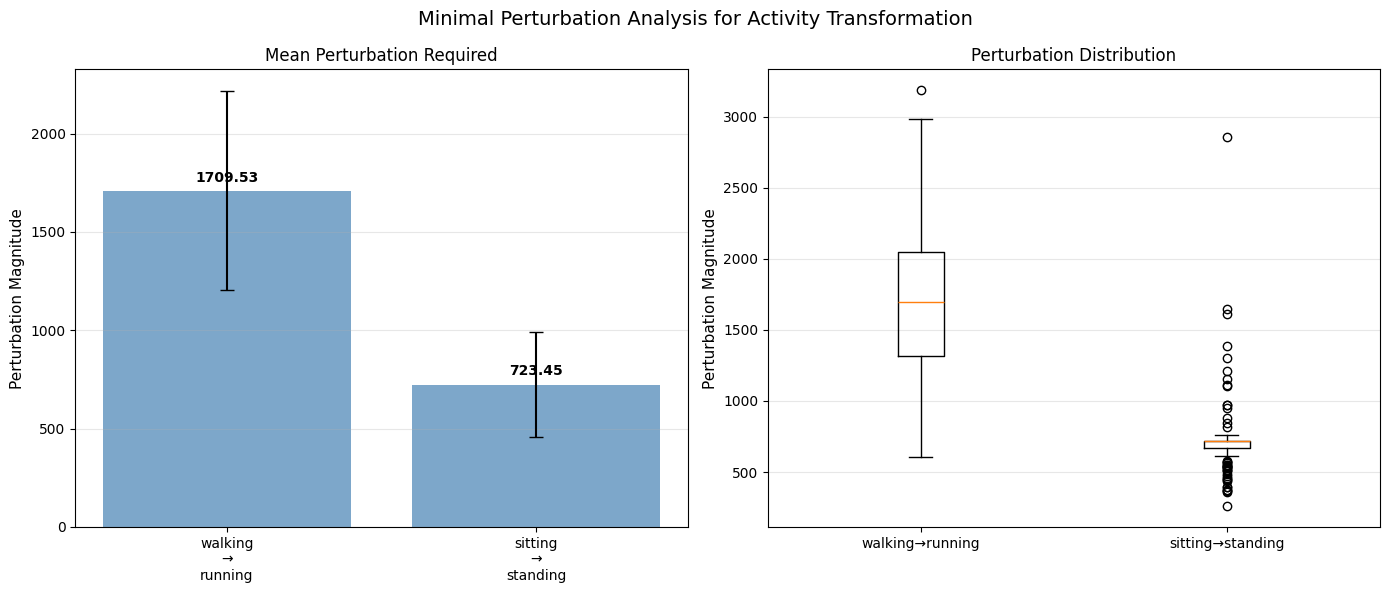

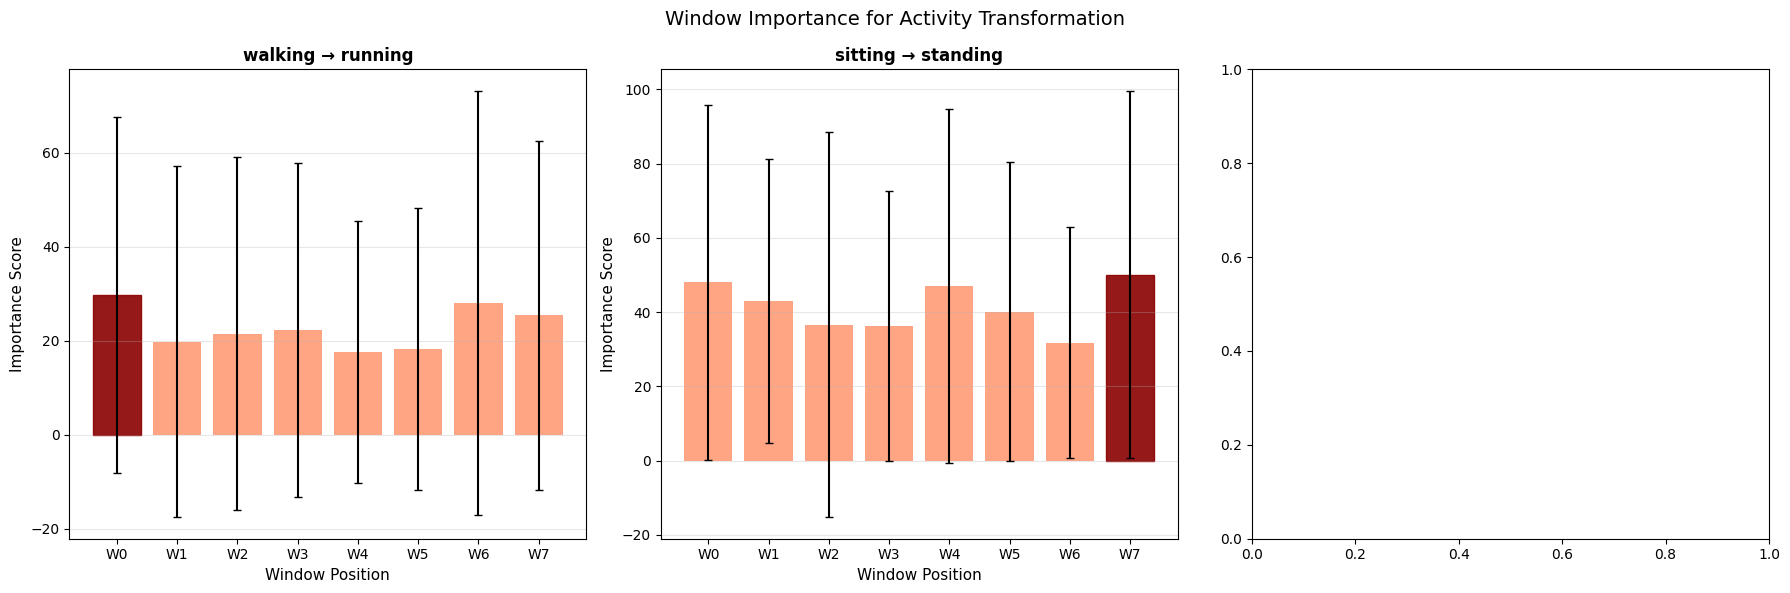

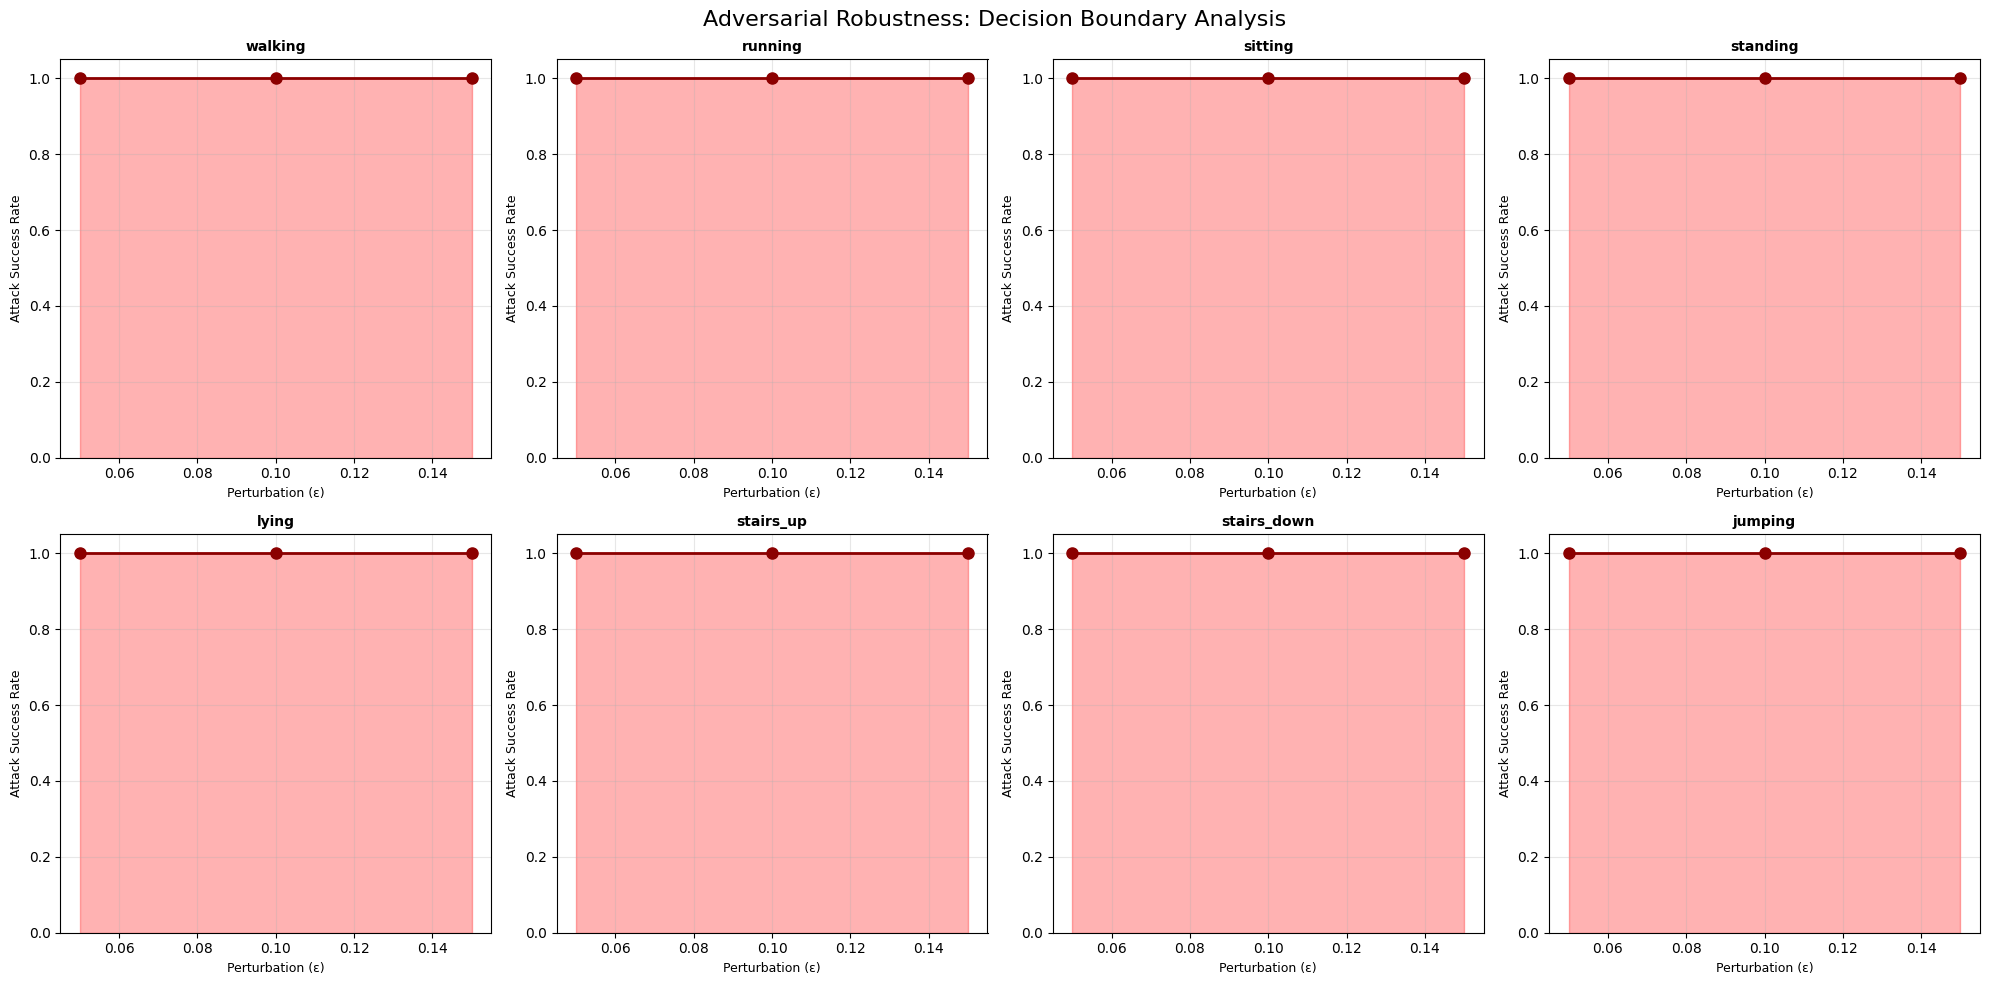

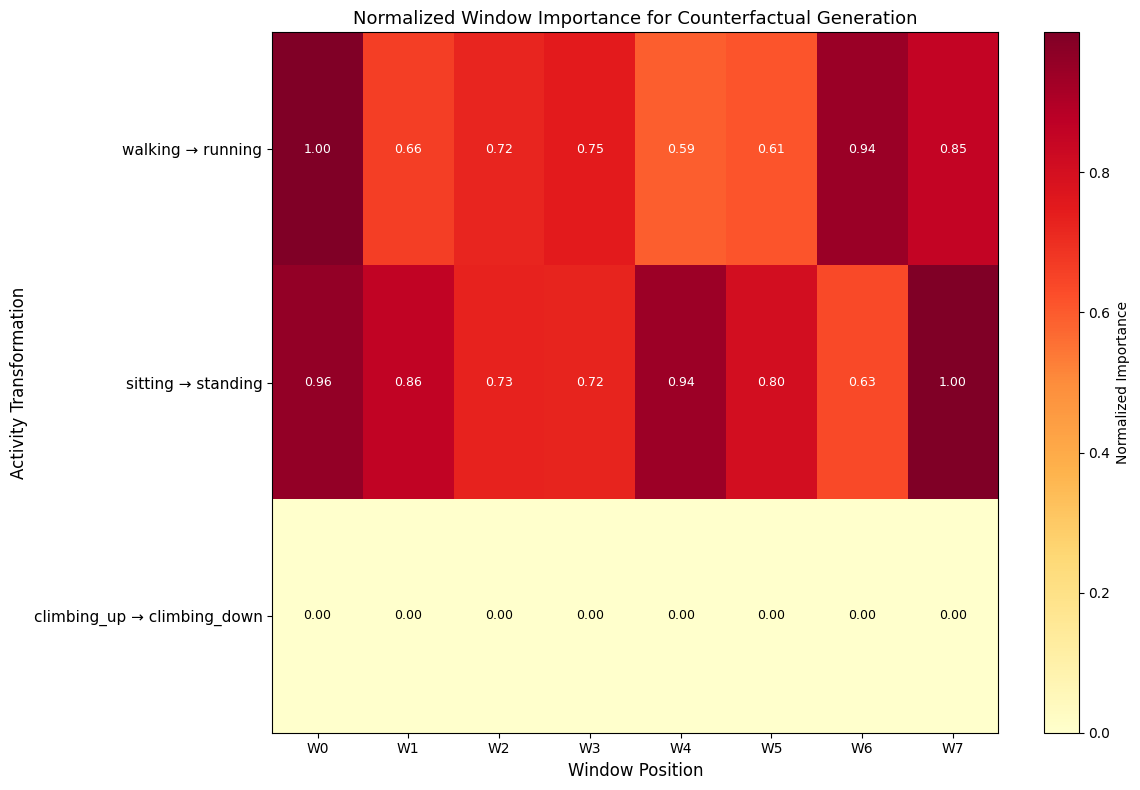

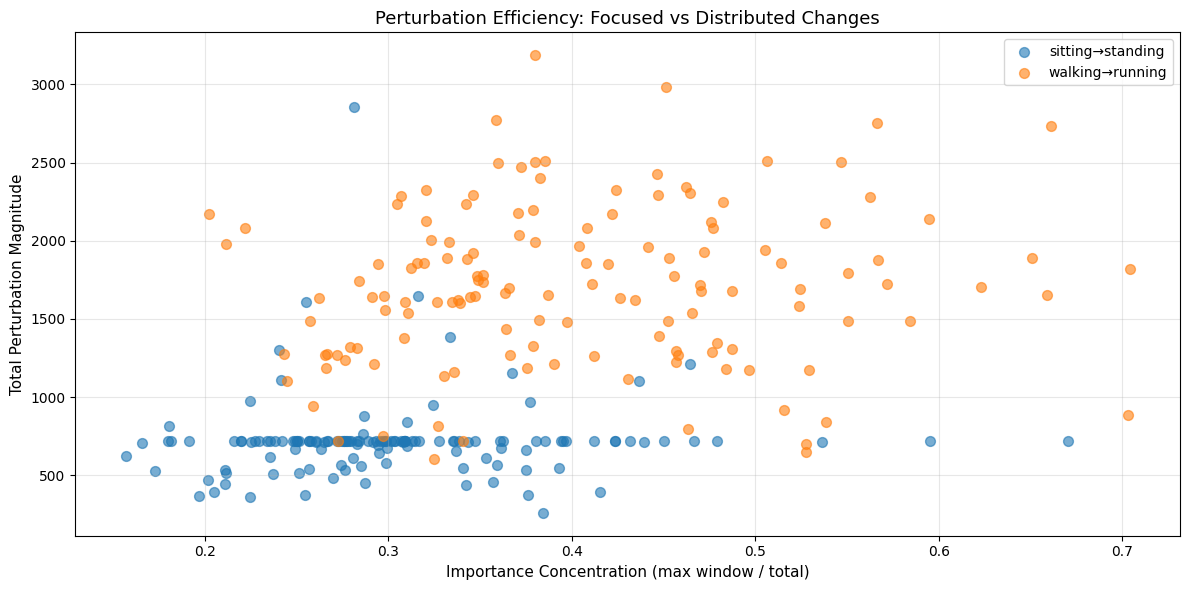

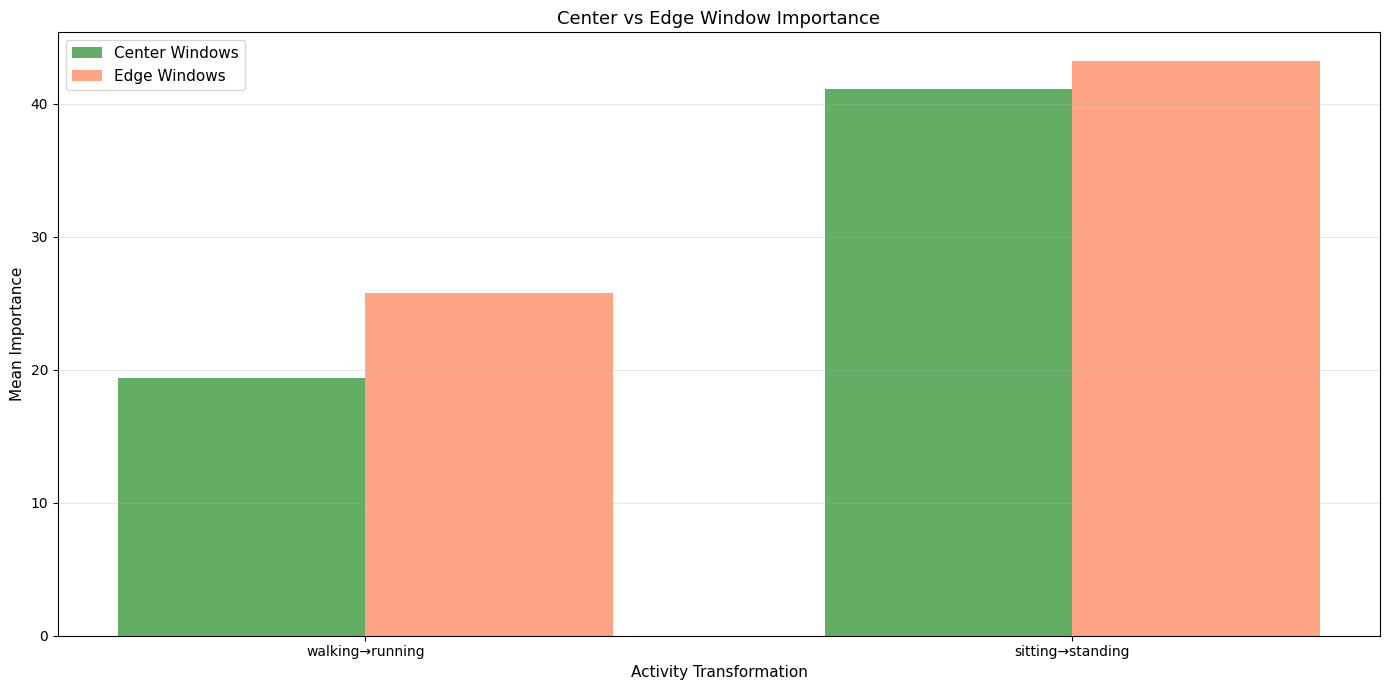


Counterfactual explanation analysis completed!
Figures saved to: /content/figures

Minimal Perturbation Summary:
  walking → running: 1709.5314 ± 506.6937
  sitting → standing: 723.4547 ± 265.6455


In [ ]:
# ================ Step 10e: Counterfactual Explanations ================

import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import torch
import torch.nn as nn
from pathlib import Path
from collections import defaultdict
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

BASE = Path("/content")
features_dir = BASE / "features"
configs_dir  = BASE / "configs"
logs_dir     = BASE / "logs"
fig_dir      = BASE / "figures"
models_dir   = BASE / "models"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open(configs_dir / 'classes.json', 'r') as f:
    classes_cfg = json.load(f)
with open(configs_dir / 'splits.json', 'r') as f:
    splits_cfg = json.load(f)

CLASS_NAMES = [classes_cfg['id_to_label'][str(i)] for i in range(classes_cfg['num_classes'])]
NUM_CLASSES = classes_cfg['num_classes']
SEQ_LEN = 8
BATCH_SIZE = 32

counterfactual_data = defaultdict(lambda: defaultdict(list))
perturbation_magnitudes = defaultdict(list)
decision_boundary_samples = defaultdict(list)

class DepthwiseSeparableConv1d(nn.Module):
    def __init__(self, in_ch, out_ch, k, dilation=1, dropout=0.0):
        super().__init__()
        pad = (k // 2) * dilation
        self.dw = nn.Conv1d(in_ch, in_ch, kernel_size=k, padding=pad, dilation=dilation, groups=in_ch, bias=False)
        self.pw = nn.Conv1d(in_ch, out_ch, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm1d(out_ch)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        x = self.dw(x)
        x = self.pw(x)
        x = self.bn(x)
        x = self.act(x)
        return self.drop(x)

class WindowEncoder(nn.Module):
    def __init__(self, in_ch=6, d_model=128, dropout=0.2):
        super().__init__()
        self.in_ch = in_ch
        self.aug_ch = in_ch + 2
        self.b1 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=9, dilation=1, dropout=dropout)
        self.b2 = DepthwiseSeparableConv1d(self.aug_ch, d_model//2, k=19, dilation=2, dropout=dropout)
        self.mix = nn.Conv1d(d_model, d_model, kernel_size=1, bias=False)
        self.bn  = nn.BatchNorm1d(d_model)
        self.act = nn.GELU()
        self.drop = nn.Dropout(dropout)
        self.g_proj = nn.Sequential(
            nn.Linear(4, d_model), nn.GELU(), nn.Linear(d_model, d_model)
        )
    def forward(self, x):
        BLT, C, T = x.shape
        acc_norm = torch.sqrt((x[:,0,:]**2 + x[:,1,:]**2 + x[:,2,:]**2) + 1e-8).unsqueeze(1)
        gyr_norm = torch.sqrt((x[:,3,:]**2 + x[:,4,:]**2 + x[:,5,:]**2) + 1e-8).unsqueeze(1)
        x_aug = torch.cat([x, acc_norm, gyr_norm], dim=1)
        z = torch.cat([self.b1(x_aug), self.b2(x_aug)], dim=1)
        z = self.mix(z)
        z = self.bn(z)
        z = self.act(z)
        z = self.drop(z)
        token = z.mean(dim=-1)
        acc_rms = acc_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        gyr_rms = gyr_norm.squeeze(1).pow(2).mean(dim=-1).sqrt()
        acc_en  = x[:,0:3,:].pow(2).mean(dim=(1,2)).sqrt()
        gyr_en  = x[:,3:6,:].pow(2).mean(dim=(1,2)).sqrt()
        g = torch.stack([acc_rms, gyr_rms, acc_en, gyr_en], dim=-1)
        g = self.g_proj(g)
        return token, g

class CondLayerNorm(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.ln = nn.LayerNorm(d_model)
        self.gamma = nn.Linear(d_model, d_model)
        self.beta  = nn.Linear(d_model, d_model)
    def forward(self, x, g):
        y = self.ln(x)
        return y * (1 + self.gamma(g)) + self.beta(g)

class RCCBlock(nn.Module):
    def __init__(self, d_model=128, n_heads=4, d_ff=512, dropout=0.2):
        super().__init__()
        self.condln1 = CondLayerNorm(d_model)
        self.mha = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.drop1 = nn.Dropout(dropout)
        self.condln2 = CondLayerNorm(d_model)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.drop2 = nn.Dropout(dropout)
    def forward(self, x, g):
        y = self.condln1(x, g)
        attn, _ = self.mha(y, y, y, need_weights=False)
        x = x + self.drop1(attn)
        y = self.condln2(x, g)
        y = self.ff(y)
        x = x + self.drop2(y)
        return x

class GeoContextHAR(nn.Module):
    def __init__(self, in_ch=6, d_model=128, n_layers=2, n_heads=4, d_ff=512, dropout=0.2, seq_len=8, num_classes=8):
        super().__init__()
        self.seq_len = seq_len
        self.encoder = WindowEncoder(in_ch=in_ch, d_model=d_model, dropout=dropout)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos = nn.Parameter(torch.zeros(1, seq_len + 1, d_model))
        self.blocks = nn.ModuleList([RCCBlock(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)])
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)

    def forward(self, x):
        B, L, C, T = x.shape
        x = x.reshape(B*L, C, T)
        token, g = self.encoder(x)
        token = token.view(B, L, -1)
        g = g.view(B, L, -1)
        cls = self.cls_token.expand(B, -1, -1)
        z = torch.cat([cls, token], dim=1)
        g_cls = g.mean(dim=1, keepdim=True)
        g_all = torch.cat([g_cls, g], dim=1)
        z = z + self.pos
        for blk in self.blocks:
            z = blk(z, g_all)
        z = self.norm(z)
        cls = z[:, 0, :]
        logits = self.head(cls)
        return logits

def parse_window_id(wid: str):
    parts = wid.split(':')
    if len(parts) != 3:
        return wid, 0, 0
    return parts[0], int(parts[1]), int(parts[2])

class SeqDataset(Dataset):
    def __init__(self, npz_path: Path, split: str, seq_len=8, seq_stride=4):
        super().__init__()
        self.npz = np.load(npz_path, allow_pickle=True)
        self.split = split
        self.seq_len = seq_len

        self.ax = self.npz['acc_x']; self.ay = self.npz['acc_y']; self.az = self.npz['acc_z']
        self.gx = self.npz['gyro_x']; self.gy = self.npz['gyro_y']; self.gz = self.npz['gyro_z']
        self.labels  = self.npz['labels'].astype(np.int64)
        self.splits  = np.array(self.npz['splits']).astype(str)
        self.win_ids = np.array(self.npz['window_ids']).astype(str)
        self.subjects= np.array(self.npz['subjects']).astype(str)

        idx_split = np.where(self.splits == split)[0]
        groups = defaultdict(list)
        for idx in idx_split:
            f, seg, st = parse_window_id(self.win_ids[idx])
            groups[(self.subjects[idx], f, seg)].append((st, idx))

        self.seq_items = []
        for key, lst in groups.items():
            lst.sort(key=lambda x: x[0])
            order = [idx for _, idx in lst]
            if len(order) < seq_len:
                continue
            for i in range(0, len(order) - seq_len + 1, seq_stride):
                seq_idx = order[i:i+seq_len]
                center_idx = seq_idx[seq_len // 2]
                label = int(self.labels[center_idx])
                self.seq_items.append((seq_idx, center_idx, label))

    def __len__(self):
        return len(self.seq_items)

    def __getitem__(self, i):
        seq_idx, center_idx, label = self.seq_items[i]
        L = len(seq_idx); C = 6; T = self.ax.shape[1]
        X = np.zeros((L, C, T), dtype=np.float32)
        for j, idx in enumerate(seq_idx):
            X[j,0,:] = self.ax[idx]; X[j,1,:] = self.ay[idx]; X[j,2,:] = self.az[idx]
            X[j,3,:] = self.gx[idx]; X[j,4,:] = self.gy[idx]; X[j,5,:] = self.gz[idx]
        return torch.from_numpy(X), torch.tensor(label, dtype=torch.long), center_idx

def collate_fn(batch):
    xs, ys, centers = zip(*batch)
    return torch.stack(xs), torch.stack(ys), torch.tensor(centers, dtype=torch.long)

def minimal_perturbation_window(model, X, original_label, target_label, max_iters=50, lr=0.1):
    model.eval()
    X_pert = X.clone().detach()
    X_pert.requires_grad = True

    window_importance = torch.zeros(SEQ_LEN, device=X.device)

    for iteration in range(max_iters):
        logits = model(X_pert)
        pred = logits.argmax(dim=1).item()

        if pred == target_label:
            break

        loss = -logits[0, target_label] + logits[0, original_label]

        model.zero_grad()
        if X_pert.grad is not None:
            X_pert.grad.zero_()
        loss.backward()

        grad = X_pert.grad.data
        window_grads = grad[0].abs().sum(dim=(1, 2))
        window_importance += window_grads

        X_pert.data = X_pert.data - lr * grad.sign()
        X_pert.data = torch.clamp(X_pert.data, X.min(), X.max())

    perturbation = (X_pert - X).abs().sum()
    success = (logits.argmax(dim=1).item() == target_label)

    return X_pert, perturbation.item(), success, window_importance.cpu().numpy()

def generate_adversarial_sample(model, X, original_label, epsilon=0.1):
    model.eval()
    X_adv = X.clone().detach()
    X_adv.requires_grad = True

    logits = model(X_adv)
    loss = nn.CrossEntropyLoss()(logits, torch.tensor([original_label], device=X.device))

    model.zero_grad()
    loss.backward()

    grad = X_adv.grad.data
    X_adv = X_adv + epsilon * grad.sign()
    X_adv = torch.clamp(X_adv, X.min(), X.max())

    with torch.no_grad():
        logits_adv = model(X_adv)
        pred_adv = logits_adv.argmax(dim=1).item()

    return X_adv, pred_adv

print("Analyzing counterfactual explanations across all folds...")

similar_pairs = [
    ('walking', 'running'),
    ('sitting', 'standing'),
    ('climbing_up', 'climbing_down'),
]

for fold in splits_cfg['folds']:
    k = fold['fold']
    npz_path = features_dir / f'windows_normalized_fold{k}.npz'
    model_path = models_dir / f"rccmix_har_fold{k}.pt"

    if not npz_path.exists() or not model_path.exists():
        continue

    print(f"Processing fold {k}...")

    ds_test = SeqDataset(npz_path, 'test', SEQ_LEN, 4)
    loader_test = DataLoader(ds_test, batch_size=1, shuffle=False,
                            num_workers=0, pin_memory=False, collate_fn=collate_fn)

    model = GeoContextHAR(in_ch=6, d_model=128, n_layers=2, n_heads=4,
                          d_ff=512, dropout=0.2, seq_len=SEQ_LEN,
                          num_classes=NUM_CLASSES).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    sample_count = defaultdict(int)
    max_samples = 10

    for X, y, _ in loader_test:
        X = X.to(device)
        label = y.item()
        class_name = CLASS_NAMES[label]

        with torch.no_grad():
            logits = model(X)
            pred = logits.argmax(dim=1).item()

        if pred != label:
            continue

        for source_class, target_class in similar_pairs:
            if class_name == source_class:
                target_label = CLASS_NAMES.index(target_class)

                if sample_count[f'{source_class}_to_{target_class}'] >= max_samples:
                    continue

                X_cf, pert_mag, success, win_imp = minimal_perturbation_window(
                    model, X, label, target_label, max_iters=50, lr=0.1
                )

                if success:
                    counterfactual_data[f'{source_class}_to_{target_class}']['perturbation'].append(pert_mag)
                    counterfactual_data[f'{source_class}_to_{target_class}']['window_importance'].append(win_imp)
                    perturbation_magnitudes[source_class].append(pert_mag)

                    sample_count[f'{source_class}_to_{target_class}'] += 1

        for epsilon in [0.05, 0.1, 0.15]:
            X_adv, pred_adv = generate_adversarial_sample(model, X, label, epsilon=epsilon)

            if pred_adv != label:
                decision_boundary_samples[class_name].append({
                    'epsilon': epsilon,
                    'original_label': label,
                    'adversarial_label': pred_adv,
                    'original_conf': torch.softmax(logits, dim=1)[0, label].item(),
                })

        if all(sample_count[f'{s}_to_{t}'] >= max_samples for s, t in similar_pairs):
            break

print("\nGenerating visualizations...")

# ========== Visualization 1: Minimal Perturbation Magnitudes ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Minimal Perturbation Analysis for Activity Transformation', fontsize=14)

pair_names = []
pert_means = []
pert_stds = []

for source, target in similar_pairs:
    key = f'{source}_to_{target}'
    if key in counterfactual_data and counterfactual_data[key]['perturbation']:
        pair_names.append(f'{source}\n→\n{target}')
        perts = counterfactual_data[key]['perturbation']
        pert_means.append(np.mean(perts))
        pert_stds.append(np.std(perts))

if pair_names:
    x = np.arange(len(pair_names))
    bars = axes[0].bar(x, pert_means, yerr=pert_stds, color='steelblue', alpha=0.7, capsize=5)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(pair_names, fontsize=10)
    axes[0].set_ylabel('Perturbation Magnitude', fontsize=11)
    axes[0].set_title('Mean Perturbation Required', fontsize=12)
    axes[0].grid(axis='y', alpha=0.3)

    for bar, mean in zip(bars, pert_means):
        axes[0].text(bar.get_x() + bar.get_width()/2, mean + axes[0].get_ylim()[1]*0.02,
                    f'{mean:.2f}', ha='center', fontsize=10, fontweight='bold')

all_perts = []
all_labels = []
for source, target in similar_pairs:
    key = f'{source}_to_{target}'
    if key in counterfactual_data and counterfactual_data[key]['perturbation']:
        all_perts.extend(counterfactual_data[key]['perturbation'])
        all_labels.extend([f'{source}→{target}'] * len(counterfactual_data[key]['perturbation']))

if all_perts:
    data_for_box = [counterfactual_data[f'{s}_to_{t}']['perturbation']
                    for s, t in similar_pairs
                    if f'{s}_to_{t}' in counterfactual_data and counterfactual_data[f'{s}_to_{t}']['perturbation']]

    axes[1].boxplot(data_for_box, labels=[f'{s}→{t}' for s, t in similar_pairs if f'{s}_to_{t}' in counterfactual_data and counterfactual_data[f'{s}_to_{t}']['perturbation']])
    axes[1].set_ylabel('Perturbation Magnitude', fontsize=11)
    axes[1].set_title('Perturbation Distribution', fontsize=12)
    axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(fig_dir / 'step10e_perturbation_magnitude.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 2: Window Importance for Counterfactuals ==========
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Window Importance for Activity Transformation', fontsize=14)

for idx, (source, target) in enumerate(similar_pairs):
    key = f'{source}_to_{target}'
    ax = axes[idx]

    if key in counterfactual_data and counterfactual_data[key]['window_importance']:
        win_imps = np.array(counterfactual_data[key]['window_importance'])
        mean_imp = win_imps.mean(axis=0)
        std_imp = win_imps.std(axis=0)

        x = np.arange(SEQ_LEN)
        bars = ax.bar(x, mean_imp, yerr=std_imp, color='coral', alpha=0.7, capsize=3)
        ax.set_xlabel('Window Position', fontsize=11)
        ax.set_ylabel('Importance Score', fontsize=11)
        ax.set_title(f'{source} → {target}', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([f'W{i}' for i in range(SEQ_LEN)])
        ax.grid(axis='y', alpha=0.3)

        max_idx = mean_imp.argmax()
        bars[max_idx].set_color('darkred')
        bars[max_idx].set_alpha(0.9)

plt.tight_layout()
plt.savefig(fig_dir / 'step10e_window_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 3: Decision Boundary Exploration ==========
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Adversarial Robustness: Decision Boundary Analysis', fontsize=16)
axes = axes.flatten()

for idx, class_name in enumerate(CLASS_NAMES):
    ax = axes[idx]

    if class_name in decision_boundary_samples and decision_boundary_samples[class_name]:
        samples = decision_boundary_samples[class_name]

        epsilon_groups = defaultdict(lambda: {'success': 0, 'total': 0})

        for sample in samples:
            eps = sample['epsilon']
            epsilon_groups[eps]['total'] += 1
            if sample['adversarial_label'] != sample['original_label']:
                epsilon_groups[eps]['success'] += 1

        epsilons = sorted(epsilon_groups.keys())
        success_rates = [epsilon_groups[e]['success'] / epsilon_groups[e]['total']
                        if epsilon_groups[e]['total'] > 0 else 0
                        for e in epsilons]

        ax.plot(epsilons, success_rates, marker='o', linewidth=2, markersize=8, color='darkred')
        ax.fill_between(epsilons, success_rates, alpha=0.3, color='red')
        ax.set_xlabel('Perturbation (ε)', fontsize=9)
        ax.set_ylabel('Attack Success Rate', fontsize=9)
        ax.set_title(class_name, fontsize=10, fontweight='bold')
        ax.set_ylim([0, 1.05])
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_dir / 'step10e_decision_boundary.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 4: Counterfactual Heatmap ==========
fig, ax = plt.subplots(figsize=(12, 8))

cf_matrix = np.zeros((len(similar_pairs), SEQ_LEN))

for idx, (source, target) in enumerate(similar_pairs):
    key = f'{source}_to_{target}'
    if key in counterfactual_data and counterfactual_data[key]['window_importance']:
        win_imps = np.array(counterfactual_data[key]['window_importance'])
        cf_matrix[idx] = win_imps.mean(axis=0)

if cf_matrix.sum() > 0:
    cf_matrix_norm = cf_matrix / (cf_matrix.max(axis=1, keepdims=True) + 1e-8)

    im = ax.imshow(cf_matrix_norm, cmap='YlOrRd', aspect='auto')
    ax.set_yticks(range(len(similar_pairs)))
    ax.set_yticklabels([f'{s} → {t}' for s, t in similar_pairs], fontsize=11)
    ax.set_xticks(range(SEQ_LEN))
    ax.set_xticklabels([f'W{i}' for i in range(SEQ_LEN)], fontsize=10)
    ax.set_xlabel('Window Position', fontsize=12)
    ax.set_ylabel('Activity Transformation', fontsize=12)
    ax.set_title('Normalized Window Importance for Counterfactual Generation', fontsize=13)

    for i in range(len(similar_pairs)):
        for j in range(SEQ_LEN):
            text = ax.text(j, i, f'{cf_matrix_norm[i, j]:.2f}',
                         ha="center", va="center", color="black" if cf_matrix_norm[i, j] < 0.5 else "white",
                         fontsize=9)

    plt.colorbar(im, ax=ax, label='Normalized Importance')

plt.tight_layout()
plt.savefig(fig_dir / 'step10e_counterfactual_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 5: Perturbation Efficiency ==========
fig, ax = plt.subplots(figsize=(12, 6))

efficiency_data = []

for source, target in similar_pairs:
    key = f'{source}_to_{target}'
    if key in counterfactual_data and counterfactual_data[key]['perturbation']:
        perts = counterfactual_data[key]['perturbation']
        win_imps = np.array(counterfactual_data[key]['window_importance'])

        for i, (pert, imp) in enumerate(zip(perts, win_imps)):
            most_important_window = imp.argmax()
            importance_concentration = imp[most_important_window] / (imp.sum() + 1e-8)

            efficiency_data.append({
                'pair': f'{source}→{target}',
                'perturbation': pert,
                'concentration': importance_concentration
            })

if efficiency_data:
    for pair_name in set([d['pair'] for d in efficiency_data]):
        pair_data = [d for d in efficiency_data if d['pair'] == pair_name]
        x_vals = [d['concentration'] for d in pair_data]
        y_vals = [d['perturbation'] for d in pair_data]

        ax.scatter(x_vals, y_vals, s=50, alpha=0.6, label=pair_name)

    ax.set_xlabel('Importance Concentration (max window / total)', fontsize=11)
    ax.set_ylabel('Total Perturbation Magnitude', fontsize=11)
    ax.set_title('Perturbation Efficiency: Focused vs Distributed Changes', fontsize=13)
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_dir / 'step10e_perturbation_efficiency.png', dpi=150, bbox_inches='tight')
plt.show()

# ========== Visualization 6: Key Feature Analysis ==========
fig, ax = plt.subplots(figsize=(14, 7))

key_features_summary = []

for source, target in similar_pairs:
    key = f'{source}_to_{target}'
    if key in counterfactual_data and counterfactual_data[key]['window_importance']:
        win_imps = np.array(counterfactual_data[key]['window_importance'])

        center_windows = win_imps[:, SEQ_LEN//2-1:SEQ_LEN//2+2].mean()
        edge_windows = (win_imps[:, :2].mean() + win_imps[:, -2:].mean()) / 2

        key_features_summary.append({
            'transformation': f'{source}→{target}',
            'center': center_windows,
            'edges': edge_windows
        })

if key_features_summary:
    transformations = [kf['transformation'] for kf in key_features_summary]
    center_vals = [kf['center'] for kf in key_features_summary]
    edge_vals = [kf['edges'] for kf in key_features_summary]

    x = np.arange(len(transformations))
    width = 0.35

    ax.bar(x - width/2, center_vals, width, label='Center Windows', color='forestgreen', alpha=0.7)
    ax.bar(x + width/2, edge_vals, width, label='Edge Windows', color='coral', alpha=0.7)

    ax.set_xlabel('Activity Transformation', fontsize=11)
    ax.set_ylabel('Mean Importance', fontsize=11)
    ax.set_title('Center vs Edge Window Importance', fontsize=13)
    ax.set_xticks(x)
    ax.set_xticklabels(transformations, fontsize=10)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(fig_dir / 'step10e_key_features.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCounterfactual explanation analysis completed!")
print(f"Figures saved to: {fig_dir}")

if pair_names:
    print(f"\nMinimal Perturbation Summary:")
    for name, mean, std in zip(pair_names, pert_means, pert_stds):
        print(f"  {name.replace(chr(10), ' ')}: {mean:.4f} ± {std:.4f}")